## Clustering and functional analysis on Bayesian timescales
Author: Robert Ietswaart  
Date: 20240108  
License: BSD2.  
Load modules j3dl and activate virtual environment using j4RNAdecay on O2.  
Python v3.7.4

Source: `Function_20220301.ipynb`  
For Subcellular Timelapse seq project. 

In [1]:
import os
import re
import copy
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import logging
import argparse
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.stats import gmean, gstd, spearmanr, mode
import new_total_ratio_jit as ntr
import fit

import urllib.request
from goatools.obo_parser import GODag
from goatools.base import download_ncbi_associations
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

from scipy.stats import fisher_exact, chi2_contingency, mannwhitneyu

# from sklearn.cluster import AgglomerativeClustering

from __init__ import default_logger_format, default_date_format

In [2]:
# def main():
np.random.seed(12345)

parser = argparse.ArgumentParser(
    description='Functional analysis of Bayes timescales.')

args = parser.parse_args("")#EDIT: added "" as argument to run in ipynb instead of .py script

In [3]:
path = os.path.join('/n','groups','churchman','ri23','bseq','Function20240108')

# Add a logger specific to the project and processing stage
logger = logging.getLogger('Function')
log_file = os.path.join(path,'LogErr', 'Functional_Analysis_20240108.log')
formatter = logging.Formatter(default_logger_format,
                              datefmt=default_date_format)
log_handler = logging.FileHandler(log_file)
log_handler.setFormatter(formatter)
logger.addHandler(log_handler)

organisms = ['m','h']
org_map = {'m': 'mouse', 'h': 'human'}
org_id_map = {'m': 10090, 'h': 9606}
fracs = ['chr', 'nuc', 'cyto', 'poly', 'tot']
reps = ['G','H','R','S','T','U']
red_reps = ['G_R', 'H_S', 'T', 'U']
# org_reps = {'m': ['G','H','R','S'], 'h': ['T', 'U']}
org_red_reps = {'m': ['G_R','H_S'], 'h': ['T', 'U']}
red_r = {'G': 'G_R', 'H': 'H_S', 'R': 'G_R', 'S': 'H_S', 'T': 'T', 'U': 'U'}
time_id = [str(i) for i in range(1,6)]
background_id = {r: '1' for r in reps}
time_mins = [0, 15, 30, 60, 120]
# T_bound_lo = 1e-4 #unit: min, ~6 ms
# T_bound_hi = 1e4 #unit: min, ~7 days

fracs_model = {'chr': ['chr_fit'],  
               'nuc': ['nuc_fit', 
                       'nuc_fit_from_chr_nucres', 
                       'nuc_fit_from_chr_nucdeg'],
               'cyto': ['cyto_fit_from_nuc', 
                        'cyto_pred_from_chr_nucres', 
                        'cyto_pred_from_chr_nucdeg'],
               'poly': ['poly_fit_from_nuc'],
               'tot': ['tot_fit', 'tot_pred_from_nuc', 
                       'tot_pred_from_chr_nucres', 
                       'tot_pred_from_chr_nucdeg']}

RATE_TYPE = ['half_life_','k_']
rt = RATE_TYPE[0]
OUT_TYPES = ['.Mean', '.MAP', '.0.025.quantile', '.0.975.quantile']

Timescales = ['whole_cell',
              'chr',
              'nuc',
              'cyto',
              'poly_entry',
              'nucexp_from_nucres',
              'nucexp_from_dist',
              'nucdeg',
              'nucexp_from_nucdeg',              
              'chr_release_from_nucdeg']
Timescales = [rt + ts for ts in Timescales]


# improved color code from 20211104
cmap={'chr':'#1D5386', 'nuc':'#506C23', 'cyto':'#B80000', 'poly':'#9E2E93', 'tot':'#D66B1F'}

path_b = dict()
path_b['h'] = os.path.join('/n','groups','churchman','ri23','bseq','Bayes20240120_K562')#'Bayes20240119_K562'#'Bayes20231201_K562')
path_b['m'] = os.path.join('/n','groups','churchman','ri23','bseq','Bayes20240120_3T3') #'Bayes20231201_3T3')

path_k = os.path.join('/n','groups','churchman','ri23','bseq','BayesFactor20240112')


logger.info('Load Bayes Rates and BayesFactor outputs')
B = dict()          #Bayes fits file
K = dict()          #Bayes Factor
for o in organisms:
    filename_b = 'Bayes_Rates_20240120_'+ org_map[o] + '_final.tsv'#'Bayes_Rates_20240119_'+ org_map[o] + '.tsv' #20231201
    filename_k = 'Bayes_factor_20240112_' + org_map[o] + '_final.tsv'

    B[o] = pd.read_csv(os.path.join(path_b[o], filename_b), sep='\t')
    K[o] = pd.read_csv(os.path.join(path_k, filename_k), sep='\t')
  

INFO: [2024-05-27 11:42:23] Function - Load Bayes Rates and BayesFactor outputs


### Clustering parameters: 
optimized for visualization and robustness of conclusions  
rt = half_life_, metric = seuclidean, N_clust = 50 (low/up bound controls 35 and 100), 
w Poly no MAP lower / upper cap 1e-1, 24h

In [4]:
Timescales_order = ['whole_cell',
                    'chr',
                    'nuc',
                    'cyto',
                    'poly_entry',
                    'chr_release',
                    'nucdeg',
                    'nucexp']

Timescales_v2_order =  Timescales_order
Timescales_v2_order = [ts.replace('_', ' ') for ts in Timescales_v2_order]
Timescales_order = [rt + ts for ts in Timescales_order]
Timescales_clust = ['chr',
                    'nuc',
                    'cyto',
                    'poly_entry',
                    'whole_cell']
Timescales_clust = [rt + ts for ts in Timescales_clust]

In [5]:
clust_cols = dict()
vis_cols = dict()
deriv_cols = dict()
idx_add = 5
for o in organisms:
    vis_cols[o] = []
    clust_cols[o] = []
    deriv_cols[o] = []
    for ts in Timescales_clust:#Timescales_order[:idx_add]:
        for ot in [OUT_TYPES[2], OUT_TYPES[1], OUT_TYPES[3]]:
            for rr in org_red_reps[o]:
                if not ts+ot == rt+'poly_entry'+OUT_TYPES[1]:#Poly are less reproducible: use only CI for clust
                    clust_cols[o].append(rr+'.'+ts+ot)

    vis_cols[o] = []
    for ts in Timescales:#different col order to match Brendan's Fig1
        for ot in [OUT_TYPES[2], OUT_TYPES[1], OUT_TYPES[3]]:
            for rr in org_red_reps[o]:
                vis_cols[o].append(rr+'.'+ts+ot)
                
    deriv_cols[o] = []
    for ts in Timescales_order[idx_add:]:
        for ot in [OUT_TYPES[2], OUT_TYPES[1], OUT_TYPES[3]]:
            for rr in org_red_reps[o]:
                deriv_cols[o].append(rr+'.'+ts+ot)

clust_cols['h']

['T.half_life_chr.0.025.quantile',
 'U.half_life_chr.0.025.quantile',
 'T.half_life_chr.MAP',
 'U.half_life_chr.MAP',
 'T.half_life_chr.0.975.quantile',
 'U.half_life_chr.0.975.quantile',
 'T.half_life_nuc.0.025.quantile',
 'U.half_life_nuc.0.025.quantile',
 'T.half_life_nuc.MAP',
 'U.half_life_nuc.MAP',
 'T.half_life_nuc.0.975.quantile',
 'U.half_life_nuc.0.975.quantile',
 'T.half_life_cyto.0.025.quantile',
 'U.half_life_cyto.0.025.quantile',
 'T.half_life_cyto.MAP',
 'U.half_life_cyto.MAP',
 'T.half_life_cyto.0.975.quantile',
 'U.half_life_cyto.0.975.quantile',
 'T.half_life_poly_entry.0.025.quantile',
 'U.half_life_poly_entry.0.025.quantile',
 'T.half_life_poly_entry.0.975.quantile',
 'U.half_life_poly_entry.0.975.quantile',
 'T.half_life_whole_cell.0.025.quantile',
 'U.half_life_whole_cell.0.025.quantile',
 'T.half_life_whole_cell.MAP',
 'U.half_life_whole_cell.MAP',
 'T.half_life_whole_cell.0.975.quantile',
 'U.half_life_whole_cell.0.975.quantile']

In [6]:
# vis_cols['h']
deriv_cols['h']

['T.half_life_chr_release.0.025.quantile',
 'U.half_life_chr_release.0.025.quantile',
 'T.half_life_chr_release.MAP',
 'U.half_life_chr_release.MAP',
 'T.half_life_chr_release.0.975.quantile',
 'U.half_life_chr_release.0.975.quantile',
 'T.half_life_nucdeg.0.025.quantile',
 'U.half_life_nucdeg.0.025.quantile',
 'T.half_life_nucdeg.MAP',
 'U.half_life_nucdeg.MAP',
 'T.half_life_nucdeg.0.975.quantile',
 'U.half_life_nucdeg.0.975.quantile',
 'T.half_life_nucexp.0.025.quantile',
 'U.half_life_nucexp.0.025.quantile',
 'T.half_life_nucexp.MAP',
 'U.half_life_nucexp.MAP',
 'T.half_life_nucexp.0.975.quantile',
 'U.half_life_nucexp.0.975.quantile']

In [7]:
## Prefilter timescales for NA data
T_bf = 100

C = copy.deepcopy(B)
for o in organisms:
    C[o] = C[o].merge(K[o], on='Gene', suffixes=('', '_bf'))
    logger.info('%s all genes: %d' % (org_map[o], len(C[o])))
    C[o] = C[o][~C[o][clust_cols[o]].isna().any(axis=1)]
    logger.info('%s genes without NA cluster timescales: %d' % (org_map[o], len(C[o])))
    
    for ts in Timescales_order:
        for ot in OUT_TYPES:
            for rr in org_red_reps[o]: 
                if ts == rt + 'chr_release':
                    C[o][rr+'.'+ts+ot] = copy.deepcopy(C[o][rr+'.'+ts+'_from_nucdeg.MAP'].where(
                        C[o]['PUND'], C[o][rr+'.'+rt+'chr'+ot]))
                if ts == rt + 'nucdeg':#only for nucdeg genes according to Bayes Factor
                    C[o][rr+'.'+ts+ot] = copy.deepcopy(C[o][rr+'.'+ts+'.MAP'].where(C[o]['PUND'], (24*60)))
                if ts == rt + 'nucexp':
                    C[o][rr+'.'+ts+ot] = copy.deepcopy(C[o][rr+'.'+ts+'_from_nucdeg.MAP'].where(
                        C[o]['PUND'], C[o][rr+'.'+ts+'_from_nucres'+ot]))

                ###Clip range of values beyond realistic timescale values: 0.1min and 24h 
                #do not clip 1 fraction: not good for robustness of clustering: avoid or clip all fractions
                if rr+'.'+ts+ot in C[o].keys():
                    C[o][rr+'.'+ts+ot].where(C[o][rr+'.'+ts+ot] > 1e-1, 1e-1, inplace=True) 
                    C[o][rr+'.'+ts+ot].where(C[o][rr+'.'+ts+ot] < (24*60), (24*60), inplace=True)                  

INFO: [2024-05-26 19:20:42] Function - mouse all genes: 17821
INFO: [2024-05-26 19:20:42] Function - mouse genes without NA cluster timescales: 11048
INFO: [2024-05-26 19:20:43] Function - human all genes: 17985
INFO: [2024-05-26 19:20:43] Function - human genes without NA cluster timescales: 10802


## Hierarchical clustering in Python:
and NOT USED heatmap visualization. See below for R visualization.  
https://stackoverflow.com/questions/27924813/extracting-clusters-from-seaborn-clustermap

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster

In [37]:
g = dict()
row_link = dict()

N_clust = 42 #45 (34 ok cluster) #for revisions: also tried 65, original 50, 35 (lower bound control), 100 (upper bound control)
clust = dict()
for o in organisms[1:]:
    logger.info('start hierarchical clustering %s' % o)
    row_link[o] = hierarchy.linkage(np.log(C[o][clust_cols[o]]), 
                                    metric ='seuclidean', #metric ='correlation' = not good
                                    method='complete',#default:'complete',
                                    optimal_ordering=False)#True: takes a long time and does not help
    clust[o] = hierarchy.fcluster(row_link[o], t=N_clust, criterion='maxclust')
    C[o].insert(loc=1, column='Cluster', value=clust[o])
    
    
#     #prep for colored clusters 
#     clust_cmap = dict()
#     temp_cmap = plt.get_cmap('gist_ncar', N_clust) 
#     #'Paired' 'tab20b' is name of colormap, you need to choose a continuous one 
#     #https://matplotlib.org/stable/tutorials/colors/colormaps.html
#     for i in range(1,(N_clust+1)):
#         clust_cmap[i] = temp_cmap(i-1) 
#     row_colors = C[o]['Cluster'].map(clust_cmap) 
    
#     #plot
#     fig1 = plt.figure()
#     sns.set(style="whitegrid", color_codes=True,font_scale=0.8)
#     g[o] = sns.clustermap(np.log(C[o][clust_cols[o]]), row_linkage=row_link[o], 
#                           cmap='RdYlBu', vmin=np.log(5), vmax=np.log(400), #cmap='PuOr','RdBu','inferno','bwr'
#                           cbar_pos=(1, 0.6, 0.05, 0.18), row_colors=row_colors, 
# #                           metric ='correlation', method='complete', #already specified with row_link
#                           figsize=(10,15), col_cluster=False, yticklabels=False)
# #     filename = 'Cluster_timescales_' + o
# # #     plt.savefig(os.path.join(path, filename + '.pdf'), bbox_inches="tight", transparent=True)
# #     # plt.savefig(os.path.join(path, filename + '.png'), bbox_inches="tight", transparent=True)

#     g[o] = sns.clustermap(np.log(C[o][deriv_cols[o]]), row_linkage=row_link[o], 
#                           cmap='RdYlBu', vmin=np.log(5), vmax=np.log(400), #cmap='PuOr','RdBu','inferno','bwr'
#                           cbar_pos=(1, 0.6, 0.05, 0.18), row_colors=row_colors, 
# #                           metric ='correlation', method='complete', #already specified with row_link
#                           figsize=(10,15), col_cluster=False, yticklabels=False)

    logger.info('end hierarchical clustering %s' % o)

INFO: [2024-02-09 14:25:22] Function - start hierarchical clustering h
INFO: [2024-02-09 14:25:30] Function - end hierarchical clustering h


# Visualization of clusters

In [38]:
o='h' #'m' #
centroid = dict()
centroid['compartment'] = Timescales_order
N_ok_clust = 0
ok_clust = []
for i in range(1,(N_clust+1)):
    df = C[o][C[o]['Cluster']==i]
    for rr in org_red_reps[o]:
        centroid[str(i)+rr+'median'] = []
        centroid[str(i)+rr+'ci_lo'] = []
        centroid[str(i)+rr+'ci_hi'] = []
        for ts in Timescales_order:#[:idx_add]:
            ci_lo = df[rr+'.'+ts+OUT_TYPES[3]].median()
            ci_hi = df[rr+'.'+ts+OUT_TYPES[2]].median()
            centroid[str(i)+rr+'ci_lo'].append(ci_lo)
            centroid[str(i)+rr+'ci_hi'].append(ci_hi)
            centroid[str(i)+rr+'median'].append(df[rr+'.'+ts+OUT_TYPES[1]].median())

#Determine OK clusters: reproducible and size > 1
r1 = org_red_reps[o][0]
r2 = org_red_reps[o][1]
for i in range(1,(N_clust+1)):
    bool_ok_clust = True
    if len(C[o][C[o]['Cluster']==i]) < 5:#==1:
        bool_ok_clust = False
    for j, ts in enumerate(Timescales_order[:idx_add]):
        #if not reproducible: more than 3x difference between reps for compartments used for clustering
        if abs(np.log(centroid[str(i)+r1+'median'][j]) -  np.log(centroid[str(i)+r2+'median'][j])) > np.log(10):
            bool_ok_clust = False
            break
    if bool_ok_clust:
        N_ok_clust += 1
        ok_clust.append(i)
        
centroid = pd.DataFrame(centroid)
logger.info('Reproducible clusters with size > 1: %d / %d ' % (N_ok_clust, N_clust))

INFO: [2024-02-09 14:25:31] Function - Reproducible clusters with size > 1: 32 / 42 


cluster: 1 N_genes=15
cluster: 2 N_genes=896
cluster: 3 N_genes=656
cluster: 4 N_genes=55
cluster: 6 N_genes=975
cluster: 7 N_genes=130
cluster: 8 N_genes=498
cluster: 9 N_genes=5
cluster: 10 N_genes=77
cluster: 12 N_genes=26
cluster: 14 N_genes=27
cluster: 15 N_genes=39
cluster: 17 N_genes=418
cluster: 18 N_genes=205
cluster: 19 N_genes=419
cluster: 21 N_genes=523
cluster: 23 N_genes=266
cluster: 24 N_genes=1005
cluster: 26 N_genes=713
cluster: 28 N_genes=35
cluster: 29 N_genes=39
cluster: 30 N_genes=7


/n/groups/churchman/ri23/code/RNAdecayenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


cluster: 31 N_genes=46
cluster: 32 N_genes=112
cluster: 33 N_genes=135
cluster: 36 N_genes=175
cluster: 37 N_genes=606
cluster: 38 N_genes=17
cluster: 39 N_genes=262
cluster: 40 N_genes=176
cluster: 41 N_genes=1297
cluster: 42 N_genes=655


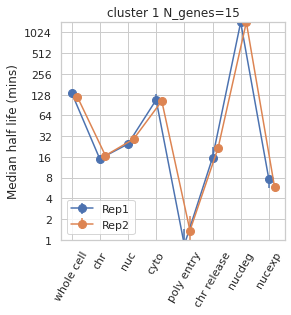

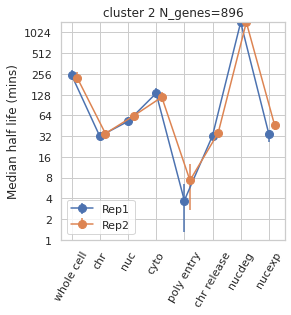

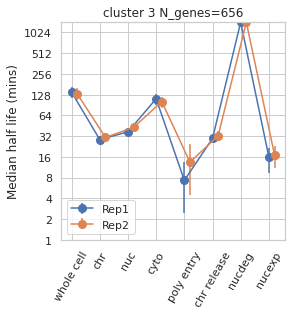

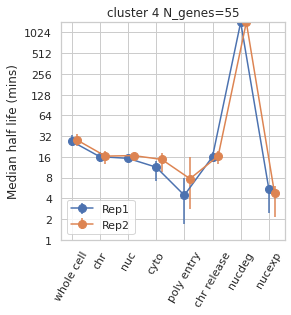

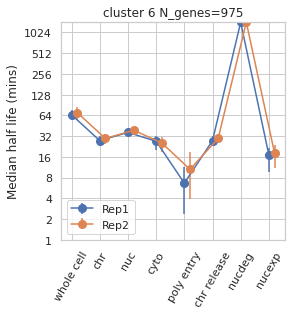

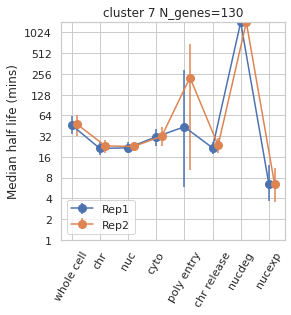

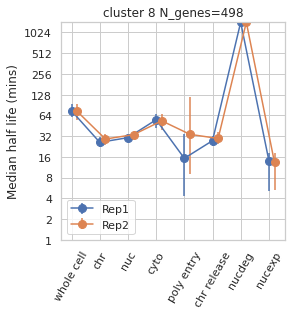

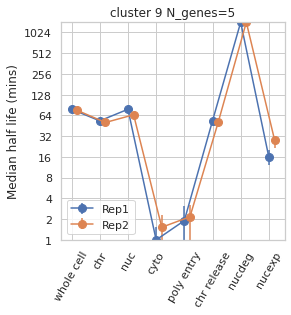

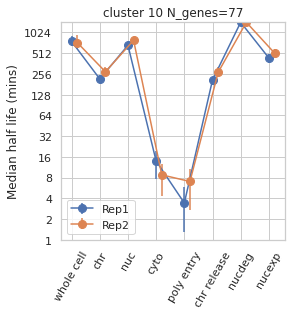

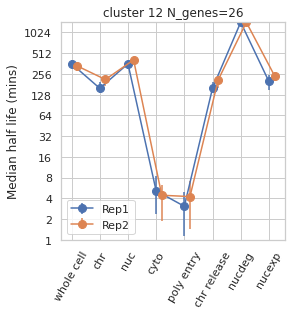

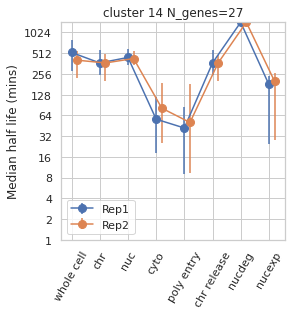

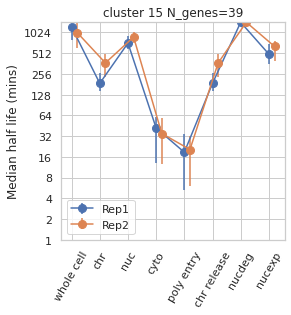

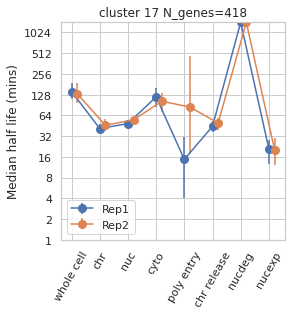

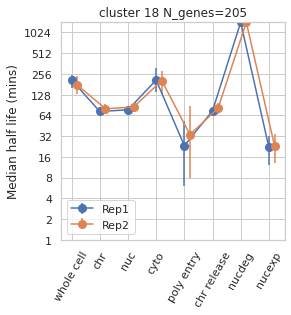

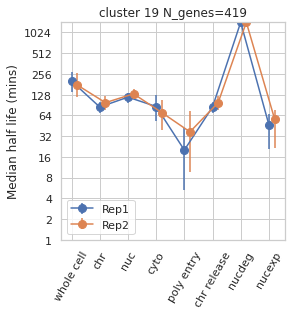

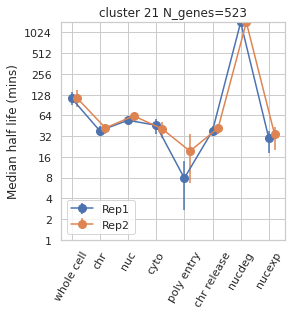

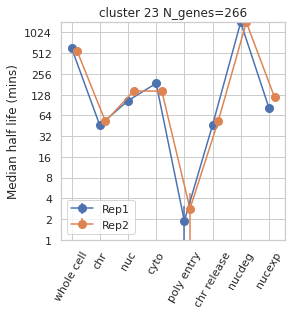

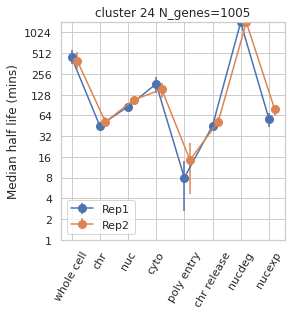

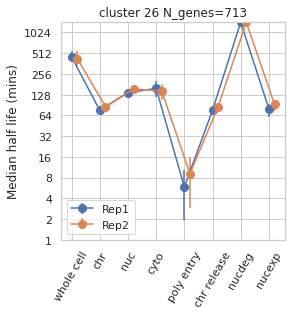

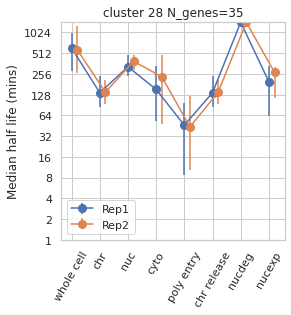

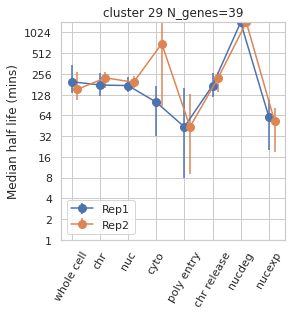

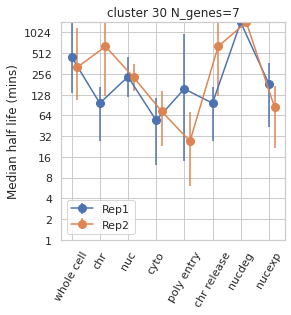

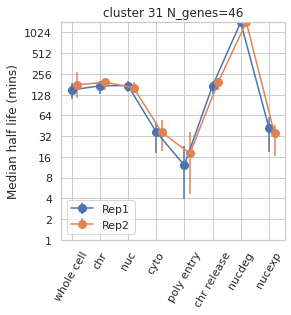

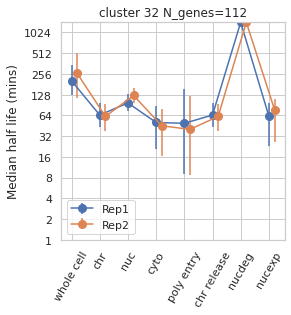

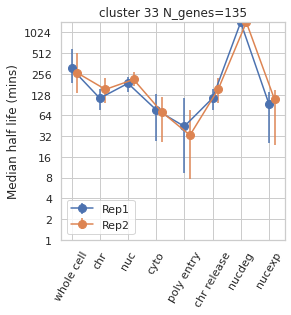

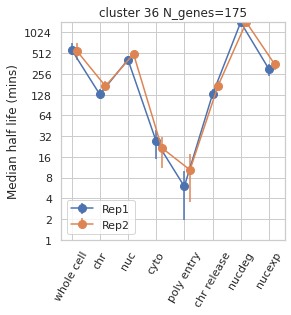

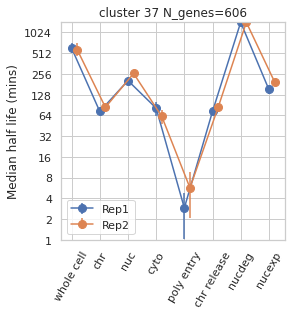

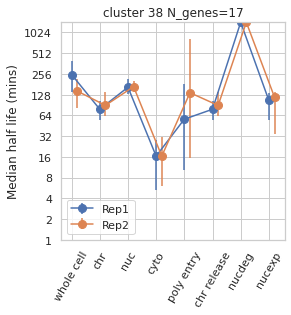

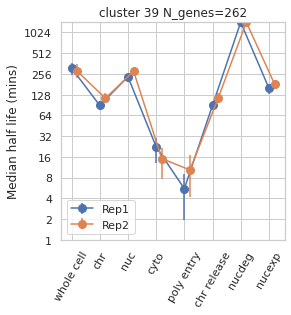

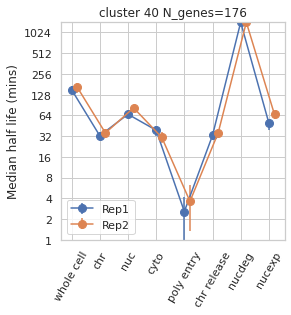

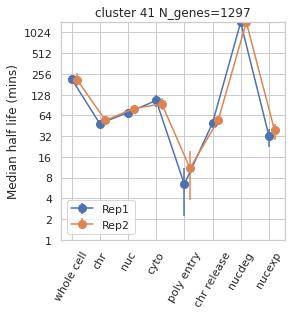

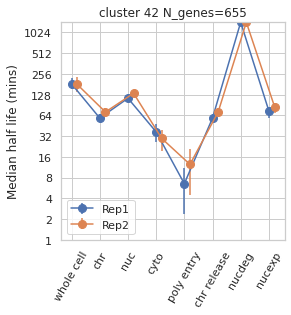

In [39]:
x_clust = np.arange(len(Timescales_order))#[:idx_add]))  #the label locations

for i in range(1,(N_clust+1)):
    if i in ok_clust:
        print('cluster: '+str(i)+' N_genes='+str(len(C[o][C[o]['Cluster']==i])))
        sns.set(style="whitegrid", color_codes=True,font_scale=1)
        f, ax = plt.subplots(figsize=(4, 4))   
        leg = []
        for j, rr in enumerate(org_red_reps[o]):
            ax.errorbar(x=x_clust+(0.2*j), y=centroid[str(i)+rr+'median'],
                        yerr=[centroid[str(i)+rr+'median'] - centroid[str(i)+rr+'ci_lo'],
                              centroid[str(i)+rr+'ci_hi'] - centroid[str(i)+rr+'median']], 
                        fmt='-o', ms=8) 
        plt.ylabel('Median %s(mins)' % rt.replace('_',' '))
        plt.xticks(x_clust, Timescales_v2_order, rotation = 60,) #[:idx_add]
        ax.set(yscale="log")
        plt.yticks([2**j for j in range(11)], [2**j for j in range(11)])
        plt.ylim([1, 24*60])
        plt.title('cluster '+str(i)+' N_genes='+str(len(C[o][C[o]['Cluster']==i])))
        ax.legend(['Rep1','Rep2'], loc='lower left')#, bbox_to_anchor=(1, 0.3))

        filename = 'Cluster_medians_' + o + '_' + str(i)
        #     plt.savefig(os.path.join(path, filename + '.pdf'), bbox_inches="tight", transparent=True)
        #     # plt.savefig(os.path.join(path, filename + '.png'), bbox_inches="tight", transparent=True)

        # rt = half_life_, metric = seuclidean, N_clust = 50, w Poly no MAP cap 1e-1, 24h

In [11]:
#nucleosome: #
#in heatmap cl 7 (= py 19) = histone variants = canonical RNA flow
#heatmap cl 11 (= py 14) = canonical histones = peculiar RNA flow

## Use R to visualize reordered and (ok) filtered clustered heatmap
run first the `Visualization of clusters` section to get the reproducible ok_clusters

https://anderfernandez.com/en/blog/how-to-program-with-python-and-r-in-the-same-jupyter-notebook/

hclust https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/hclust

sharing variables across R and Python in jupyter notebook: https://stackoverflow.com/questions/55841165/share-variables-between-r-and-python-in-jupyternotebook

In [40]:
%load_ext rpy2.ipython

INFO: [2024-02-09 14:25:45] rpy2.situation - cffi mode is CFFI_MODE.ANY
INFO: [2024-02-09 14:25:45] rpy2.situation - R home found: /n/app/R/4.1.1/lib64/R
INFO: [2024-02-09 14:25:46] rpy2.situation - R library path: /n/app/R/4.1.1/lib64/R/lib:/n/app/pcre2/10.34/lib:/n/app/cairo/1.14.6/lib:/n/app/tiff/4.0.7/lib:/n/app/jpeg/9b/lib:/n/app/openblas/0.2.19/lib:/n/app/libpng/1.6.26/lib:/n/app/xz/5.2.3/lib:/n/app/gsl/2.3/lib:/n/app/hdf5/1.10.1/lib:/n/app/boost/1.62.0/lib/:/n/app/pango/1.40.3/lib:/n/app/boost/1.62.0/lib:/n/app/java/jdk-1.8u112/jre/lib/amd64/server:/n/app/R/4.1.1/lib64/R/lib:/n/app/R/4.1.1/lib64:/n/app/pcre2/10.34/lib:/n/app/pango/1.40.3/lib:/n/app/cairo/1.14.6/lib:/n/app/harfbuzz/1.3.4/lib:/n/app/fontconfig/2.12.1/lib:/n/app/libffi/3.2.1/lib64:/n/app/libffi/3.2.1/lib:/n/app/freetype/2.7/lib:/n/app/libxml2/2.9.4/lib:/n/app/glib/2.50.2/lib:/n/app/hdf5/1.10.1/lib:/n/app/gsl/2.3/lib:/n/app/boost/1.62.0/lib:/n/app/xz/5.2.3/lib:/n/app/pixman/0.34.0/lib:/n/app/tiff/4.0.7/lib:/n/app/li

In [41]:
%%R
library(pheatmap)
library(ggplot2)
library(RColorBrewer)

In [42]:
%R -i path
%R -i rt
%R -i o
%R -i N_clust
%R -i N_ok_clust

In [43]:
o = 'h'

#dr: dataframe used for clustering in R and for reordering dendogram
dr = copy.deepcopy(C[o])
%R cc <- c()
for c in clust_cols[o]:
    dr['s'+c] = np.log(dr[c])
    dr['s'+c] = dr['s'+c] / dr['s'+c].std()
    %R -i c
    %R cc <- append(cc, paste0('s',c))

#filter for ok clustered genes:    
for i in C[o]['Cluster'].unique():
    cid = C[o][C[o]['Cluster']==i].index
    if i not in ok_clust:
        dr.drop(index=cid, inplace=True)
        
#get weights for reordering of dendogram based on short to long half lives
ot1 = OUT_TYPES[1]
for ts in Timescales_order[:idx_add]:
    dr[ts+ot1] = 0
    for rr in org_red_reps[o]:
        dr[ts+ot1] += dr[rr+'.'+ts+ot1]
    dr[ts+ot1] = dr[ts+ot1] / len(org_red_reps[o])

#sort by short to long half lives for whole cell, then chrom etc
sort_order = [ts+ot1 for ts in Timescales_order[:idx_add]]
sort_ascent = [True for ts in Timescales_order[:idx_add]]
dr.sort_values(by=sort_order, ascending=sort_ascent, inplace=True)
# #append dendogram reorder weights: current sorted ranking
dr['dend_weight'] = pd.DataFrame(range(1,len(dr)+1), columns=['dend_weight'], index=dr.index)
dr.sort_index(inplace=True)#sort back to original

for ke in dr.keys():
    if len(dr[dr[ke].isna()]) > 0:
#         logger.info(ke)
        dr.drop(ke, axis=1, inplace=True)
%R -i dr ##IN THE PAST GAVE AN ERROR bc NA values
   
# #get dplot, the dataframe for heatmap visualization in R: with log(half lives) 
# dplot = pd.DataFrame(index=C[o].index)
# %R vc <- c() #vis_cols in R
# for c in vis_cols[o]:
#     dplot[c] = np.log(C[o][c])
#     %R vc <- append(vc, c)

#get dplot, the dataframe for heatmap visualization in R: with log(half lives) 
dplot_clust = pd.DataFrame(index=C[o].index)
%R clc <- c() #clust_cols in R
for c in clust_cols[o]:
    dplot_clust[c] = np.log(C[o][c])
    %R clc <- append(clc, c)
    
dplot_deriv = pd.DataFrame(index=C[o].index)    
%R dec <- c() #deriv_cols in R
for c in deriv_cols[o]:
    dplot_deriv[c] = np.log(C[o][c])
    %R dec <- append(dec, c)
    
#filter for ok clustered genes:     
for i in C[o]['Cluster'].unique():
    cid = C[o][C[o]['Cluster']==i].index
    if i not in ok_clust:
#         dplot.drop(index=cid, inplace=True)
        dplot_clust.drop(index=cid, inplace=True)
        dplot_deriv.drop(index=cid, inplace=True)
    
# %R -i dplot
%R -i dplot_clust
%R -i dplot_deriv

### R hierarchical clustering with reordering

In [44]:
%%R
#get hierarchical clustering
dm = as.matrix(dr[cc]) #it is just a matrix, already checked.
hc <- hclust(dist(dm, method = "euclidean"), method = "complete")

#reorder dendogram 
dend = reorder(as.dendrogram(hc), wts = dr$dend_weight, agglo.FUN = mean)#sum instead of mean does not work
hc_order = as.hclust(dend)

In [19]:
# %%R
# plot(hc) #plots a dendrogram: for visual check

In [ ]:
# %%R
# plot(hc_order)

## R pheatmap visualization

pheatmap https://www.rdocumentation.org/packages/pheatmap/versions/1.0.12/topics/pheatmap

customize the visualization:
https://stackoverflow.com/questions/41628450/r-pheatmap-change-annotation-colors-and-prevent-graphics-window-from-popping-up

retrieve cluster information from dendogram https://www.biostars.org/p/86563/  

Color palettes
https://colorspace.r-forge.r-project.org/articles/hcl_palettes.html

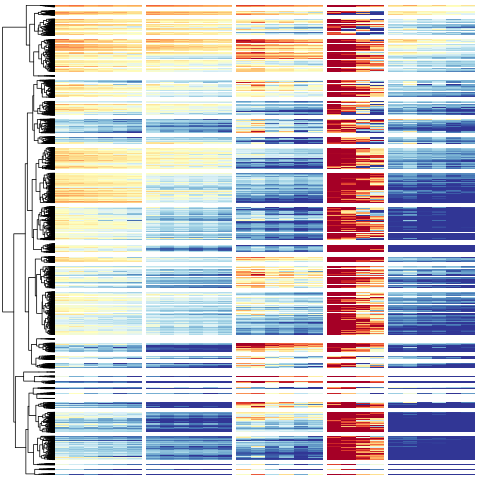

In [45]:
%%R

# Set colorscale: the minimum, the maximum, and the increasing steps (0.04) for the color scale
hlcol_min = 5
hlcol_max = 300
breaksList = seq(log(hlcol_min), log(hlcol_max), by = 0.04)
# Cluster annotation colormap
anno_cmap = colorRampPalette(grDevices::rainbow(N_ok_clust)) 
anno_colors <- anno_cmap(N_ok_clust)
names(anno_colors) <- unique(dr$Cluster)
anno_colors <- list(Cluster=anno_colors)

filename = paste0('Cluster_R_',rt,o,'.pdf')

#plot final heatmap
ph <- pheatmap(dplot_clust, 
         cluster_rows = hc_order, 
         cluster_cols = FALSE,
         color = colorRampPalette(brewer.pal(n = 11, name = 'RdYlBu'))(length(breaksList)),
         breaks = breaksList,
         border_color = NA,
         show_rownames = FALSE,
         show_colnames = FALSE,
#          annotation_row = dr['Cluster'],#uncomment for colored cluster column
#          annotation_colors = anno_colors,#uncomment for colored cluster column
         annotation_names_row = FALSE,
#          gaps_row=c(),#does not work when rows are clustered: instead use cutree_rows
         gaps_col=c(6,12,18,22),#c(6,12,18,24,30,36)#
         cutree_rows = N_ok_clust,#gives spaces between clusters
         annotation_legend = FALSE,
         legend=FALSE,#####Set to TRUE for legend
         legend_breaks = c(log(hlcol_min), log(7.5), log(15), log(30), log(60), 
                           log(120), log(240), log(hlcol_max)),
         legend_labels = c(hlcol_min, 7.5, 15, 30, 60, 120, 240, hlcol_max),
#          row_split = 2,# does not work
#          cellheight = 6,#autoscale is much better...
#          cellwidth = 20,#not used
#          fontsize_col = 6,#not used
#          main="Genes clustered by RNA flow half lives",#title, not used
               
#          filename = paste0(path,"/",filename), #############################   UNCOMMENT TO SAVE AS PDF #
         width = 6, height = 20)#does not work in jupyter visualization, only for pdf


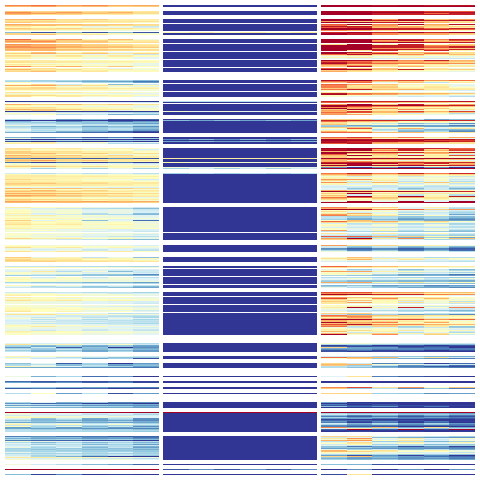

In [46]:
%%R

filename = paste0('Cluster_R_',rt,o,'_derived_rates.pdf')

#plot final heatmap
ph <- pheatmap(dplot_deriv, 
         cluster_rows = hc_order,
         cluster_cols = FALSE,
         color = colorRampPalette(brewer.pal(n = 11, name = 'RdYlBu'))(length(breaksList)),
         breaks = breaksList,
         border_color = NA,
         show_rownames = FALSE,
         show_colnames = FALSE,
         annotation_names_row = FALSE,
         gaps_col=c(6,12),
         treeheight_row = 0,
         cutree_rows = N_ok_clust,#gives spaces between clusters
         annotation_legend = FALSE,
         legend=FALSE,#####Set to TRUE for legend
               
#          filename = paste0(path,"/",filename), #############################   UNCOMMENT TO SAVE AS PDF #
         width = 3, height = 20)#does not work in jupyter visualization, only for pdf


## Get clustering numbers from R into Python

In [47]:
%%R
#get the R cluster numbers for all gene indexes in original order
orcl <- cutree(hc_order, k=N_ok_clust)

# add the R cluster numbers to your data
dr_fromR <- cbind(dr, ClusterR=orcl)

#reorder data to match the order in the heatmap:
dr_fromR <- dr_fromR[hc_order$order,]

#get heatmap color map to Python
anno_colors <- anno_cmap(N_ok_clust)

In [48]:
# examine the R cluster numbers by order in the R heatmap
%R clusterR_order_heatmap = unique(orcl[hc_order$order])

#pass it to Python
%R -o clusterR_order_heatmap 
%R -o dr_fromR 
%R -o anno_colors

In [49]:
map_cl_R2Py = dict()
map_cl_Py2R = dict()
map_cl_R2Heatmaprank = dict()

for i, clR in enumerate(dr_fromR['ClusterR'].unique()):
    clPy = dr_fromR['Cluster'].unique()[i]
    map_cl_R2Py[clR] = clPy
    map_cl_Py2R[clPy] = clR
    map_cl_R2Heatmaprank[clR] = i+1

In [50]:
for cl in range(N_clust):
    if cl in map_cl_Py2R.keys():
        logger.info(['py:',cl,
          'R cluster:', map_cl_Py2R[cl], 
          'rank heatmap:', clusterR_order_heatmap.tolist().index(map_cl_Py2R[cl])+1 ])

INFO: [2024-02-09 14:26:46] Function - ['py:', 1, 'R cluster:', 29, 'rank heatmap:', 5]
INFO: [2024-02-09 14:26:46] Function - ['py:', 2, 'R cluster:', 15, 'rank heatmap:', 11]
INFO: [2024-02-09 14:26:46] Function - ['py:', 3, 'R cluster:', 16, 'rank heatmap:', 10]
INFO: [2024-02-09 14:26:46] Function - ['py:', 4, 'R cluster:', 23, 'rank heatmap:', 1]
INFO: [2024-02-09 14:26:46] Function - ['py:', 6, 'R cluster:', 12, 'rank heatmap:', 4]
INFO: [2024-02-09 14:26:46] Function - ['py:', 7, 'R cluster:', 19, 'rank heatmap:', 2]
INFO: [2024-02-09 14:26:46] Function - ['py:', 8, 'R cluster:', 2, 'rank heatmap:', 3]
INFO: [2024-02-09 14:26:46] Function - ['py:', 9, 'R cluster:', 32, 'rank heatmap:', 21]
INFO: [2024-02-09 14:26:46] Function - ['py:', 10, 'R cluster:', 30, 'rank heatmap:', 23]
INFO: [2024-02-09 14:26:46] Function - ['py:', 12, 'R cluster:', 28, 'rank heatmap:', 22]
INFO: [2024-02-09 14:26:46] Function - ['py:', 14, 'R cluster:', 20, 'rank heatmap:', 31]
INFO: [2024-02-09 14:26:

### Write hierarchically clustered data to file

In [51]:
dr_fromR['Cluster_heatmap'] = dr_fromR['ClusterR'].map(map_cl_R2Heatmaprank)
dr_fromR.drop(['Cluster','ClusterR'], axis=1, inplace=True)

filename = 'Cluster_R_'+rt+o+'.tsv'
# dr_fromR.to_csv(os.path.join(path, filename), sep='\t')

### Manuscript statistics

In [82]:
cl_py = 41 #Largest cluster
cl_heat = clusterR_order_heatmap.tolist().index(map_cl_Py2R[cl_py])+1
logger.info('heatmap cluster %s' % cl_heat)
N_largecl_genes = len(dr_fromR[dr_fromR['Cluster_heatmap']==cl_heat])
N_notlargecl_genes =len(dr_fromR)-len(dr_fromR[dr_fromR['Cluster_heatmap']==cl_heat])
logger.info(' gene cluster %d: %d, other genes: %d' % (cl_heat, N_largecl_genes, N_notlargecl_genes))
rr = 'T'
logger.info(centroid[str(cl_py)+rr+'median'][0])#whole cell: [0]
rr = 'U'
logger.info(centroid[str(cl_py)+rr+'median'][0])

rr = 'T'
logger.info(centroid[str(cl_py)+rr+'median'])#whole cell: [0]
rr = 'U'
logger.info(centroid[str(cl_py)+rr+'median'])

INFO: [2024-02-02 13:36:32] Function - heatmap cluster 16
INFO: [2024-02-02 13:36:32] Function -  gene cluster 16: 1297, other genes: 9213
INFO: [2024-02-02 13:36:32] Function - 216.43124392864502
INFO: [2024-02-02 13:36:32] Function - 208.5950217584021
INFO: [2024-02-02 13:36:32] Function - 0     216.431244
1      48.603921
2      70.279954
3     105.440545
4       6.394262
5      49.508448
6    1440.000000
7      32.396279
Name: 41Tmedian, dtype: float64
INFO: [2024-02-02 13:36:32] Function - 0     208.595022
1      54.289939
2      79.962713
3      94.397305
4      10.914973
5      54.289939
6    1440.000000
7      38.956077
Name: 41Umedian, dtype: float64


In [83]:
(216.43124392864502+208.5950217584021)/2 #average of median whole cell

212.51313284352358

In [163]:
cl_py = 4#fast flow rank 1 cluster R heatmap: 23 (py:4)
cl_heat = clusterR_order_heatmap.tolist().index(map_cl_Py2R[cl_py])+1
logger.info('heatmap cluster %s' % cl_heat)
N_largecl_genes = len(dr_fromR[dr_fromR['Cluster_heatmap']==cl_heat])
N_notlargecl_genes =len(dr_fromR)-len(dr_fromR[dr_fromR['Cluster_heatmap']==cl_heat])
logger.info(' gene cluster %d: %d, other genes: %d' % (cl_heat, N_largecl_genes, N_notlargecl_genes))
rr = 'T'
logger.info(centroid[str(cl_py)+rr+'median'][0])#whole cell: [0]
rr = 'U'
logger.info(centroid[str(cl_py)+rr+'median'][0])

rr = 'T'
logger.info(centroid[str(cl_py)+rr+'median'])#whole cell: [0]
rr = 'U'
logger.info(centroid[str(cl_py)+rr+'median'])

INFO: [2024-02-02 14:48:43] Function - heatmap cluster 1
INFO: [2024-02-02 14:48:43] Function -  gene cluster 1: 55, other genes: 10455
INFO: [2024-02-02 14:48:43] Function - 26.94108304758367
INFO: [2024-02-02 14:48:43] Function - 27.953170059479607
INFO: [2024-02-02 14:48:43] Function - 0      26.941083
1      16.076475
2      15.211316
3      11.325012
4       4.422117
5      16.076475
6    1440.000000
7       5.416495
Name: 4Tmedian, dtype: float64
INFO: [2024-02-02 14:48:43] Function - 0      27.953170
1      16.375661
2      16.680415
3      14.660568
4       7.689011
5      16.375661
6    1440.000000
7       4.760607
Name: 4Umedian, dtype: float64


In [164]:
(26.94108304758367 +  27.953170059479607)/2

27.44712655353164

In [85]:
cl_py = 1# canonical histones #cluster not yet updated
cl_heat = clusterR_order_heatmap.tolist().index(map_cl_Py2R[cl_py])+1
logger.info('heatmap cluster %s' % cl_heat)
N_largecl_genes = len(dr_fromR[dr_fromR['Cluster_heatmap']==cl_heat])
N_notlargecl_genes =len(dr_fromR)-len(dr_fromR[dr_fromR['Cluster_heatmap']==cl_heat])
logger.info(' gene cluster %d: %d, other genes: %d' % (cl_heat, N_largecl_genes, N_notlargecl_genes))
rr = 'T'
logger.info(centroid[str(cl_py)+rr+'median'][0])#whole cell: [0]
rr = 'U'
logger.info(centroid[str(cl_py)+rr+'median'][0])

rr = 'T'
logger.info(centroid[str(cl_py)+rr+'median'])#whole cell: [0]
rr = 'U'
logger.info(centroid[str(cl_py)+rr+'median'])

INFO: [2024-02-09 15:06:12] Function - heatmap cluster 5
INFO: [2024-02-09 15:06:12] Function -  gene cluster 5: 15, other genes: 10495
INFO: [2024-02-09 15:06:12] Function - 136.49594679869242
INFO: [2024-02-09 15:06:12] Function - 119.96752502380936
INFO: [2024-02-09 15:06:12] Function - 0     136.495947
1      14.933403
2      24.568295
3     107.402812
4       0.841220
5      15.494402
6    1440.000000
7       7.548532
Name: 1Tmedian, dtype: float64
INFO: [2024-02-09 15:06:12] Function - 0     119.967525
1      16.680415
2      29.003278
3     103.514130
4       1.358682
5      21.665811
6    1440.000000
7       5.890042
Name: 1Umedian, dtype: float64


In [87]:
cl_py = 40# variant histones  #cluster not yet updated
cl_heat = clusterR_order_heatmap.tolist().index(map_cl_Py2R[cl_py])+1
logger.info('heatmap cluster %s' % cl_heat)
N_largecl_genes = len(dr_fromR[dr_fromR['Cluster_heatmap']==cl_heat])
N_notlargecl_genes =len(dr_fromR)-len(dr_fromR[dr_fromR['Cluster_heatmap']==cl_heat])
logger.info(' gene cluster %d: %d, other genes: %d' % (cl_heat, N_largecl_genes, N_notlargecl_genes))
rr = 'T'
logger.info(centroid[str(cl_py)+rr+'median'][0])#whole cell: [0]
rr = 'U'
logger.info(centroid[str(cl_py)+rr+'median'][0])

rr = 'T'
logger.info(centroid[str(cl_py)+rr+'median'])#whole cell: [0]
rr = 'U'
logger.info(centroid[str(cl_py)+rr+'median'])

INFO: [2024-02-09 15:06:50] Function - heatmap cluster 14
INFO: [2024-02-09 15:06:50] Function -  gene cluster 14: 176, other genes: 10334
INFO: [2024-02-09 15:06:50] Function - 151.07140097493172
INFO: [2024-02-09 15:06:50] Function - 164.13448446970352
INFO: [2024-02-09 15:06:50] Function - 0     151.071401
1      32.396279
2      66.497825
3      38.956077
4       2.566921
5      32.697729
6    1440.000000
7      49.508448
Name: 40Tmedian, dtype: float64
INFO: [2024-02-09 15:06:50] Function - 0     164.134484
1      35.525089
2      82.208740
3      30.652867
4       3.610291
5      35.525089
6    1440.000000
7      65.890362
Name: 40Umedian, dtype: float64


In [88]:
Timescales_order
# for cc in clust_cols[o]:
#     logger.info('%s %f' % (cc, dr_fromR[cc].median()))

['half_life_whole_cell',
 'half_life_chr',
 'half_life_nuc',
 'half_life_cyto',
 'half_life_poly_entry',
 'half_life_chr_release',
 'half_life_nucdeg',
 'half_life_nucexp']

In [52]:
#RPG clusters
cl_py = 2# 
cl_heat = clusterR_order_heatmap.tolist().index(map_cl_Py2R[cl_py])+1
logger.info('heatmap cluster %s' % cl_heat)
N_largecl_genes = len(dr_fromR[dr_fromR['Cluster_heatmap']==cl_heat])
N_notlargecl_genes =len(dr_fromR)-len(dr_fromR[dr_fromR['Cluster_heatmap']==cl_heat])
logger.info(' gene cluster %d: %d, other genes: %d' % (cl_heat, N_largecl_genes, N_notlargecl_genes))
rr = 'T'
logger.info(centroid[str(cl_py)+rr+'median'][0])#whole cell: [0]
rr = 'U'
logger.info(centroid[str(cl_py)+rr+'median'][0])

rr = 'T'
logger.info(centroid[str(cl_py)+rr+'median'])#whole cell: [0]
rr = 'U'
logger.info(centroid[str(cl_py)+rr+'median'])

INFO: [2024-02-09 14:27:57] Function - heatmap cluster 11
INFO: [2024-02-09 14:27:57] Function -  gene cluster 11: 896, other genes: 9614
INFO: [2024-02-09 14:27:57] Function - 246.24987096296303
INFO: [2024-02-09 14:27:57] Function - 224.5618469397332
INFO: [2024-02-09 14:27:57] Function - 0     246.249871
1      31.804394
2      52.324289
3     134.002144
4       3.711698
5      32.396279
6    1440.000000
7      34.238849
Name: 2Tmedian, dtype: float64
INFO: [2024-02-09 14:27:57] Function - 0     224.561847
1      34.876040
2      62.919233
3     117.775699
4       7.275226
5      35.525089
6    1440.000000
7      46.844142
Name: 2Umedian, dtype: float64


In [53]:
#RPG clusters
cl_py = 23# 
cl_heat = clusterR_order_heatmap.tolist().index(map_cl_Py2R[cl_py])+1
logger.info('heatmap cluster %s' % cl_heat)
N_largecl_genes = len(dr_fromR[dr_fromR['Cluster_heatmap']==cl_heat])
N_notlargecl_genes =len(dr_fromR)-len(dr_fromR[dr_fromR['Cluster_heatmap']==cl_heat])
logger.info(' gene cluster %d: %d, other genes: %d' % (cl_heat, N_largecl_genes, N_notlargecl_genes))
rr = 'T'
logger.info(centroid[str(cl_py)+rr+'median'][0])#whole cell: [0]
rr = 'U'
logger.info(centroid[str(cl_py)+rr+'median'][0])

rr = 'T'
logger.info(centroid[str(cl_py)+rr+'median'])#whole cell: [0]
rr = 'U'
logger.info(centroid[str(cl_py)+rr+'median'])

INFO: [2024-02-09 14:28:01] Function - heatmap cluster 13
INFO: [2024-02-09 14:28:01] Function -  gene cluster 13: 266, other genes: 10244
INFO: [2024-02-09 14:28:01] Function - 607.8107878699168
INFO: [2024-02-09 14:28:01] Function - 544.1521581281097
INFO: [2024-02-09 14:28:01] Function - 0     607.810788
1      45.988292
2     104.477338
3     186.747971
4       1.876188
5      45.988292
6    1440.000000
7      82.966647
Name: 23Tmedian, dtype: float64
INFO: [2024-02-09 14:28:01] Function - 0     544.152158
1      52.324289
2     144.259286
3     144.259286
4       2.814832
5      52.324289
6    1440.000000
7     117.775699
Name: 23Umedian, dtype: float64


In [54]:
#RPG clusters
cl_py = 37# 
cl_heat = clusterR_order_heatmap.tolist().index(map_cl_Py2R[cl_py])+1
logger.info('heatmap cluster %s' % cl_heat)
N_largecl_genes = len(dr_fromR[dr_fromR['Cluster_heatmap']==cl_heat])
N_notlargecl_genes =len(dr_fromR)-len(dr_fromR[dr_fromR['Cluster_heatmap']==cl_heat])
logger.info(' gene cluster %d: %d, other genes: %d' % (cl_heat, N_largecl_genes, N_notlargecl_genes))
rr = 'T'
logger.info(centroid[str(cl_py)+rr+'median'][0])#whole cell: [0]
rr = 'U'
logger.info(centroid[str(cl_py)+rr+'median'][0])

rr = 'T'
logger.info(centroid[str(cl_py)+rr+'median'])#whole cell: [0]
rr = 'U'
logger.info(centroid[str(cl_py)+rr+'median'])

INFO: [2024-02-09 14:28:03] Function - heatmap cluster 28
INFO: [2024-02-09 14:28:03] Function -  gene cluster 28: 606, other genes: 9904
INFO: [2024-02-09 14:28:03] Function - 607.8107878699168
INFO: [2024-02-09 14:28:03] Function - 575.1013405939531
INFO: [2024-02-09 14:28:03] Function - 0     607.810788
1      72.920138
2     204.783957
3      81.450833
4       2.893651
5      72.920138
6    1440.000000
7     152.464173
Name: 37Tmedian, dtype: float64
INFO: [2024-02-09 14:28:03] Function - 0     575.101341
1      83.738659
2     260.255572
3      61.769688
4       5.672269
5      83.738659
6    1440.000000
7     197.369443
Name: 37Umedian, dtype: float64


### Scraps

In [ ]:
#NOT YET UPDATED
#nucleosome: #
#in heatmap cl 7 = py  
#heatmap cl 5 = py 1

In [210]:
dr_fromR[dr_fromR['Cluster_heatmap']==5]

Gene   Symbol  T.half_life_chr.Mean  T.half_life_chr.MAP  \
15569  ENSG00000203852    H3C15              5.115914             5.125005   
17072  ENSG00000259494   MRPL46             11.588810            11.750455   
9771   ENSG00000160818  GPATCH4             14.832319            14.933403   
602    ENSG00000048162    NOP16              7.716924             7.832105   
17392  ENSG00000270882    H4C14             15.508464            15.494402   
17674  ENSG00000278828    H3C10             14.746186            14.933403   
17487  ENSG00000273802    H2BC8             20.144828            20.057967   
17604  ENSG00000276966     H4C5             11.572123            11.535772   
5462   ENSG00000126749     EMG1             23.283856            23.246147   
9812   ENSG00000161179     YDJC             20.185685            20.057967   
9836   ENSG00000161547    SRSF2             21.642981            21.593297   
4235   ENSG00000115875    SRSF7             19.653240            19.691505   
6793   ENSG00000136527    TRA2B             17.289331            17.307042   
16368  ENSG00000229117    RPL41             11.427249            11.535772   
16742  ENSG00000249222  ATP5MGL              0.550459             0.550459   

       T.half_life_chr.0.025.quantile  T.half_life_chr.0.975.quantile  \
15569                        4.504414                        5.831099   
17072                       10.327582                       13.125104   
9771                        13.369364                       16.375661   
602                          6.513260                        9.245930   
17392                       14.392717                       16.680415   
17674                       13.125104                       16.680415   
17487                       18.631803                       21.995152   
17604                       10.138895                       13.369364   
5462                        21.593297                       25.025515   
9812                        18.978544                       21.593297   
9836                        20.431250                       22.404485   
4235                        18.978544                       20.431250   
6793                        16.375661                       17.957211   
16368                        9.953656                       13.125104   
16742                       13.369364                       36.859648   

       T.half_life_nuc.Mean  T.half_life_nuc.MAP  \
15569             15.416740            15.494402   
17072             14.711198            14.660568   
9771              19.954344            20.057967   
602               20.626431            20.431250   
17392             25.965640            25.965640   
17674             25.372614            25.491244   
17487             24.568295            24.568295   
17604             36.089701            36.186217   
5462              28.073416            27.953170   
9812              24.570115            24.568295   
9836              27.676884            27.953170   
4235            1440.000000            25.491244   
6793              19.100408            18.978544   
16368             20.566671            20.431250   
16742             50.856909            52.324289   

       T.half_life_nuc.0.025.quantile  T.half_life_nuc.0.975.quantile  \
15569                       14.660568                       16.375661   
17072                       13.369364                       16.076475   
9771                        18.631803                       21.198784   
602                         18.978544                       22.821437   
17392                       25.491244                       26.448865   
17674                       23.678762                       26.941083   
17487                       24.119428                       25.025515   
17604                       34.238849                       38.244343   
5462                        26.448865                       29.543034   
9812                        23.678762

# GO enrichment analysis with GOAtools

source: https://github.com/tanghaibao/goatools/blob/main/notebooks/goea_nbt3102.ipynb

#in terminal in `O2/GO/bseq` folder only once:
#wget http://purl.obolibrary.org/obo/go.obo
#wget ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz

In [84]:
#Load GO OBO and (human) gene annotations
path_go_obo = os.path.join('/n','groups','churchman','ri23','GO','bseq')
filename = 'go.obo'
go_dag = GODag(os.path.join(path_go_obo,filename))

#load human annotation files
filename = 'gene2go'
filename_gene2go = download_ncbi_associations(gene2go=os.path.join(path_go_obo,filename))

objanno = dict()
ns2assoc = dict()
for o in organisms: 
    logger.info(o)
    # Read NCBI's gene2go. Store annotations in a list of namedtuples
    objanno[o] = Gene2GoReader(filename_gene2go, taxids=[org_id_map[o]])

    # Get namespace2association where:
    #    namespace is:
    #        BP: biological_process               
    #        MF: molecular_function
    #        CC: cellular_component
    #    assocation is a dict:
    #        key: NCBI (Entrez) GeneID
    #        value: A set of GO IDs associated with that gene

    ns2assoc[o] = objanno[o].get_ns2assc()
    
    for nspc, id2gos in ns2assoc[o].items():
        logger.info("{NS} {N:,} annotated genes".format(NS=nspc, N=len(id2gos)))

INFO: [2024-02-02 13:46:58] Function - m


/n/groups/churchman/ri23/GO/bseq/go.obo: fmt(1.2) rel(2021-12-15) 47,157 GO Terms
  EXISTS: /n/groups/churchman/ri23/GO/bseq/gene2go
HMS:0:00:06.764503 419,975 annotations, 29,776 genes, 18,911 GOs, 1 taxids READ: /n/groups/churchman/ri23/GO/bseq/gene2go 


INFO: [2024-02-02 13:47:05] Function - CC 19,352 annotated genes
INFO: [2024-02-02 13:47:05] Function - MF 17,429 annotated genes
INFO: [2024-02-02 13:47:05] Function - BP 18,633 annotated genes
INFO: [2024-02-02 13:47:05] Function - h


HMS:0:00:06.179187 335,439 annotations, 20,702 genes, 18,739 GOs, 1 taxids READ: /n/groups/churchman/ri23/GO/bseq/gene2go 


INFO: [2024-02-02 13:47:12] Function - CC 19,473 annotated genes
INFO: [2024-02-02 13:47:12] Function - MF 18,227 annotated genes
INFO: [2024-02-02 13:47:12] Function - BP 18,569 annotated genes


In [85]:
###get gene_mapper file so that you can map ENSG to Entrez gene IDs used for GO enrichment analysis
def get_hgnc(resource_folder):
    fname = os.path.join(resource_folder, 'hgnc_entries.tsv')
    if not os.path.exists(fname):
        # Select relevant columns and parameters
        cols = ['gd_hgnc_id', 'gd_app_sym', 'gd_app_name', 'gd_prev_sym',
                'gd_status', 'md_eg_id', 'md_prot_id', 'md_mgd_id',
                'md_rgd_id', 'gd_pub_ensembl_id']
        statuses = ['Approved', 'Entry%20Withdrawn']
        params = {
            'hgnc_dbtag': 'on',
            'order_by': 'gd_app_sym_sort',
            'format': 'text',
            'submit': 'submit'
        }

        # Construct a download URL from the above parameters
        url = 'https://www.genenames.org/cgi-bin/download/custom?'
        url += '&'.join(['col=%s' % c for c in cols]) + '&'
        url += '&'.join(['status=%s' % s for s in statuses]) + '&'
        url += '&'.join(['%s=%s' % (k, v) for k, v in params.items()])

        # Save the download into a file
        urllib.request.urlretrieve(url, fname)
    return fname

gene_map = dict()

#Human
filename_hgnc = get_hgnc(path_go_obo)
gene_map['h'] = pd.read_csv(filename_hgnc, sep='\t')
col_map = {'HGNC ID': 'hgnc_id',
           'Approved symbol': 'Symbol',
           'Previous symbols': 'old_symbol',
           'NCBI Gene ID(supplied by NCBI)': 'entrez_id',
           'UniProt ID(supplied by UniProt)':'up_id',
           'Mouse genome database ID(supplied by MGI': 'mgi_id',
           'Rat genome database ID(supplied by RGD)': 'rgd_id',
           'Ensembl gene ID': 'ens_id'}
gene_map['h'].rename(mapper=col_map, axis=1, inplace=True) 

#Mouse
filename_hgnc = os.path.join('/n','groups','churchman','ri23','GO','bseq','Mouse_ens_entrez_map.csv')
gene_map['m'] = pd.read_csv(filename_hgnc, sep=',',dtype={'entrezgene_id': str})
col_map = {'ensembl_gene_id':'ens_id',
           'mgi_symbol':'Symbol',
           'entrezgene_id':'entrez_id'}
gene_map['m'].rename(mapper=col_map, axis=1, inplace=True) 
gene_map['m'] = gene_map['m'][~gene_map['m']['entrez_id'].isna()]

In [86]:
gene_map['m'].head()

ens_id Symbol       mgi_id entrez_id
0  ENSMUSG00000000001  Gnai3    MGI:95773     14679
1  ENSMUSG00000000003   Pbsn  MGI:1860484     54192
2  ENSMUSG00000000028  Cdc45  MGI:1338073     12544
3  ENSMUSG00000000031    H19    MGI:95891     14955
4  ENSMUSG00000000037  Scml2  MGI:1340042    107815

In [87]:
o = 'h'

#Get universe of genes (entrez_ids) for enrichment analysis
gene_universe = list(gene_map[o][gene_map[o]['ens_id'].isin(C[o]['Gene'])]['entrez_id'].astype(int))

alpha_fdr = 0.05 / N_ok_clust

#Initialize a GOEA object
goeaobj = GOEnrichmentStudyNS(gene_universe, # universe List of protein-coding genes
                              ns2assoc[o], #geneid/GO associations (from NCBI gene)
                              go_dag, # Ontologies
                              propagate_counts = True,#default True: parental GOannos are also annotations 
                              alpha = alpha_fdr, # default significance cut-off
                              methods = ['fdr_bh']) # default multiple test correction method


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a


4 GO IDs NOT FOUND IN ASSOCIATION: GO:0001207 GO:0033168 GO:0036404 GO:2001216


 90%  9,431 of 10,461 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 95%  9,902 of 10,461 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 94%  9,791 of 10,461 population items found in association


1 GO IDs NOT FOUND IN ASSOCIATION: GO:0031493


## Run enrichment analysis

'p_' means "pvalue". 'fdr_bh' is the multipletest method we are currently using.  
"e" in the "Enrichment" column means "enriched" - the concentration of GO term in the study group is significantly higher than those in the population.  
"p" stands for "purified" - significantly lower concentration of the GO term in the study group than in the population.
https://github.com/tanghaibao/goatools

To get the genes corresponding to an enriched GO term, see GOEnrichmentRecord object description:
https://github.com/tanghaibao/goatools/blob/main/goatools/go_enrichment.py

GOEnrichmentRecord.study_items = annotated genes in NCBI IDs

In [88]:
#Run enrichment analysis

goea_results_all = dict()

for cl_rank_heatmap, cl in enumerate(clusterR_order_heatmap):
    
    logger.info('rank %d cluster R heatmap: %d (py:%d)' % ((cl_rank_heatmap+1), cl, map_cl_R2Py[cl]))

    cluster_genes = C[o][C[o]['Cluster']==map_cl_R2Py[cl]]['Gene']
    logger.info('N_genes in cluster: %d' % len(cluster_genes))
    logger.info(list(gene_map[o][gene_map[o]['ens_id'].isin(cluster_genes)].sort_values(by='Symbol')['Symbol']))
    geneids_study = list(gene_map[o][gene_map[o]['ens_id'].isin(cluster_genes)]['entrez_id'].astype(int))

    goea_results_all[cl] = goeaobj.run_study(geneids_study)#, prt=None)

INFO: [2024-02-02 13:47:28] Function - rank 1 cluster R heatmap: 23 (py:4)
INFO: [2024-02-02 13:47:28] Function - N_genes in cluster: 55
INFO: [2024-02-02 13:47:28] Function - ['ARRDC3', 'BAMBI', 'CCDC174', 'CCNL1', 'CD69', 'CDKN1B', 'CISH', 'CITED2', 'CLK1', 'CSKMT', 'CXCL2', 'CXCL3', 'DUSP1', 'EGR1', 'EPC1', 'FBXO5', 'FOSL1', 'FRS2', 'GADD45A', 'H2AC18', 'HES1', 'ID1', 'IER3', 'JUNB', 'KLF10', 'KLF6', 'KLHL21', 'MED9', 'MTF1', 'MYC', 'MYLIP', 'NFKBIA', 'NFKBIZ', 'PPP1R15A', 'PPP1R3D', 'SERTAD3', 'SGK1', 'SNAI1', 'SOCS3', 'SPATA2', 'SPRY2', 'SPRY4', 'TGIF1', 'TIPARP', 'TXNIP', 'ZBTB9', 'ZC3H12A', 'ZFP36L1', 'ZFP36L2', 'ZNF367', 'ZNF436', 'ZNF526', 'ZNF57', 'ZNF574', 'ZSCAN12']



Run BP Gene Ontology Analysis: current study set of 55 IDs ... 95%     52 of     55 study items found in association
100%     55 of     55 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   1,923 GO terms are associated with     52 of     55 study items
  METHOD fdr_bh:
      45 GO terms found significant (< 0.0015625=alpha) ( 45 enriched +   0 purified): statsmodels fdr_bh
      51 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 55 IDs ...100%     55 of     55 study items found in association
100%     55 of     55 study items found in population(10461)
Calculating 1,788 uncorrected p-values using fisher_scipy_stats
   1,788 GO terms are associated with  9,902 of 10,461 population items
     137 GO terms are associated with     55 

INFO: [2024-02-02 13:47:40] Function - rank 2 cluster R heatmap: 19 (py:7)
INFO: [2024-02-02 13:47:40] Function - N_genes in cluster: 130
INFO: [2024-02-02 13:47:40] Function - ['ADAT3', 'ADM2', 'ARIH2OS', 'ARRDC4', 'ASTE1', 'ATP6V1FNB', 'B3GALT4', 'BORCS6', 'C11orf68', 'C15orf61', 'C20orf203', 'C2orf42', 'CCDC12', 'CDC37L1', 'CDC42EP2', 'CDKN2D', 'CFL2', 'CLK4', 'CYB561D1', 'DLX1', 'DNAJC30', 'DOK1', 'DUSP28', 'DYNLT2', 'EID2B', 'ENDOV', 'ETAA1', 'FAM214B', 'FOXA3', 'FRS3', 'GORAB', 'GVQW3', 'H2BC6', 'HARBI1', 'HAUS8', 'INKA1', 'IQCC', 'IRF1', 'KBTBD4', 'KCNJ14', 'LATS2', 'LCA5', 'LONRF1', 'LRCH1', 'LTO1', 'MAGEA2', 'MAPK7', 'MEX3C', 'MSX1', 'NR1D1', 'NR4A2', 'NUDT4B', 'OTX1', 'PARS2', 'PCGF1', 'PHAX', 'PIP4P1', 'PLEKHO1', 'PLK3', 'PPP1R3F', 'RBM48', 'RHOF', 'RHOV', 'RNF227', 'SIX4', 'SNX16', 'SPRYD4', 'SPSB2', 'SYBU', 'TBC1D10A', 'TBC1D20', 'THAP2', 'THAP3', 'TIGD6', 'TMEM186', 'TNRC6C', 'TP53', 'TRAF6', 'TYW5', 'UFSP1', 'USP27X', 'ZBTB10', 'ZBTB3', 'ZBTB45', 'ZC2HC1C', 'ZC3H10', 'ZE

   4,041 GO terms are associated with  9,791 of 10,461 population items
     221 GO terms are associated with     55 of     55 study items
  METHOD fdr_bh:
      11 GO terms found significant (< 0.0015625=alpha) ( 11 enriched +   0 purified): statsmodels fdr_bh
      21 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 129 IDs ... 84%    108 of    129 study items found in association
100%    129 of    129 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   1,757 GO terms are associated with    108 of    129 study items
  METHOD fdr_bh:
      15 GO terms found significant (< 0.0015625=alpha) ( 10 enriched +   5 purified): statsmodels fdr_bh
      66 study items associated with significant GO IDs (enriched)
      61 study items associate

INFO: [2024-02-02 13:47:52] Function - rank 3 cluster R heatmap: 2 (py:8)
INFO: [2024-02-02 13:47:52] Function - N_genes in cluster: 498
INFO: [2024-02-02 13:47:52] Function - ['ABHD5', 'ABHD8', 'ABT1', 'ACBD5', 'ACTN2', 'ACVR2A', 'ADM5', 'AFG1L', 'AGFG2', 'ALG2', 'ALKBH6', 'AMIGO2', 'ANKRA2', 'ANKRD49', 'ANKRD50', 'ANKRD9', 'AP5S1', 'APBA3', 'ARHGAP42', 'ARID4A', 'ARID5B', 'ARL14EP', 'ASB1', 'ASB7', 'ATF7IP2', 'ATG4D', 'ATXN7', 'ATXN7L2', 'AUNIP', 'B3GALT9', 'B4GALT7', 'BAK1', 'BBS1', 'BBS12', 'BCL10', 'BICRAL', 'BLZF1', 'BNIP2', 'BOD1', 'BRD1', 'BRIX1', 'BRMS1L', 'BTN2A1', 'C11orf21', 'C11orf71', 'C16orf87', 'C18orf25', 'C19orf44', 'C19orf73', 'C19orf81', 'C1orf109', 'C1orf131', 'C21orf58', 'C2CD2L', 'C3orf62', 'C5orf24', 'C6orf132', 'C7orf25', 'C9orf72', 'CA5B', 'CACNB3', 'CAPN10', 'CBARP', 'CBLB', 'CBLL1', 'CBWD3', 'CBX6', 'CCDC116', 'CCDC120', 'CCDC137', 'CCDC180', 'CCDC8', 'CCDC87', 'CDCA5', 'CDK9', 'CDPF1', 'CENPA', 'CEP68', 'CEP97', 'CHCHD5', 'CHP2', 'CHTOP', 'CKAP2L', 'CLDN15'

   4,041 GO terms are associated with  9,791 of 10,461 population items
     297 GO terms are associated with    122 of    129 study items
  METHOD fdr_bh:
      18 GO terms found significant (< 0.0015625=alpha) ( 18 enriched +   0 purified): statsmodels fdr_bh
      83 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 488 IDs ... 86%    419 of    488 study items found in association
100%    488 of    488 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   3,736 GO terms are associated with    419 of    488 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   1 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
     328 study items associate

INFO: [2024-02-02 13:48:10] Function - rank 4 cluster R heatmap: 12 (py:6)
INFO: [2024-02-02 13:48:10] Function - N_genes in cluster: 975
INFO: [2024-02-02 13:48:10] Function - ['AAR2', 'ABHD13', 'ABHD17B', 'ABRAXAS2', 'ACVR1B', 'ADNP', 'ADO', 'ADPRM', 'ADPRS', 'AEN', 'AHDC1', 'AKAP10', 'AKAP17A', 'AKIRIN2', 'ALKBH1', 'ALKBH4', 'AMMECR1L', 'ANKRD13D', 'APOL4', 'ARHGAP24', 'ARID5A', 'ARL4A', 'ARL8A', 'ARMC7', 'ARMCX6', 'ARRDC2', 'ASXL2', 'ATF3', 'ATF4', 'ATG101', 'ATG14', 'ATG16L1', 'ATP5MF-PTCD1', 'ATXN1L', 'AVPI1', 'AXIN2', 'B3GNT2', 'B4GALT4', 'B4GALT5', 'BAG3', 'BAG5', 'BAHD1', 'BATF2', 'BBC3', 'BCAR1', 'BCDIN3D', 'BCL2L11', 'BCL2L2', 'BCL6B', 'BCL7A', 'BCOR', 'BEND3', 'BET1L', 'BFAR', 'BHLHE40', 'BICRA', 'BLOC1S3', 'BLOC1S4', 'BMT2', 'BNIP1', 'BRD2', 'BRF2', 'BRPF1', 'BRWD1', 'BSDC1', 'BTBD7', 'BTG1', 'BTG2', 'BTG3', 'BUD13', 'BYSL', 'C15orf39', 'C16orf91', 'C17orf80', 'C19orf48', 'C1orf74', 'C21orf91', 'C2orf49', 'C2orf69', 'C3orf33', 'C3orf38', 'C5orf34', 'C6orf120', 'C6orf47', '

   4,041 GO terms are associated with  9,791 of 10,461 population items
     805 GO terms are associated with    454 of    488 study items
  METHOD fdr_bh:
      12 GO terms found significant (< 0.0015625=alpha) ( 12 enriched +   0 purified): statsmodels fdr_bh
     135 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 962 IDs ... 92%    883 of    962 study items found in association
100%    962 of    962 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   5,456 GO terms are associated with    883 of    962 study items
  METHOD fdr_bh:
      80 GO terms found significant (< 0.0015625=alpha) ( 48 enriched +  32 purified): statsmodels fdr_bh
     721 study items associated with significant GO IDs (enriched)
     685 study items associate

INFO: [2024-02-02 13:48:35] Function - rank 5 cluster R heatmap: 29 (py:1)
INFO: [2024-02-02 13:48:35] Function - N_genes in cluster: 15
INFO: [2024-02-02 13:48:35] Function - ['ATP5MGL', 'EMG1', 'GPATCH4', 'H2BC8', 'H3C10', 'H3C15', 'H4C14', 'H4C5', 'MRPL46', 'NOP16', 'RPL41', 'SRSF2', 'SRSF7', 'TRA2B', 'YDJC']


   4,041 GO terms are associated with  9,791 of 10,461 population items
   1,079 GO terms are associated with    913 of    962 study items
  METHOD fdr_bh:
      43 GO terms found significant (< 0.0015625=alpha) ( 23 enriched +  20 purified): statsmodels fdr_bh
     608 study items associated with significant GO IDs (enriched)
     273 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 15 IDs ... 93%     14 of     15 study items found in association
100%     15 of     15 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
     273 GO terms are associated with     14 of     15 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.0015625=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
       5 study items associated with significant GO IDs (enriched)
       0 study items associated

INFO: [2024-02-02 13:48:45] Function - rank 6 cluster R heatmap: 6 (py:21)
INFO: [2024-02-02 13:48:45] Function - N_genes in cluster: 523
INFO: [2024-02-02 13:48:45] Function - ['ABHD4', 'ABL2', 'ABO', 'ACBD3', 'ADGRD1', 'AGAP6', 'AGAP9', 'AKAP8', 'ALAS1', 'ALG11', 'AMBRA1', 'AMER1', 'AMIGO1', 'ANAPC13', 'ANKRD20A3P', 'ANKRD34A', 'ANKRD36B', 'ANKS1A', 'ARHGAP11A', 'ARHGAP22', 'ARHGAP23', 'ARHGEF18', 'ARHGEF3', 'ARID1A', 'ARL13B', 'ASB8', 'ASXL1', 'ATF1', 'ATF7', 'ATP1B1', 'ATXN7L1', 'B3GALT6', 'B9D2', 'BAG4', 'BBX', 'BCL2L1', 'BCL9', 'BCORL1', 'BICD2', 'BLOC1S5', 'BMPR1A', 'BRAP', 'BRSK1', 'BTBD8', 'C10orf88', 'C12orf76', 'C18orf32', 'C1orf226', 'C5orf63', 'C8orf76', 'C9orf64', 'CAMSAP1', 'CAPN12', 'CASD1', 'CASP7', 'CAVIN2', 'CBFA2T2', 'CBFA2T3', 'CCDC117', 'CCDC144NL', 'CCDC150', 'CCDC88B', 'CCNE1', 'CCNF', 'CCSAP', 'CDC25A', 'CDK17', 'CDK3', 'CDK7', 'CDT1', 'CDYL', 'CELSR3', 'CEP170', 'CEPT1', 'CHCHD4', 'CHD9', 'CHERP', 'CHMP7', 'CHTF8', 'CLDN12', 'CLDND1', 'CMKLR1', 'CMTM3', 'CMTM4

   4,041 GO terms are associated with  9,791 of 10,461 population items
      54 GO terms are associated with     15 of     15 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 506 IDs ... 89%    451 of    506 study items found in association
100%    506 of    506 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   4,107 GO terms are associated with    451 of    506 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.0015625=alpha) (  1 enriched +   1 purified): statsmodels fdr_bh
     122 study items associated with significant GO IDs (enriched)
      16 study items associate

INFO: [2024-02-02 13:49:03] Function - rank 7 cluster R heatmap: 5 (py:17)
INFO: [2024-02-02 13:49:03] Function - N_genes in cluster: 418
INFO: [2024-02-02 13:49:03] Function - ['ABCB9', 'ABHD14A-ACY1', 'ACAA1', 'ACAD8', 'ACY1', 'ACYP1', 'ADAL', 'ADAMTSL5', 'AGO2', 'AGPAT4', 'AKNA', 'AMH', 'ANGPT1', 'ANKMY1', 'ANKRD39', 'ANKS3', 'ANO7', 'AP1S3', 'AP4M1', 'AP4S1', 'APBB3', 'APOBEC3D', 'APOBEC3F', 'ARHGAP12', 'ARMC8', 'ARMCX5', 'ASAH2', 'ASAP2', 'ATXN3', 'AUH', 'BAHCC1', 'BBS2', 'BEND7', 'BIN3', 'BORCS8', 'BRD3OS', 'BRICD5', 'BRPF3', 'BSN', 'BTN3A1', 'BTN3A2', 'C12orf43', 'C18orf54', 'C19orf25', 'C1orf35', 'C2orf92', 'C9orf85', 'CAMKV', 'CARD19', 'CBWD2', 'CBWD5', 'CBWD6', 'CBX7', 'CCDC163', 'CCDC186', 'CCDC68', 'CDC42SE1', 'CEP63', 'CFAP418', 'CHM', 'CHMP6', 'CHUK', 'CIAO3', 'CILK1', 'CMYA5', 'COA5', 'COPS7B', 'COQ8B', 'CPNE2', 'CREB3L4', 'CRELD1', 'CSNK1E', 'CUX1', 'CYB561A3', 'CYB5R4', 'CYHR1', 'CYLD', 'CYP4V2', 'DAAM1', 'DBNL', 'DCAF4', 'DCAF4L2', 'DDHD1', 'DDX58', 'DENND5B', 'DFFA',

   4,041 GO terms are associated with  9,791 of 10,461 population items
     869 GO terms are associated with    467 of    506 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.0015625=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
      98 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 411 IDs ... 84%    347 of    411 study items found in association
100%    411 of    411 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   3,689 GO terms are associated with    347 of    411 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associate

INFO: [2024-02-02 13:49:20] Function - rank 8 cluster R heatmap: 9 (py:19)
INFO: [2024-02-02 13:49:20] Function - N_genes in cluster: 419
INFO: [2024-02-02 13:49:20] Function - ['ABCA13', 'ABCA8', 'ABCB6', 'ABCB8', 'ABCC5', 'ABHD18', 'ABHD3', 'ACHE', 'ACSF2', 'ACTR3C', 'ACTR5', 'ADAM8', 'ADAMTSL4', 'ADARB1', 'ADCK1', 'ADCY3', 'ADGRL1', 'AGAP1', 'AGTRAP', 'AHRR', 'AIG1', 'AIMP1', 'AJM1', 'AKAP6', 'AKAP7', 'AKR1B1', 'ALDH1L2', 'ALG10', 'ALG10B', 'ALG14', 'ANGEL1', 'ANK3', 'ANO8', 'APBA2', 'ARAP3', 'ARHGAP26', 'ARHGAP45', 'ARSG', 'ASIC3', 'ATE1', 'ATG7', 'ATP2A1', 'B4GALNT1', 'BAIAP2L1', 'BMP1', 'BRINP3', 'BTBD9', 'BTNL9', 'C17orf99', 'C5', 'CA13', 'CACNA1I', 'CALML4', 'CAPN15', 'CARD18', 'CARD9', 'CASK', 'CATSPER3', 'CCDC14', 'CCDC171', 'CD151', 'CD22', 'CD226', 'CD40', 'CD80', 'CD84', 'CDK10', 'CDKN1C', 'CEP131', 'CEP152', 'CEP170B', 'CEP72', 'CEP83', 'CFAP44', 'CFAP97', 'CHID1', 'CLEC2B', 'CNRIP1', 'CNTNAP1', 'CRACR2B', 'CROT', 'CRPPA', 'CRTC1', 'CRYZL1', 'CSMD1', 'CSPG5', 'CTBS', 'CTN

   4,041 GO terms are associated with  9,791 of 10,461 population items
     837 GO terms are associated with    375 of    411 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 402 IDs ... 88%    355 of    402 study items found in association
100%    402 of    402 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   3,981 GO terms are associated with    355 of    402 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   4 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
      69 study items associate

INFO: [2024-02-02 13:49:38] Function - rank 9 cluster R heatmap: 24 (py:18)
INFO: [2024-02-02 13:49:38] Function - N_genes in cluster: 205
INFO: [2024-02-02 13:49:38] Function - ['ABCC10', 'ABCD4', 'ABHD17A', 'ABI2', 'ACTR1B', 'ADA', 'AMDHD2', 'ANAPC2', 'ANAPC4', 'ANKRD10', 'AP1G2', 'APPL2', 'ARFGAP1', 'ARHGEF10', 'ARHGEF25', 'ARRDC1', 'ASL', 'ASPSCR1', 'BIVM', 'BSCL2', 'C16orf95', 'C1RL', 'CARS2', 'CCDC106', 'CDC14B', 'CDK16', 'CDK5RAP3', 'CENPK', 'CENPT', 'CES3', 'COG7', 'DACT3', 'DALRD3', 'DECR2', 'DENND4B', 'DGCR6', 'DGKD', 'DGKZ', 'DIPK1B', 'DMAP1', 'DNAJC24', 'DNASE1L1', 'DNLZ', 'DOCK6', 'DPEP2', 'DUS1L', 'EPM2A', 'ERMARD', 'ESR2', 'EXOC7', 'FAM120C', 'FAM50A', 'FBXO17', 'FBXO44', 'FBXW5', 'FCHSD1', 'FDXR', 'FHOD1', 'FSCN3', 'GANC', 'GCDH', 'GK5', 'GLI4', 'GPS1', 'GSDMD', 'GTPBP6', 'HACE1', 'HAUS5', 'HAUS7', 'HDAC10', 'HDHD2', 'HEMK1', 'HES4', 'HMG20B', 'HOOK2', 'HSD17B1', 'HYAL3', 'ICA1L', 'IL11RA', 'INPP4A', 'INPP5K', 'INTS3', 'INVS', 'ISYNA1', 'ITFG2', 'JMJD8', 'KATNB1', 'KIF1

   4,041 GO terms are associated with  9,791 of 10,461 population items
     917 GO terms are associated with    355 of    402 study items
  METHOD fdr_bh:
       9 GO terms found significant (< 0.0015625=alpha) (  2 enriched +   7 purified): statsmodels fdr_bh
      46 study items associated with significant GO IDs (enriched)
     312 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 199 IDs ... 89%    178 of    199 study items found in association
100%    199 of    199 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   2,610 GO terms are associated with    178 of    199 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associate

INFO: [2024-02-02 13:49:52] Function - rank 10 cluster R heatmap: 16 (py:3)
INFO: [2024-02-02 13:49:52] Function - N_genes in cluster: 656
INFO: [2024-02-02 13:49:52] Function - ['AACS', 'ABHD11', 'ACOT8', 'ACSF3', 'AEBP2', 'AFF1', 'AFF4', 'AFTPH', 'AIFM2', 'AJUBA', 'ALAD', 'ALKBH2', 'ALKBH8', 'AMACR', 'AMHR2', 'ANKRD54', 'AP3M2', 'AP3S2', 'AP4B1', 'AP4E1', 'AP5B1', 'APEX2', 'APOBEC3G', 'APPBP2', 'ARFIP2', 'ARFRP1', 'ARHGEF39', 'ARL16', 'ARL5B', 'ARL6IP4', 'ARPC5L', 'ASAH2B', 'ASB6', 'ASNSD1', 'ATG12', 'ATOX1', 'ATP6V1B2', 'AURKB', 'AXIN1', 'BAG1', 'BARD1', 'BBLN', 'BBS10', 'BCL7B', 'BMP2K', 'BOLA3', 'BRD9', 'BTBD3', 'C12orf29', 'C12orf73', 'C15orf40', 'C16orf72', 'C17orf49', 'C18orf21', 'C19orf12', 'C19orf47', 'C19orf54', 'C1orf174', 'C1orf216', 'C1orf50', 'C1orf52', 'C2orf68', 'C2orf88', 'C4orf46', 'C5orf22', 'C6orf136', 'C7orf26', 'C7orf50', 'C8orf33', 'C8orf82', 'C9orf78', 'CACUL1', 'CAMKK1', 'CAMSAP2', 'CASP2', 'CASP8', 'CC2D1B', 'CCDC125', 'CCDC142', 'CCDC59', 'CCDC66', 'CCDC82',

   4,041 GO terms are associated with  9,791 of 10,461 population items
     588 GO terms are associated with    189 of    199 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 645 IDs ... 85%    548 of    645 study items found in association
100%    645 of    645 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   4,580 GO terms are associated with    548 of    645 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associate

INFO: [2024-02-02 13:50:12] Function - rank 11 cluster R heatmap: 15 (py:2)
INFO: [2024-02-02 13:50:12] Function - N_genes in cluster: 896
INFO: [2024-02-02 13:50:12] Function - ['AAMP', 'AARS1', 'AARSD1', 'AASDHPPT', 'ABCF1', 'ABCF3', 'ABHD14B', 'ABITRAM', 'ACADSB', 'ACP1', 'ACTR1A', 'ACTR8', 'ADAT1', 'ADIPOR1', 'AFMID', 'AGFG1', 'AGO3', 'AHCYL1', 'AHSA1', 'AIDA', 'AK2', 'AK4', 'AKIP1', 'AKIRIN1', 'AKR1A1', 'AKR1C2', 'AKT1S1', 'ANAPC11', 'ANKEF1', 'ANKFY1', 'ANKRD13A', 'ANKRD17', 'ANKRD27', 'ANKRD28', 'ANKZF1', 'ANXA11', 'AP1AR', 'AP5M1', 'ARFGAP2', 'ARHGAP1', 'ARID1B', 'ARIH1', 'ARPC5', 'ARPIN-AP3S2', 'ARPP19', 'ATAD3B', 'ATP23', 'ATP5F1E', 'ATP5IF1', 'ATP5MC2', 'ATP5MC3', 'ATP5MF', 'ATP6V0D1', 'ATP6V1G1', 'ATXN7L3B', 'AVL9', 'AZI2', 'BAG2', 'BAX', 'BCAT2', 'BCCIP', 'BCKDK', 'BCLAF1', 'BCS1L', 'BECN1', 'BEX4', 'BIRC5', 'BMS1', 'BOD1L1', 'BOLA2B', 'BORA', 'BORCS7', 'BPGM', 'BRAF', 'BRD4', 'BUD23', 'C11orf58', 'C11orf98', 'C14orf119', 'C17orf58', 'C22orf39', 'CA8', 'CAAP1', 'CACYBP', '

   4,041 GO terms are associated with  9,791 of 10,461 population items
     960 GO terms are associated with    603 of    645 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 876 IDs ... 92%    803 of    876 study items found in association
100%    876 of    876 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   4,889 GO terms are associated with    803 of    876 study items
  METHOD fdr_bh:
      26 GO terms found significant (< 0.0015625=alpha) ( 26 enriched +   0 purified): statsmodels fdr_bh
     510 study items associated with significant GO IDs (enriched)
       0 study items associate

INFO: [2024-02-02 13:50:37] Function - rank 12 cluster R heatmap: 14 (py:24)
INFO: [2024-02-02 13:50:37] Function - N_genes in cluster: 1005
INFO: [2024-02-02 13:50:37] Function - ['AAAS', 'AAGAB', 'ABCE1', 'ABRAXAS1', 'ACAA2', 'ACADM', 'ACAP2', 'ACAT2', 'ACD', 'ACER3', 'ACOX1', 'ACTR3B', 'ADAR', 'ADD3', 'ADH5', 'AGBL5', 'AGPS', 'AGTPBP1', 'AHCY', 'AHCYL2', 'AIMP2', 'AKR1C1', 'AKR7A2', 'ALDH9A1', 'ALKBH7', 'AMMECR1', 'AMN1', 'AMZ2', 'ANAPC16', 'ANAPC5', 'ANKMY2', 'ANP32E', 'ANXA4', 'AP1M1', 'AP1S1', 'AP1S2', 'AP2B1', 'AP3S1', 'APEH', 'APEX1', 'APH1A', 'API5', 'APOBEC3C', 'APOLD1', 'APOOL', 'APPL1', 'APRT', 'ARF5', 'ARFGAP3', 'ARHGAP19', 'ARHGEF12', 'ARHGEF40', 'ARIH2', 'ARL1', 'ARL2BP', 'ARL8B', 'ARMC10', 'ARPC1A', 'ARPC2', 'ARRB1', 'ARRB2', 'ARV1', 'ASCC2', 'ASRGL1', 'ATG10', 'ATG13', 'ATG3', 'ATG4A', 'ATG4B', 'ATG4C', 'ATP5F1D', 'ATP5MC1', 'ATP5ME', 'ATP5MJ', 'ATP5PD', 'ATP6V1C1', 'ATP6V1E1', 'ATP6V1H', 'ATPAF1', 'ATPAF2', 'AURKAIP1', 'AURKC', 'B9D1', 'BABAM1', 'BBIP1', 'BBS4', 'BCAS

   4,041 GO terms are associated with  9,791 of 10,461 population items
   1,188 GO terms are associated with    833 of    876 study items
  METHOD fdr_bh:
      19 GO terms found significant (< 0.0015625=alpha) (  7 enriched +  12 purified): statsmodels fdr_bh
     804 study items associated with significant GO IDs (enriched)
      53 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 978 IDs ... 90%    884 of    978 study items found in association
100%    978 of    978 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   5,723 GO terms are associated with    884 of    978 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   1 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
      91 study items associate

INFO: [2024-02-02 13:51:02] Function - rank 13 cluster R heatmap: 8 (py:23)
INFO: [2024-02-02 13:51:02] Function - N_genes in cluster: 266
INFO: [2024-02-02 13:51:02] Function - ['ACOT13', 'ACTR3', 'ADD1', 'ADI1', 'ADSL', 'ALDOA', 'ANAPC15', 'ANP32A', 'ANXA2', 'AP2M1', 'ARL2', 'ARL5A', 'ARPC1B', 'ATP5F1A', 'ATP5F1B', 'ATP5MG', 'ATP5PO', 'ATP6V1F', 'BCAT1', 'BLVRB', 'BRD7', 'C1QBP', 'CALM3', 'CBX5', 'CCT5', 'CCT8', 'CENPH', 'CFL1', 'CHMP5', 'CHP1', 'CHRAC1', 'CIZ1', 'CMSS1', 'COPB2', 'COX7C', 'CS', 'CSAG1', 'CSDE1', 'CSNK2B', 'DCP2', 'DDB1', 'DDX49', 'DTD1', 'DUT', 'EBNA1BP2', 'ECHDC1', 'EEF1B2', 'EIF3G', 'EIF3H', 'EIF3K', 'EIF3L', 'EIF3M', 'EIF4EBP2', 'EIF4H', 'EIF5A', 'ELOC', 'EXOSC10', 'FARSA', 'FBL', 'FLOT2', 'FTH1', 'GAGE1', 'GINS1', 'GLRX5', 'GNB1', 'GSTP1', 'GTSF1', 'H3-3A', 'HDDC2', 'HINT1', 'HK1', 'HNRNPA2B1', 'HNRNPL', 'HNRNPM', 'HSDL2', 'HSPA9', 'HSPB1', 'HSPE1', 'ILF2', 'ILK', 'IPO5', 'IRAK1', 'KARS1', 'KRTCAP2', 'LAS1L', 'LIMS1', 'LSM14A', 'LYRM4', 'MAD2L2', 'MAGEC1', 'MAGO

   4,041 GO terms are associated with  9,791 of 10,461 population items
   1,415 GO terms are associated with    920 of    978 study items
  METHOD fdr_bh:
      15 GO terms found significant (< 0.0015625=alpha) (  0 enriched +  15 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
     120 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 265 IDs ... 96%    254 of    265 study items found in association
100%    265 of    265 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   3,179 GO terms are associated with    254 of    265 study items
  METHOD fdr_bh:
      28 GO terms found significant (< 0.0015625=alpha) ( 28 enriched +   0 purified): statsmodels fdr_bh
     248 study items associated with significant GO IDs (enriched)
       0 study items associate

INFO: [2024-02-02 13:51:17] Function - rank 14 cluster R heatmap: 18 (py:40)
INFO: [2024-02-02 13:51:17] Function - N_genes in cluster: 176
INFO: [2024-02-02 13:51:17] Function - ['ADIPOR2', 'ALDH1B1', 'ANKRD40', 'ARF6', 'ARHGAP25', 'ARHGEF2', 'ASF1A', 'ASF1B', 'ATMIN', 'ATP6V0E1', 'AURKA', 'AZIN1', 'BLOC1S2', 'BTF3L4', 'C11orf24', 'C9orf40', 'CAMLG', 'CASP3', 'CBR1', 'CBX2', 'CCDC102A', 'CCDC85B', 'CDK12', 'CFAP20', 'CHAC2', 'CHD1', 'CHD8', 'CPT2', 'CPTP', 'CRKL', 'CXXC5', 'DNAJA2', 'DNTTIP2', 'DOHH', 'DUSP14', 'ELOA', 'EMC6', 'EXOSC6', 'FAM168B', 'FAM89A', 'FBXO45', 'FEN1', 'GEMIN6', 'GNA13', 'GTF2B', 'H1-2', 'H1-3', 'H1-4', 'H1-5', 'H2AC11', 'H2AC13', 'H2AC14', 'H2AC15', 'H2AC16', 'H2AC17', 'H2AC19', 'H2AC20', 'H2AC6', 'H2AC7', 'H2AW', 'H2AX', 'H2BC11', 'H2BC13', 'H2BC15', 'H2BC17', 'H2BC18', 'H2BC21', 'H2BC4', 'H2BC5', 'H2BC7', 'H2BU1', 'H3-5', 'H3C1', 'H3C12', 'H3C13', 'H3C2', 'H3C4', 'H3C7', 'H4C11', 'H4C12', 'H4C2', 'H4C4', 'HCCS', 'HEMGN', 'HMOX2', 'HNRNPA0', 'INAFM2', 'INTS14'

   4,041 GO terms are associated with  9,791 of 10,461 population items
     709 GO terms are associated with    259 of    265 study items
  METHOD fdr_bh:
      10 GO terms found significant (< 0.0015625=alpha) (  8 enriched +   2 purified): statsmodels fdr_bh
     253 study items associated with significant GO IDs (enriched)
       2 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 171 IDs ... 88%    150 of    171 study items found in association
100%    171 of    171 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   2,107 GO terms are associated with    150 of    171 study items
  METHOD fdr_bh:
      13 GO terms found significant (< 0.0015625=alpha) ( 13 enriched +   0 purified): statsmodels fdr_bh
      46 study items associated with significant GO IDs (enriched)
       0 study items associate

INFO: [2024-02-02 13:51:30] Function - rank 15 cluster R heatmap: 7 (py:42)
INFO: [2024-02-02 13:51:30] Function - N_genes in cluster: 655
INFO: [2024-02-02 13:51:30] Function - ['AARS2', 'ABCA3', 'ABCC1', 'ABHD16A', 'ABHD6', 'ABL1', 'ACER2', 'ACVR1', 'ACVR2B', 'ADAM10', 'ADAM17', 'ADAM9', 'ADAMTS3', 'ADCK2', 'ADCY7', 'ADGRE2', 'ADNP2', 'ADPGK', 'AGAP4', 'AGAP5', 'AGPAT2', 'AGPAT3', 'AGPAT5', 'AK6', 'AKAP1', 'AKAP11', 'AKAP9', 'ALG1', 'ALG12', 'AMOTL1', 'ANKLE2', 'ANKRD11', 'ANLN', 'ANO6', 'ANPEP', 'ANTXR2', 'AP1G1', 'APC', 'APH1B', 'AQP1', 'AREL1', 'ARGLU1', 'ARHGAP11B', 'ARL17A', 'ARL6IP6', 'ASAH1', 'ASPH', 'ATAD5', 'ATL2', 'ATL3', 'ATP11A', 'ATP11B', 'ATP13A1', 'ATP13A3', 'ATP2B1', 'ATP6AP1', 'ATP6V0A1', 'ATP6V0A2', 'ATP7B', 'ATRN', 'ATRX', 'B3GALNT1', 'B3GALNT2', 'B3GAT3', 'B3GNT5', 'B4GALT1', 'B4GALT3', 'BACH1', 'BAZ1A', 'BCL9L', 'BLCAP', 'BMPR2', 'BRCA2', 'BRIP1', 'BUB1', 'C1GALT1', 'C2CD2', 'C3AR1', 'C3orf52', 'C5orf15', 'CALN1', 'CAPRIN2', 'CASP8AP2', 'CAV2', 'CCDC112', 'CCDC12

   4,041 GO terms are associated with  9,791 of 10,461 population items
     445 GO terms are associated with    161 of    171 study items
  METHOD fdr_bh:
       6 GO terms found significant (< 0.0015625=alpha) (  6 enriched +   0 purified): statsmodels fdr_bh
     105 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 641 IDs ... 90%    577 of    641 study items found in association
100%    641 of    641 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   5,333 GO terms are associated with    577 of    641 study items
  METHOD fdr_bh:
      22 GO terms found significant (< 0.0015625=alpha) ( 15 enriched +   7 purified): statsmodels fdr_bh
     178 study items associated with significant GO IDs (enriched)
     150 study items associate

INFO: [2024-02-02 13:51:50] Function - rank 16 cluster R heatmap: 10 (py:41)
INFO: [2024-02-02 13:51:50] Function - N_genes in cluster: 1297
INFO: [2024-02-02 13:51:50] Function - ['AAK1', 'AASDH', 'ABCD1', 'ABHD10', 'ABI1', 'ACAD9', 'ACBD6', 'ACIN1', 'ACSL4', 'ACTR6', 'ADRM1', 'ADSS2', 'AGAP3', 'AGGF1', 'AGK', 'AGO1', 'AHCTF1', 'AIP', 'AKAP8L', 'AKT1', 'AKT2', 'ALS2', 'AMPD2', 'AMPD3', 'ANAPC1', 'ANAPC10', 'ANAPC7', 'ANGEL2', 'ANKIB1', 'ANKLE1', 'ANKRD12', 'ANKRD13C', 'ANKRD16', 'ANKRD52', 'ANKS6', 'ANTKMT', 'AOPEP', 'AP2A2', 'AP3D1', 'AP3M1', 'AP5Z1', 'APAF1', 'APOL2', 'APTX', 'ARFGEF2', 'ARFIP1', 'ARHGAP17', 'ARHGAP18', 'ARHGAP21', 'ARHGAP28', 'ARHGAP35', 'ARHGAP39', 'ARHGAP5', 'ARHGAP6', 'ARHGDIA', 'ARHGEF1', 'ARHGEF11', 'ARHGEF19', 'ARHGEF7', 'ARID2', 'ARID3A', 'ARID3B', 'ARID4B', 'ARMC1', 'ARMC5', 'ARMC6', 'ARMT1', 'ARNT', 'ARVCF', 'ASAP1', 'ASAP3', 'ASDURF', 'ASH1L', 'ASIC4', 'ATAD2', 'ATAD2B', 'ATF2', 'ATF5', 'ATF7-NPFF', 'ATG2A', 'ATG2B', 'ATG5', 'ATP6V0B', 'ATP8B2', 'ATP9B', 

   4,041 GO terms are associated with  9,791 of 10,461 population items
   1,253 GO terms are associated with    598 of    641 study items
  METHOD fdr_bh:
      27 GO terms found significant (< 0.0015625=alpha) ( 23 enriched +   4 purified): statsmodels fdr_bh
     175 study items associated with significant GO IDs (enriched)
     182 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 1258 IDs ... 93%  1,169 of  1,258 study items found in association
100%  1,258 of  1,258 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   6,355 GO terms are associated with  1,169 of  1,258 study items
  METHOD fdr_bh:
       7 GO terms found significant (< 0.0015625=alpha) (  7 enriched +   0 purified): statsmodels fdr_bh
     805 study items associated with significant GO IDs (enriched)
       0 study items associat

INFO: [2024-02-02 13:52:21] Function - rank 17 cluster R heatmap: 21 (py:38)
INFO: [2024-02-02 13:52:21] Function - N_genes in cluster: 17
INFO: [2024-02-02 13:52:21] Function - ['ADCY9', 'ANKRD18B', 'BTD', 'CERS5', 'CLDN7', 'CT45A2', 'HRC', 'IL4R', 'ITGA4', 'ITGB3', 'MYORG', 'PRF1', 'RGPD4', 'SLC9A5', 'TBXA2R', 'TMEM107']


   4,041 GO terms are associated with  9,791 of 10,461 population items
   1,405 GO terms are associated with  1,190 of  1,258 study items
  METHOD fdr_bh:
      17 GO terms found significant (< 0.0015625=alpha) ( 16 enriched +   1 purified): statsmodels fdr_bh
     421 study items associated with significant GO IDs (enriched)
       5 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 16 IDs ... 94%     15 of     16 study items found in association
100%     16 of     16 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
     729 GO terms are associated with     15 of     16 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated

INFO: [2024-02-02 13:52:32] Function - rank 18 cluster R heatmap: 11 (py:39)
INFO: [2024-02-02 13:52:32] Function - N_genes in cluster: 262
INFO: [2024-02-02 13:52:32] Function - ['ABHD2', 'ACAD10', 'ADGRE5', 'ADORA2B', 'ALG9', 'APMAP', 'APOC1', 'APOL1', 'AQP3', 'ARL6IP1', 'ARSK', 'ASB13', 'ATAD1', 'ATF6', 'ATP1B2', 'ATP2A2', 'ATP2B4', 'ATP2C1', 'ATP7A', 'ATRAID', 'B4GAT1', 'BCAP29', 'BLOC1S5-TXNDC5', 'BPNT2', 'BST2', 'C1GALT1C1', 'CANT1', 'CCDC47', 'CD320', 'CD55', 'CD58', 'CEMIP2', 'CENPF', 'CHRNA5', 'CHST10', 'CHST11', 'CHSY1', 'CLCC1', 'CLPTM1', 'CLSTN3', 'CMTM6', 'COLGALT1', 'CTSH', 'CYP51A1', 'DAG1', 'DHCR24', 'DHCR7', 'DHRS7', 'DSC2', 'EMC1', 'ENPP3', 'EPHX1', 'EPPK1', 'ERLEC1', 'ERMP1', 'EXD2', 'EXT2', 'EXTL2', 'EXTL3', 'F11R', 'F2R', 'FADS2', 'FAM20B', 'FAT1', 'FBXL19', 'FCGR2A', 'FUCA1', 'GALNT10', 'GALNT5', 'GALNT7', 'GBA', 'GFM1', 'GFM2', 'GLG1', 'GNPTAB', 'GOLIM4', 'GP1BB', 'H2AC12', 'H2AC21', 'H2AC4', 'H2AC8', 'H2BC12', 'H2BC12L', 'HACD3', 'HECTD1', 'HMGCR', 'HMMR', 'HNRN

   4,041 GO terms are associated with  9,791 of 10,461 population items
     119 GO terms are associated with     14 of     16 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 253 IDs ... 89%    226 of    253 study items found in association
100%    253 of    253 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   3,559 GO terms are associated with    226 of    253 study items
  METHOD fdr_bh:
      53 GO terms found significant (< 0.0015625=alpha) ( 37 enriched +  16 purified): statsmodels fdr_bh
     152 study items associated with significant GO IDs (enriched)
      75 study items associate

INFO: [2024-02-02 13:52:47] Function - rank 19 cluster R heatmap: 13 (py:32)
INFO: [2024-02-02 13:52:47] Function - N_genes in cluster: 112
INFO: [2024-02-02 13:52:47] Function - ['ABHD15', 'ADAM19', 'ANXA3', 'APBB2', 'APLNR', 'APOBR', 'ATP6AP1L', 'ATP6V1E2', 'ATP8B3', 'BACH2', 'BCL2', 'BHLHB9', 'BMF', 'C19orf84', 'C6orf52', 'CADM4', 'CC2D2A', 'CIR1', 'CNN1', 'CNTNAP3B', 'COL4A2', 'COX14', 'CRELD2', 'CYP2S1', 'DBI', 'DCHS1', 'DOP1B', 'DPM3', 'DPYSL2', 'EAPP', 'ETV2', 'EVA1B', 'FAM161A', 'FBXO16', 'FBXO6', 'FLYWCH2', 'FOSB', 'FOXH1', 'FSTL3', 'FZD2', 'GPR161', 'GPR162', 'GPR176', 'GPRASP2', 'HBD', 'HBQ1', 'HCN2', 'HJV', 'HSPA6', 'IGSF11', 'IL9R', 'KCNH5', 'KHK', 'KIT', 'KLHL13', 'KLHL24', 'KLRG1', 'KRCC1', 'LHPP', 'LIPG', 'LYSMD2', 'MPZL3', 'MSRA', 'MTCL1', 'NAAA', 'NACA2', 'NFE4', 'NLGN3', 'NUTM2E', 'PCBP4', 'PCYOX1L', 'PJA1', 'PLCG2', 'PORCN', 'PRX', 'RAB43', 'RCN1', 'RFPL4B', 'SELENOK', 'SLC41A3', 'SMCO4', 'SSX7', 'SWAP70', 'SYNC', 'SYTL1', 'TCEAL4', 'TECPR2', 'TLR6', 'TM2D1', 'TMC7'

   4,041 GO terms are associated with  9,791 of 10,461 population items
     787 GO terms are associated with    237 of    253 study items
  METHOD fdr_bh:
      21 GO terms found significant (< 0.0015625=alpha) ( 12 enriched +   9 purified): statsmodels fdr_bh
      84 study items associated with significant GO IDs (enriched)
      59 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 104 IDs ... 86%     89 of    104 study items found in association
100%    104 of    104 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   1,905 GO terms are associated with     89 of    104 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associate

INFO: [2024-02-02 13:52:59] Function - rank 20 cluster R heatmap: 17 (py:33)
INFO: [2024-02-02 13:52:59] Function - N_genes in cluster: 135
INFO: [2024-02-02 13:52:59] Function - ['ABCA5', 'ABHD12', 'ABHD14A', 'ACSS1', 'ADAMTS14', 'ADCK5', 'ADGRB3', 'AKR1C3', 'AKR1E2', 'ANKRD20A1', 'ANKRD36', 'APOBEC3A', 'ARG2', 'ARHGAP8', 'AVEN', 'BCAS1', 'BEX2', 'BICDL1', 'C14orf39', 'C1orf159', 'C20orf96', 'C3', 'C4A', 'CACFD1', 'CAPG', 'CASKIN1', 'CCDC28A', 'CCDC57', 'CCDC7', 'CD276', 'CD44', 'CDH24', 'CDON', 'CFAP70', 'COL21A1', 'CR2', 'CT45A1', 'CT45A9', 'CTAG2', 'DAB1', 'DRAM1', 'ELFN1', 'ELMO1', 'ENTPD3', 'ERFE', 'ERV3-1', 'FAM118A', 'FAM171A2', 'FAM234B', 'FMR1NB', 'GABRQ', 'GDPD5', 'GGT1', 'GSN', 'H6PD', 'HFE', 'HFM1', 'IDUA', 'IFI27L1', 'IFT74', 'IGSF10', 'IL17RB', 'INPP5D', 'IQANK1', 'JAM3', 'KCND1', 'KIAA0895L', 'KIAA1328', 'KIF1A', 'KLK13', 'KREMEN2', 'LRRC56', 'MAGED2', 'MAPT', 'MMP14', 'MROH6', 'MSH5-SAPCD1', 'MUC19', 'MYO16', 'MYO18B', 'MYO6', 'NLGN2', 'NPTXR', 'NUTM2A', 'OGDHL', 'OSTF

   4,041 GO terms are associated with  9,791 of 10,461 population items
     339 GO terms are associated with     93 of    104 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 130 IDs ... 82%    107 of    130 study items found in association
100%    130 of    130 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   2,312 GO terms are associated with    107 of    130 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associate

INFO: [2024-02-02 13:53:11] Function - rank 21 cluster R heatmap: 32 (py:9)
INFO: [2024-02-02 13:53:11] Function - N_genes in cluster: 5
INFO: [2024-02-02 13:53:11] Function - ['IER2', 'MTRNR2L10', 'RSRP1', 'TNFAIP3', 'UBC']


   4,041 GO terms are associated with  9,791 of 10,461 population items
     447 GO terms are associated with    109 of    130 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   3 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
      20 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ... 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
     343 GO terms are associated with      4 of      5 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated 

INFO: [2024-02-02 13:53:19] Function - rank 22 cluster R heatmap: 28 (py:12)
INFO: [2024-02-02 13:53:19] Function - N_genes in cluster: 26
INFO: [2024-02-02 13:53:19] Function - ['ASPM', 'CALU', 'CHD4', 'DBN1', 'ERP29', 'FAM171A1', 'GAGE12C', 'H4C3', 'HSPA5', 'KCP', 'MTRNR2L4', 'MTRNR2L6', 'PDCD11', 'PLEC', 'POTEI', 'POTEJ', 'PPIB', 'SCD', 'SLC16A1', 'SPTBN1', 'UBB', 'UQCRHL', 'XXYLT1']


   4,041 GO terms are associated with  9,791 of 10,461 population items
      45 GO terms are associated with      5 of      5 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 23 IDs ... 87%     20 of     23 study items found in association
100%     23 of     23 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
     821 GO terms are associated with     20 of     23 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated

INFO: [2024-02-02 13:53:28] Function - rank 23 cluster R heatmap: 30 (py:10)
INFO: [2024-02-02 13:53:28] Function - N_genes in cluster: 77
INFO: [2024-02-02 13:53:28] Function - ['AHNAK', 'ALDH18A1', 'APLP2', 'APOE', 'ATP1A1', 'ATP1B3', 'BCAP31', 'BSG', 'CALR', 'CANX', 'CD63', 'COX6A1', 'COX6C', 'COX8A', 'CTSB', 'CTSD', 'DAD1', 'DDOST', 'DIAPH1', 'DYNC1H1', 'EMC7', 'EPCAM', 'FLNA', 'FLNB', 'FN1', 'GAL', 'GALNT2', 'GANAB', 'HBG2', 'HSP90B1', 'HSPG2', 'HYOU1', 'IARS2', 'IQGAP1', 'ITGB1', 'ITM2A', 'ITM2C', 'KDELR1', 'LAPTM4B', 'LCP1', 'LEPR', 'LTBP1', 'MAGT1', 'NDUFA1', 'NDUFA12', 'NDUFB9', 'NDUFC2-KCTD14', 'NMU', 'OSTC', 'PAGE5', 'PCMT1', 'PDIA3', 'PDIA6', 'PGRMC1', 'PLBD1', 'PPT1', 'PRDX4', 'PSAP', 'RELN', 'RGPD8', 'RHAG', 'RPN1', 'RPN2', 'SELENOF', 'SERPINF1', 'SNRPD2', 'SRGN', 'SSR1', 'STT3A', 'TIMP1', 'TM9SF2', 'TMCO1', 'TMED10', 'TXNDC12', 'ZMPSTE24']


   4,041 GO terms are associated with  9,791 of 10,461 population items
     126 GO terms are associated with     19 of     23 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 75 IDs ... 99%     74 of     75 study items found in association
100%     75 of     75 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   1,993 GO terms are associated with     74 of     75 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.0015625=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
       7 study items associated with significant GO IDs (enriched)
       0 study items associated

INFO: [2024-02-02 13:53:39] Function - rank 24 cluster R heatmap: 31 (py:29)
INFO: [2024-02-02 13:53:39] Function - N_genes in cluster: 39
INFO: [2024-02-02 13:53:39] Function - ['ABCA7', 'ARMH4', 'B4GALNT4', 'CDH12', 'CHTF18', 'CLCN7', 'CPT1B', 'DNAH1', 'DPP7', 'EMID1', 'F8', 'FOCAD', 'HEPACAM2', 'HSF4', 'IFI16', 'ITGB7', 'KCNN1', 'KIFC2', 'KLHL3', 'LMNTD2', 'MAPK11', 'MICALL2', 'MYO1F', 'MYOM1', 'NBEAL2', 'NPAS1', 'OPLAH', 'OR2AG2', 'PCED1A', 'PGGHG', 'PLXNA3', 'RYR2', 'SPDYC', 'THBS1', 'TM4SF19-DYNLT2B', 'TUBGCP6', 'UBE2E2', 'ZNF208']


   4,041 GO terms are associated with  9,791 of 10,461 population items
     373 GO terms are associated with     73 of     75 study items
  METHOD fdr_bh:
       3 GO terms found significant (< 0.0015625=alpha) (  3 enriched +   0 purified): statsmodels fdr_bh
      14 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 38 IDs ... 84%     32 of     38 study items found in association
100%     38 of     38 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   1,115 GO terms are associated with     32 of     38 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated

INFO: [2024-02-02 13:53:49] Function - rank 25 cluster R heatmap: 25 (py:31)
INFO: [2024-02-02 13:53:49] Function - N_genes in cluster: 46
INFO: [2024-02-02 13:53:49] Function - ['ADAT2', 'ANKRD33B', 'BCL6', 'BTAF1', 'C15orf62', 'CNR1', 'CR1L', 'DCHS2', 'DNHD1', 'GABRE', 'GAL3ST4', 'GLIPR1', 'GOLGA8A', 'GOLGA8B', 'IGSF8', 'IL1RL1', 'KMT2B', 'LAMA5', 'LENG8', 'LMF2', 'LPL', 'MAPK8IP3', 'MEGF8', 'MXI1', 'NPIPA1', 'NPIPA2', 'NPIPA7', 'NPIPA9', 'NPIPB4', 'NPIPB5', 'PABPC1L', 'PKD1', 'PLXNB1', 'RBM41', 'RPL10L', 'SEMA6B', 'SPICE1', 'TIMP3', 'TRMT11', 'TTLL3', 'ZNF117', 'ZNF83']


   4,041 GO terms are associated with  9,791 of 10,461 population items
     229 GO terms are associated with     35 of     38 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 42 IDs ... 79%     33 of     42 study items found in association
100%     42 of     42 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   1,149 GO terms are associated with     33 of     42 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated

INFO: [2024-02-02 13:53:59] Function - rank 26 cluster R heatmap: 22 (py:30)
INFO: [2024-02-02 13:53:59] Function - N_genes in cluster: 7
INFO: [2024-02-02 13:53:59] Function - ['AAMDC', 'CACNA2D2', 'PKIG', 'RTN4RL2', 'SEZ6L2']


   4,041 GO terms are associated with  9,791 of 10,461 population items
     235 GO terms are associated with     33 of     42 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 5 IDs ... 80%      4 of      5 study items found in association
100%      5 of      5 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
     135 GO terms are associated with      4 of      5 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated 

INFO: [2024-02-02 13:54:07] Function - rank 27 cluster R heatmap: 4 (py:36)
INFO: [2024-02-02 13:54:07] Function - N_genes in cluster: 175
INFO: [2024-02-02 13:54:07] Function - ['ACO2', 'ACTN4', 'ADTRP', 'AGA', 'AIFM1', 'AKAP12', 'ARL6IP5', 'ARSB', 'ATP2A3', 'ATP6AP2', 'ATP6V0C', 'AXL', 'B2M', 'B3GLCT', 'BLVRA', 'CD36', 'CD3D', 'CD53', 'CD68', 'CD82', 'CD99L2', 'CFH', 'CHCHD2', 'CHURC1-FNTB', 'CKLF', 'CKLF-CMTM1', 'CLIC1', 'CLSTN1', 'CNPY3', 'COCH', 'COL1A2', 'COX16', 'COX6B1', 'CPD', 'CREG1', 'CST3', 'CTSL', 'CTSS', 'CTSZ', 'DDTL', 'DHRSX', 'DLGAP5', 'DNAJC1', 'DNAJC10', 'DSG2', 'EIF4G1', 'ELOVL5', 'EMC3', 'EMP3', 'EPHB6', 'ERH', 'ERO1A', 'ERP44', 'FAM234A', 'FKBP9', 'FLNC', 'FUT8', 'GAGE13', 'GALC', 'GALNT1', 'GLB1', 'GM2A', 'GNS', 'GTF3C6', 'GYPA', 'HADHA', 'HBE1', 'HEXB', 'HSP90AA1', 'HSP90AB1', 'IFITM1', 'IFITM2', 'IGSF1', 'IL13RA1', 'IQGAP2', 'ITM2B', 'KEL', 'KTN1', 'LAGE3', 'LAMP1', 'LAMP2', 'LAPTM5', 'LBR', 'LGALS1', 'LGALS3BP', 'LMAN1', 'LRP11', 'LSR', 'MSN', 'MXRA7', 'MYL12B

   4,041 GO terms are associated with  9,791 of 10,461 population items
      36 GO terms are associated with      4 of      5 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 160 IDs ... 92%    147 of    160 study items found in association
100%    160 of    160 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   2,565 GO terms are associated with    147 of    160 study items
  METHOD fdr_bh:
       6 GO terms found significant (< 0.0015625=alpha) (  1 enriched +   5 purified): statsmodels fdr_bh
      14 study items associated with significant GO IDs (enriched)
      10 study items associate

INFO: [2024-02-02 13:54:20] Function - rank 28 cluster R heatmap: 1 (py:37)
INFO: [2024-02-02 13:54:20] Function - N_genes in cluster: 606
INFO: [2024-02-02 13:54:20] Function - ['AATF', 'ABCB10', 'ABCC4', 'ABCF2-H2BK1', 'ACACA', 'ACAT1', 'ACLY', 'ACSL3', 'ACSM3', 'ACTB', 'ACTG1', 'ACTL6A', 'ACTL8', 'ACTN1', 'ACTR2', 'AFG3L2', 'AGPAT1', 'AHSP', 'ALDH1A2', 'ALDH5A1', 'ALDOC', 'ALG3', 'ALG5', 'ALG6', 'ALG8', 'ALKBH5', 'ALYREF', 'AMFR', 'ANP32B', 'ANXA1', 'ANXA5', 'ANXA7', 'AP2S1', 'APOBEC3B', 'ARCN1', 'ARF1', 'ARF4', 'ARHGAP4', 'ARHGDIB', 'ARL2-SNX15', 'ARPC3', 'ASCC1', 'ASCC3', 'ASH2L', 'ASMTL', 'ATIC', 'ATP11C', 'ATP5MK', 'ATP5PB', 'ATP5PF', 'ATP6V1A', 'ATXN10', 'BAZ1B', 'BCL2L12', 'BID', 'BPNT1', 'BRK1', 'BTF3', 'BUD31', 'BZW1', 'C19orf53', 'C1orf43', 'C6orf89', 'CAD', 'CAP1', 'CAPRIN1', 'CAVIN1', 'CCDC86', 'CCT3', 'CCT4', 'CCT7', 'CD24', 'CD81', 'CD99', 'CDC123', 'CDC26', 'CDKAL1', 'CDKN3', 'CHCHD3', 'CHMP4B', 'CISD1', 'CISD2', 'CKAP5', 'CLEC2D', 'CLIC2', 'CLNS1A', 'CLPB', 'CLPTM1L',

   4,041 GO terms are associated with  9,791 of 10,461 population items
     562 GO terms are associated with    148 of    160 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 567 IDs ... 94%    532 of    567 study items found in association
100%    567 of    567 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   5,163 GO terms are associated with    532 of    567 study items
  METHOD fdr_bh:
      10 GO terms found significant (< 0.0015625=alpha) ( 10 enriched +   0 purified): statsmodels fdr_bh
     500 study items associated with significant GO IDs (enriched)
       0 study items associate

INFO: [2024-02-02 13:54:43] Function - rank 29 cluster R heatmap: 3 (py:26)
INFO: [2024-02-02 13:54:43] Function - N_genes in cluster: 713
INFO: [2024-02-02 13:54:43] Function - ['ABCB7', 'ABCD3', 'ABCF2', 'ACAP3', 'ACO1', 'ACOT7', 'ACOT9', 'ACSS2', 'ACTR10', 'ADAM15', 'ADAMTS6', 'ADD2', 'ADGRV1', 'ADK', 'AFDN', 'AGL', 'AHI1', 'AK1', 'ALDH16A1', 'ALDH2', 'ALDH4A1', 'ALG13', 'ALKBH3', 'ALMS1', 'ANK1', 'ANKHD1', 'ANKHD1-EIF4EBP3', 'ANXA6', 'AP1B1', 'AP2A1', 'AP3B1', 'APIP', 'APOO', 'AQR', 'ARAP1', 'ARF3', 'ARFGEF1', 'ARHGEF6', 'ARL15', 'ARL3', 'ARPC4', 'ARPC4-TTLL3', 'ASB3', 'ASNS', 'ATAD3A', 'ATG9A', 'ATP13A2', 'ATP5F1C', 'ATP6V0E2', 'ATP6V1D', 'ATP6V1G2-DDX39B', 'ATPSCKMT', 'AUP1', 'BAG6', 'BANF1', 'BBS7', 'BCL2L2-PABPN1', 'BCL7C', 'BCR', 'BIRC6', 'BLM', 'BNIP3', 'BNIP3L', 'BOP1', 'BRCA1', 'BUB1B', 'C1orf112', 'CA1', 'CABIN1', 'CAMTA1', 'CAPN1', 'CAPNS1', 'CAPZB', 'CBFB', 'CBS', 'CCAR2', 'CCDC22', 'CCDC61', 'CCDC91', 'CCT2', 'CD52', 'CDC25C', 'CDC37', 'CDC42BPA', 'CDC42BPB', 'CDC45', '

   4,041 GO terms are associated with  9,791 of 10,461 population items
   1,251 GO terms are associated with    542 of    567 study items
  METHOD fdr_bh:
      25 GO terms found significant (< 0.0015625=alpha) ( 13 enriched +  12 purified): statsmodels fdr_bh
     524 study items associated with significant GO IDs (enriched)
      46 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 677 IDs ... 94%    637 of    677 study items found in association
100%    677 of    677 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   5,201 GO terms are associated with    637 of    677 study items
  METHOD fdr_bh:
       5 GO terms found significant (< 0.0015625=alpha) (  4 enriched +   1 purified): statsmodels fdr_bh
     608 study items associated with significant GO IDs (enriched)
      57 study items associate

INFO: [2024-02-02 13:55:04] Function - rank 30 cluster R heatmap: 27 (py:28)
INFO: [2024-02-02 13:55:04] Function - N_genes in cluster: 35
INFO: [2024-02-02 13:55:04] Function - ['ALDH1A1', 'C11orf65', 'C12orf40', 'COL14A1', 'COL4A5', 'CPQ', 'CPS1', 'CYBA', 'DPCD', 'FGGY', 'GAGE12G', 'GAGE2E', 'GAS6', 'GGT7', 'IFTAP', 'ITPR2', 'MACROD1', 'MSRB2', 'MXRA8', 'NEB', 'PAM', 'PCCA', 'PEMT', 'SAMD5', 'SLC18A2', 'SMARCA1', 'TMEM175', 'TSPAN4', 'TUSC3', 'VEPH1']


   4,041 GO terms are associated with  9,791 of 10,461 population items
   1,223 GO terms are associated with    646 of    677 study items
  METHOD fdr_bh:
      25 GO terms found significant (< 0.0015625=alpha) ( 14 enriched +  11 purified): statsmodels fdr_bh
     334 study items associated with significant GO IDs (enriched)
      56 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 30 IDs ... 87%     26 of     30 study items found in association
100%     30 of     30 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
     941 GO terms are associated with     26 of     30 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated

INFO: [2024-02-02 13:55:13] Function - rank 31 cluster R heatmap: 20 (py:14)
INFO: [2024-02-02 13:55:13] Function - N_genes in cluster: 27
INFO: [2024-02-02 13:55:13] Function - ['ABCA2', 'AGRN', 'ANO9', 'C4orf48', 'CCDC144A', 'CPNE7', 'CSAD', 'DYSF', 'ECHDC2', 'INTS1', 'ITGA2B', 'LAMB2', 'LTBP4', 'LTK', 'MAMDC4', 'MME', 'NEO1', 'NUP62CL', 'NXF2', 'POTEE', 'PRSS57', 'S100A6', 'SH3KBP1', 'TMEM145']


   4,041 GO terms are associated with  9,791 of 10,461 population items
     232 GO terms are associated with     27 of     30 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 24 IDs ... 92%     22 of     24 study items found in association
100%     24 of     24 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
     666 GO terms are associated with     22 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated

INFO: [2024-02-02 13:55:23] Function - rank 32 cluster R heatmap: 26 (py:15)
INFO: [2024-02-02 13:55:23] Function - N_genes in cluster: 39
INFO: [2024-02-02 13:55:23] Function - ['ALAS2', 'ANO10', 'CLGN', 'COL15A1', 'COL18A1', 'COL6A3', 'CPVL', 'DLK1', 'EBPL', 'GAGE12D', 'GAGE2A', 'GGH', 'GNG5', 'GRN', 'HBZ', 'IDH2', 'LMAN2', 'LYZ', 'MICOS10-NBL1', 'MS4A3', 'NUCB2', 'PAGE1', 'PIGK', 'PPIC', 'PRG2', 'PROS1', 'PRSS2', 'REN', 'RHCE', 'SCG3', 'SLC38A5', 'SLC39A8', 'SPARC', 'SPTAN1', 'TCN1', 'TM7SF3', 'TXN']


   4,041 GO terms are associated with  9,791 of 10,461 population items
     141 GO terms are associated with     19 of     24 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run BP Gene Ontology Analysis: current study set of 37 IDs ... 92%     34 of     37 study items found in association
100%     37 of     37 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
     787 GO terms are associated with     34 of     37 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.0015625=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated

In [89]:
counter = 0

for cl_rank_heatmap, cl in enumerate(clusterR_order_heatmap):
    print('\nrank %d in heatmap, cluster R: %d (py:%d)' % ((cl_rank_heatmap+1), cl, map_cl_R2Py[cl]))
    cluster_genes = C[o][C[o]['Cluster']==map_cl_R2Py[cl]]['Gene']
    print('N_genes in cluster: %d' % len(cluster_genes))
    
    goea_results_sig = [r for r in goea_results_all[cl] if ((r.p_fdr_bh < alpha_fdr) and (r.enrichment == 'e'))]

    if goea_results_sig:
        counter += 1

    max_OR = 1
    min_padj = 1
    max_anno_genes = 0
    for r in goea_results_sig:
        if ((r.ratio_in_study[1] - r.ratio_in_study[0]) > 0) and \
            ((r.ratio_in_pop[0] - r.ratio_in_study[0]) > 0):
            OR = r.ratio_in_study[0] * (r.ratio_in_pop[1] - r.ratio_in_pop[0]) / \
            ((r.ratio_in_study[1] - r.ratio_in_study[0]) * (r.ratio_in_pop[0] - r.ratio_in_study[0]) )
        else: 
            OR = np.nan
        
        if r.ratio_in_study[0] > max_anno_genes:
            max_anno_genes = r.ratio_in_study[0] 
            max_anno_genes_info = [r.NS, r.name, r.ratio_in_study[0]]            

        if r.p_fdr_bh < min_padj:
            min_padj = r.p_fdr_bh
            min_padj_info = [r.NS, r.name, r.ratio_in_study[0]]    

        if OR > max_OR:
            max_OR = OR 
            max_OR_info = [r.NS, r.name, r.ratio_in_study[0]]
        
        print('p_adj=',f'{r.p_fdr_bh:.1e}', ', OR=', f'{OR:.3e}', r.NS, r.name, r.ratio_in_study[0])
    
    if goea_results_sig:
        print('\nmax_anno_genes %d %s' % (max_anno_genes, max_anno_genes_info))    
        print('min_padj %s %s' % (f'{min_padj:.1e}', min_padj_info)) 
        print('max_OR %s %s\n' % (f'{max_OR:.1e}', max_OR_info))     
        
print('N_clusters sig out of ok_clust (N_clust) %d / %d (%d)' % (counter, N_ok_clust, N_clust))


rank 1 in heatmap, cluster R: 23 (py:4)
N_genes in cluster: 55
p_adj= 1.2e-06 , OR= 6.441e+00 BP regulation of macromolecule metabolic process 43
p_adj= 1.2e-06 , OR= 1.020e+01 BP negative regulation of developmental process 16
p_adj= 1.2e-06 , OR= 6.281e+00 BP regulation of primary metabolic process 42
p_adj= 1.7e-06 , OR= 6.332e+00 BP regulation of metabolic process 44
p_adj= 1.7e-06 , OR= 5.917e+00 BP regulation of nitrogen compound metabolic process 41
p_adj= 3.8e-06 , OR= 5.828e+00 BP regulation of cellular metabolic process 42
p_adj= 6.6e-06 , OR= 5.109e+00 BP regulation of macromolecule biosynthetic process 34
p_adj= 1.2e-05 , OR= 4.938e+00 BP regulation of gene expression 36
p_adj= 1.3e-05 , OR= 4.886e+00 BP regulation of cellular biosynthetic process 34
p_adj= 1.4e-05 , OR= 4.874e+00 BP regulation of RNA metabolic process 32
p_adj= 1.5e-05 , OR= 4.807e+00 BP regulation of biosynthetic process 34
p_adj= 2.9e-05 , OR= 9.119e+00 BP response to organic cyclic compound 13
p_adj= 3

p_adj= 1.2e-03 , OR= 6.404e+01 BP nucleosome assembly 5
p_adj= 1.8e-04 , OR= 5.959e+01 CC nucleosome 5
p_adj= 1.8e-04 , OR= 5.453e+01 CC DNA packaging complex 5
p_adj= 1.2e-03 , OR= 3.367e+01 CC protein-DNA complex 5

max_anno_genes 5 ['BP', 'nucleosome assembly', 5]
min_padj 1.8e-04 ['CC', 'nucleosome', 5]
max_OR 6.4e+01 ['BP', 'nucleosome assembly', 5]


rank 6 in heatmap, cluster R: 6 (py:21)
N_genes in cluster: 523
p_adj= 6.4e-04 , OR= 1.938e+00 BP regulation of transcription by RNA polymerase II 122
p_adj= 6.6e-05 , OR= 2.338e+00 MF DNA-binding transcription factor activity 71
p_adj= 6.6e-05 , OR= 2.095e+00 MF transcription regulator activity 97
p_adj= 9.2e-05 , OR= 2.319e+00 MF DNA-binding transcription factor activity, RNA polymerase II-specific 68
p_adj= 1.2e-03 , OR= 2.143e+00 MF RNA polymerase II transcription regulatory region sequence-specific DNA binding 68

max_anno_genes 122 ['BP', 'regulation of transcription by RNA polymerase II', 122]
min_padj 6.6e-05 ['MF', 'DNA-bind

p_adj= 1.9e-25 , OR= 3.503e+01 BP nucleosome assembly 28
p_adj= 6.3e-23 , OR= 2.221e+01 BP protein-DNA complex assembly 30
p_adj= 1.1e-21 , OR= 2.089e+01 BP nucleosome organization 29
p_adj= 2.4e-20 , OR= 1.593e+01 BP protein-DNA complex subunit organization 31
p_adj= 2.9e-19 , OR= 1.357e+01 BP chromatin remodeling 32
p_adj= 1.6e-12 , OR= 6.712e+00 BP chromatin organization 35
p_adj= 9.7e-11 , OR= 5.125e+01 BP DNA replication-dependent chromatin assembly 11
p_adj= 9.7e-11 , OR= 5.125e+01 BP DNA replication-dependent chromatin organization 11
p_adj= 1.0e-08 , OR= 1.405e+01 BP chromatin assembly 15
p_adj= 2.1e-08 , OR= 1.312e+01 BP chromatin assembly or disassembly 15
p_adj= 1.2e-05 , OR= 3.400e+00 BP protein-containing complex assembly 37
p_adj= 5.8e-05 , OR= 3.070e+00 BP protein-containing complex organization 39
p_adj= 2.5e-04 , OR= 8.912e+00 BP telomere organization 11
p_adj= 4.0e-38 , OR= 4.938e+01 CC nucleosome 36
p_adj= 7.6e-37 , OR= 4.317e+01 CC DNA packaging complex 36
p_adj= 1.

N_genes in cluster: 26

rank 23 in heatmap, cluster R: 30 (py:10)
N_genes in cluster: 77
p_adj= 1.1e-06 , OR= 7.164e+01 BP protein N-linked glycosylation via asparagine 7
p_adj= 1.1e-06 , OR= 6.716e+01 BP peptidyl-asparagine modification 7
p_adj= 1.9e-04 , OR= 2.614e+01 BP protein N-linked glycosylation 7
p_adj= 1.4e-14 , OR= 3.760e+01 CC melanosome 15
p_adj= 1.4e-14 , OR= 3.760e+01 CC pigment granule 15
p_adj= 2.8e-11 , OR= 2.375e+01 CC endoplasmic reticulum protein-containing complex 14
p_adj= 6.7e-11 , OR= 6.383e+00 CC extracellular exosome 35
p_adj= 6.7e-11 , OR= 6.337e+00 CC extracellular organelle 35
p_adj= 6.7e-11 , OR= 6.337e+00 CC extracellular vesicle 35
p_adj= 6.7e-11 , OR= 6.337e+00 CC extracellular membrane-bounded organelle 35
p_adj= 1.3e-10 , OR= 5.648e+00 CC vesicle 42
p_adj= 2.2e-10 , OR= 8.593e+00 CC extracellular region 23
p_adj= 2.2e-10 , OR= 1.793e+02 CC oligosaccharyltransferase complex 7
p_adj= 3.3e-10 , OR= 1.753e+01 CC endoplasmic reticulum lumen 14
p_adj= 1.0e

rank 31 in heatmap, cluster R: 20 (py:14)
N_genes in cluster: 27

rank 32 in heatmap, cluster R: 26 (py:15)
N_genes in cluster: 39
p_adj= 5.6e-09 , OR= 1.712e+01 CC extracellular space 15
p_adj= 1.0e-07 , OR= 1.304e+01 CC extracellular region 15
p_adj= 8.8e-06 , OR= 1.682e+01 CC secretory granule lumen 9
p_adj= 8.8e-06 , OR= 1.673e+01 CC vesicle lumen 9
p_adj= 8.8e-06 , OR= 1.673e+01 CC cytoplasmic vesicle lumen 9
p_adj= 8.8e-06 , OR= 8.199e+00 CC organelle lumen 15
p_adj= 8.8e-06 , OR= 8.199e+00 CC membrane-enclosed lumen 15
p_adj= 8.8e-06 , OR= 8.199e+00 CC intracellular organelle lumen 15
p_adj= 1.1e-05 , OR= 6.818e+00 CC extracellular exosome 18
p_adj= 1.1e-05 , OR= 6.770e+00 CC extracellular organelle 18
p_adj= 1.1e-05 , OR= 6.770e+00 CC extracellular vesicle 18
p_adj= 1.1e-05 , OR= 6.770e+00 CC extracellular membrane-bounded organelle 18
p_adj= 4.1e-04 , OR= 5.058e+01 CC tertiary granule lumen 4
p_adj= 5.7e-04 , OR= 4.515e+01 CC specific granule lumen 4
p_adj= 7.1e-04 , OR= 1.574

### Fast Flow box plot
done by BMS in latest figures

In [31]:
# cl_py = 65
# ot = OUT_TYPES[1] #[1]=MAP=preferred bc it is used for heatmap and RPGs as well, Mean is better summary stat

# fast_flow_col = {'Fast flow\n(cluster 1)': 'r', 'Others': 'b'}

# df = copy.deepcopy(C[o][C[o]['Cluster'].isin(ok_clust)])

# for ts in Timescales_order[idx_add:]:#get nuc exp and nucdeg depending on nuc res or nucdeg gene
#     for rr in org_red_reps[o]:
#         if ts == rt+'nucexp_from_chr':#only for nucres genes according to Bayes Factor
#             df[rr+'.'+ts+ot].where((df[rr+'.bayes_factor'] <= T_bf) | (df[rr+'.bayes_factor'].isna()), 
#                                    df[rr+'.T_nucexp_from_nucdeg'+ot], inplace=True) 
#             df[rr+'.'+ts+ot].where(df[rr+'.'+ts+ot] < 24*60, 24*60, inplace=True)
#             df[rr+'.'+ts+ot].where(df[rr+'.'+ts+ot] > 1e-1, 1e-1, inplace=True)
#         if ts == rt+'nucdeg':#only for nucdeg genes according to Bayes Factor
#             df[rr+'.'+ts+ot].where(df[rr+'.bayes_factor'] > T_bf, np.nan, inplace=True) #.drop([rr+'.'+ts+ot],axis=1, inplace=True)#
# dplot = df

# dplot.loc[dplot['Cluster']!=cl_py,'Cluster'] = 'Others'
# dplot.loc[dplot['Cluster']==cl_py,'Cluster'] = 'Fast flow\n(cluster 1)'

# cols = []
# for ts in Timescales_order:
#     for rr in org_red_reps[o]:
#         cols.append(rr+'.'+ts+ot)
    
# dplot = pd.melt(dplot, id_vars=['Gene','Cluster'],
#                 value_vars=cols ,var_name='fraction',value_name='timescale')

# #merge replicates
# for ts in Timescales_order:
#     cols = []
#     for rr in org_red_reps[o]:
#         cols.append(rr+'.'+ts+ot)
#     dplot.loc[dplot['fraction'].isin(cols),'fraction'] = ts

# # Timescales_ff = copy.deepcopy(Timescales)
# # Timescales_ff.remove('half_life_nucdeg')#only 1 fast flow gene has 
# dplot['fraction'] = dplot['fraction'].astype('category')
# dplot['fraction'].cat.reorder_categories(Timescales[:len(Timescales)-1], inplace=True)
# dplot['Cluster'] = dplot['Cluster'].astype('category')
# dplot['Cluster'].cat.reorder_categories(fast_flow_col.keys(), inplace=True)

In [ ]:
# gene_type = ['Fast flow\n(cluster 1)', 'Others']

# test_times = dict()
# for gt in gene_type:
#     df2 = df[df['Cluster']==gt] 
#     for ts in Timescales_order:
#         test_times[ts+gt] = []
#         for rr in org_red_reps[o]:
#             test_times[ts+gt].extend(list(df2[rr+'.'+ts+ot]))     

# MWU = dict()                                     
# for ts in Timescales_order:
#     MWU[ts] = mannwhitneyu(test_times[ts+'Fast flow\n(cluster 1)'],
#                            test_times[ts+'Others'],
#                            use_continuity=False,#True does not make a difference
#                            alternative='two-sided')
#     print(ts,'p=', f'{MWU[ts].pvalue:.2e}')

### Canonical vs variant histone genes timescales
source hist: `https://www.genenames.org/cgi-bin/genegroup/download?id=864&type=branch` 

In [97]:
path_er = os.path.join('/n','groups','churchman','ri23','bseq','Function20211108')
filename_hist = 'HGNC_histones.tsv'
hist = pd.read_csv(os.path.join(path_er, filename_hist), sep='\t')
logger.info('histone genes: %d' % len(hist))

hist_type = []
for i in hist.index:
    if re.search('H1-',hist['Approved symbol'][i]):#|H4
        hist_type.append('H1')
    elif re.search('cluster',hist['Approved name'][i]):
        hist_type.append('Canonical')
    else:
        hist_type.append('Variant')
hist['type'] = hist_type

hist_w_times = hist[hist['Ensembl gene ID'].isin(B[o]['Gene'])]
logger.info('hist genes with timescales: %d' % len(hist_w_times))

# filename = 'HGNC_hist_w_times.tsv'
# hist_w_times.to_csv(os.path.join(path, filename), sep='\t',index=False)
# hist_w_times.head()

INFO: [2024-02-09 15:29:08] Function - histone genes: 117
INFO: [2024-02-09 15:29:08] Function - hist genes with timescales: 93


In [91]:
hist_type = []
for i in hist.index:
    if re.search('cluster',hist['Approved name'][i]):
        hist_type.append('Canonical')
    else:
        hist_type.append('Variant')
hist['type'] = hist_type

hist = hist[hist['Ensembl gene ID'].isin(B[o]['Gene'])]
print('Expressed hist genes: %d' % len(hist))


filename = 'HGNC_hists.tsv'
# hist.to_csv(os.path.join(path, filename), sep='\t',index=False)

hist

Expressed hist genes: 93


HGNC ID Approved symbol                        Approved name  \
0     HGNC:4714            H1-0                  H1.0 linker histone   
1     HGNC:4715            H1-1  H1.1 linker histone, cluster member   
2     HGNC:4722           H1-10                 H1.10 linker histone   
4     HGNC:4716            H1-2  H1.2 linker histone, cluster member   
5     HGNC:4717            H1-3  H1.3 linker histone, cluster member   
6     HGNC:4718            H1-4  H1.4 linker histone, cluster member   
7     HGNC:4719            H1-5  H1.5 linker histone, cluster member   
8     HGNC:4720            H1-6  H1.6 linker histone, cluster member   
9    HGNC:24893            H1-7                  H1.7 linker histone   
12   HGNC:22516           H2AB1              H2A.B variant histone 1   
13   HGNC:18298           H2AB2              H2A.B variant histone 2   
14   HGNC:14455           H2AB3              H2A.B variant histone 3   
15   HGNC:18729           H2AC1              H2A clustered histone 1   
17    HGNC:4737          H2AC11             H2A clustered histone 11   
18   HGNC:13671          H2AC12             H2A clustered histone 12   
19    HGNC:4725          H2AC13             H2A clustered histone 13   
20    HGNC:4727          H2AC14             H2A clustered histone 14   
21    HGNC:4726          H2AC15             H2A clustered histone 15   
22    HGNC:4730          H2AC16             H2A clustered histone 16   
23    HGNC:4735          H2AC17             H2A clustered histone 17   
24    HGNC:4736          H2AC18             H2A clustered histone 18   
25   HGNC:29668          H2AC19             H2A clustered histone 19   
26    HGNC:4738          H2AC20             H2A clustered histone 20   
27   HGNC:20508          H2AC21             H2A clustered histone 21   
30    HGNC:4734           H2AC4              H2A clustered histone 4   
32    HGNC:4733           H2AC6              H2A clustered histone 6   
33    HGNC:4729           H2AC7              H2A clustered histone 7   
34    HGNC:4724           H2AC8              H2A clustered histone 8   
36   HGNC:14456            H2AJ                        H2A.J histone   
42   HGNC:20507            H2AW                        H2A.W histone   
43    HGNC:4739            H2AX                H2A.X variant histone   
44    HGNC:4741           H2AZ1              H2A.Z variant histone 1   
45   HGNC:20664           H2AZ2              H2A.Z variant histone 2   
46    HGNC:4740       MACROH2A1                   macroH2A.1 histone   
47   HGNC:14453       MACROH2A2                   macroH2A.2 histone   
48   HGNC:18730           H2BC1              H2B clustered histone 1   
49    HGNC:4756          H2BC10             H2B clustered histone 10   
50    HGNC:4761          H2BC11             H2B clustered histone 11   
51   HGNC:13954          H2BC12             H2B clustered histone 12   
52    HGNC:4748          H2BC13             H2B clustered histone 13   
53    HGNC:4750          H2BC14             H2B clustered histone 14   
54    HGNC:4749          H2BC15             H2B clustered histone 15   
56    HGNC:4758          H2BC17             H2B clustered histone 17   
57   HGNC:24700          H2BC18             H2B clustered histone 18   
60    HGNC:4760          H2BC21             H2B clustered histone 21   
62    HGNC:4751           H2BC3              H2B clustered histone 3   
63    HGNC:4757           H2BC4              H2B clustered histone 4   
64    HGNC:4747           H2BC5              H2B clustered histone 5   
65    HGNC:4753           H2BC6              H2B clustered histone 6   
66    HGNC:4752           H2BC7              H2B clustered histone 7   
67    HGNC:4746           H2BC8              H2B clustered histone 8   
68    HGNC:4755           H2BC9              H2B clustered histone 9   
69   HGNC:53833           H2BK1              H2B.K variant histone 1   
71    HGNC:4762         H2BC12L        H2B clustered histone 12 like   
72   HGNC:20514           H2BU1                 

In [92]:
hist_type = ['Canonical', 'Variant']
for ht in hist_type:
    logger.info('%s %d' % (ht,len(hist[hist['type']==ht])))

INFO: [2024-02-09 15:09:14] Function - Canonical 67
INFO: [2024-02-09 15:09:14] Function - Variant 26


# Boxplot of histone half lives
plotted by BMS in latest verion

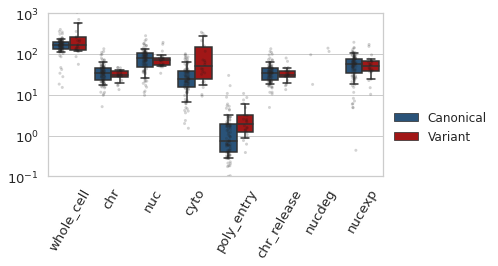

In [99]:
hist_type_col = {'Canonical': '#1D5386', 'Variant': '#B80000'}

ot = OUT_TYPES[0] #[1]=MAP=preferred bc it is used for RPG as well, but Mean is better summary stat
hist_type = ['Canonical', 'Variant']

#Preferred: clipped data for clustering used, so less prone to artificial outliers due to numeric integration.
df = copy.deepcopy(C[o][C[o]['Gene'].isin(hist[hist['type'].isin(hist_type)]['Ensembl gene ID'])]) 

#not preferred because raw data: bit too noisy
# df = copy.deepcopy(B[o][B[o]['Gene'].isin(hist[hist['type'].isin(hist_type)]['Ensembl gene ID'])])
# df = df.merge(K[o], on='Gene', suffixes=('', '_bf'))

# for ts in Timescales_order[idx_add:]:#get nuc exp and nucdeg depending on nuc res or nucdeg gene
#     for rr in org_red_reps[o]:
#         if ts == rt+'nucexp_from_chr':#only for nucres genes according to Bayes Factor
#             df[rr+'.'+ts+ot].where((df[rr+'.bayes_factor'] <= T_bf) | (df[rr+'.bayes_factor'].isna()), 
#                                    df[rr+'.T_nucexp_from_nucdeg'+ot], inplace=True) 
#             df[rr+'.'+ts+ot].where(df[rr+'.'+ts+ot] < 24*60, 24*60, inplace=True)
#             df[rr+'.'+ts+ot].where(df[rr+'.'+ts+ot] > 1e-1, 1e-1, inplace=True)
#         if ts == rt+'nucdeg':#only for nucdeg genes according to Bayes Factor
#             df[rr+'.'+ts+ot].where(df[rr+'.bayes_factor'] > T_bf, np.nan, inplace=True)

            
df['type'] = ''
for ht in hist_type:
    df.loc[df[df['Gene'].isin(hist[hist['type']==ht]['Ensembl gene ID'])].index, 'type'] = ht


cols = []
for ts in Timescales_order:
    for rr in org_red_reps[o]:
        cols.append(rr+'.'+ts+ot)
    
dplot = pd.melt(df, id_vars=['Gene','type'],
                value_vars=cols ,var_name='fraction',value_name='timescale')

#merge replicates
for i in dplot.index: 
    for rr in org_red_reps[o]:    
        dplot.loc[i,'fraction'] = dplot['fraction'][i].replace(rr+'.','')
    dplot.loc[i,'fraction'] = dplot['fraction'][i].replace(ot,'')

dplot['fraction'] = dplot['fraction'].astype('category')
dplot['fraction'].cat.reorder_categories(Timescales_order[:len(Timescales_order)], inplace=True)
dplot['type'] = dplot['type'].astype('category')
dplot['type'].cat.reorder_categories(hist_type, inplace=True)
    
fig2 = plt.figure(figsize=(6,3))
sns.set(style="whitegrid", color_codes=True,font_scale=1.2)
ax = sns.boxplot(x='fraction', y='timescale', hue='type', data=dplot,
                 whis=[10, 90], palette=hist_type_col,flierprops=dict(alpha=0))
ax = sns.stripplot(x='fraction', y='timescale', hue='type', data=dplot,
                 jitter=True,dodge=True, color='k', alpha=0.2,size=3,linewidth=0)
ax.set(yscale="log")       
handles, labels = ax.get_legend_handles_labels()# get legend information from the plot object
fs=12
l = plt.legend(handles[0:2], labels[0:2],loc='center left', bbox_to_anchor=(1, 0.3),fontsize=fs,frameon=False)
plt.ylim([1e-1, 1e3])#[dplot['timescale'].quantile(q=0), dplot['timescale'].quantile(q=1)])#

plt.xticks(rotation = 60)
plt.xlabel('', fontsize=fs)
plt.ylabel('',fontsize=fs)
Timescales_lab = [ts.replace(rt,'') for ts in Timescales_order]
ax.set(xticklabels=Timescales_lab)#[])#


filename = 'histones_canonical_variants_box.'
# plt.savefig(os.path.join(path,filename+'pdf'), bbox_inches="tight", transparent=True)
# plt.savefig(os.path.join(path,filename+'png'), bbox_inches="tight", transparent=True) 

### Wilcoxon rank sum (Mann Whitney U) test for statistical significant difference

In [94]:
ot = OUT_TYPES[0]#=MAP
hist_type = ['Canonical', 'Variant']

test_times = dict()
for ht in hist_type:
    df2 = df[df['Gene'].isin(hist[hist['type']==ht]['Ensembl gene ID'])] #C[o][C[o]['Gene'].isin(hist[hist['type']==ht]['Ensembl gene ID'])]
    for ts in Timescales_order:
        test_times[ts+ht] = []
        for rr in org_red_reps[o]:
            test_times[ts+ht].extend(list(df2[rr+'.'+ts+ot]))     

MWU = dict()                                     
for ts in Timescales_order:
    MWU[ts] = mannwhitneyu(test_times[ts+'Canonical'],
                           test_times[ts+'Variant'],
                           use_continuity=False,#True does not make a difference
                           alternative='two-sided')
    print(ts,'p=', f'{MWU[ts].pvalue:.2e}')

half_life_whole_cell p= 2.05e-01
half_life_chr p= 4.11e-01
half_life_nuc p= 5.33e-01
half_life_cyto p= 2.44e-03
half_life_poly_entry p= 2.58e-04
half_life_chr_release p= 6.02e-01
half_life_nucdeg p= 1.09e-01
half_life_nucexp p= 4.08e-01


In [ ]:
all_clusters = copy.deepcopy(rpg_clusters)
all_clusters.append(0)
for i in all_clusters:
    df = dr_fromR[dr_fromR['Gene'].isin(hist['Ensembl gene ID'])]#only consider RPG genes in respective clusters
#     if i in rpg_clusters:
#         df = df[df['Cluster_heatmap']==i]
#     else:
#         df = df[~df['Cluster_heatmap'].isin(rpg_clusters)]
#     if i !=0:
#         logger.info('cluster heatmap %d: number of RPG genes= %d' % (i,len(df)))
#         logger.info(list(df['Symbol'].sort_values()))
#     else:
#         logger.info('cluster heatmap %s: number of RPG genes= %d' % ('other',len(df)))
#         logger.info(list(df['Symbol'].sort_values()))

In [96]:
df = dr_fromR[dr_fromR['Gene'].isin(hist['Ensembl gene ID'])]
df[['Symbol','Cluster_heatmap']]

Symbol  Cluster_heatmap
15567     H2AC18                1
17505      H2BC6                2
4124       CENPA                3
17378      H4C15                4
17461       H3-2                4
15569      H3C15                5
17392      H4C14                5
17674      H3C10                5
17487      H2BC8                5
17604       H4C5                5
17557      H2BC9               10
17580       H4C9               10
8173       H2BC1               11
9473        H4C8               11
6155       H3-3B               11
3064       H2AZ2               11
3969   MACROH2A1               12
10093      H3-3A               13
14618       H2AX               14
14977     H2AC11               14
17962       H3C2               14
5213      H2BC11               14
17474      H4C12               14
17518     H2BC17               14
9471       H2BC5               14
17613      H2BC7               14
15115       H3C4               14
13966     H2BC21               14
16436     H2BC15               14
14605       H3-5               14
17603     H2AC16               14
17420     H2AC19               14
13412       H2AW               14
5202        H1-3               14
13907       H1-5               14
14995      H2AC7               14
15082      H4C11               14
17672       H4C2               14
17636       H3C7               14
13889     H2AC20               14
15065      H3C12               14
13335      H2BC4               14
17669     H2AC17               14
11363       H1-4               14
14056     H2BC13               14
17609       H4C4               14
14512       H1-2               14
14970     H2AC13               14
15001      H2BU1               14
17590     H2AC14               14
13767      H3C13               14
17542     H2AC15               14
17558       H3C1               14
15568     H2BC18               14
13332      H2AC6               14
17666       H4C1               15
17659      H2AC4               18
13891     H2AC21               18
17528     H2AC12               18
17606      H2AC8               18
16441      H2BS1               18
15219     H2BC12               18
15042       H4C3               22
10366      H2AZ1               28
13994      H1-10               28

In [106]:
dplot[(dplot['type']=='Canonical') & (dplot['fraction']=='half_life_cyto')]['timescale'].median()
# dplot

24.498366128925966

In [107]:
dplot[(dplot['type']=='Variant') & (dplot['fraction']=='half_life_cyto')]['timescale'].median()

49.6144935722465

# RPG timescales: 3 clusters with RPGs

source HGNC_RPGs.tsv: `https://www.genenames.org/cgi-bin/genegroup/download?id=1054&type=branch`

In [27]:
path_er = os.path.join('/n','groups','churchman','ri23','bseq','Function20211108')
filename_rpg = 'HGNC_RPGs.tsv'
rpg = pd.read_csv(os.path.join(path_er, filename_rpg), sep='\t')
print('Ribosomal Protein genes: %d' % len(rpg))

rpg_type = []
for i in rpg.index:
    if re.search('mitochondrial',rpg['Approved name'][i]):
        rpg_type.append('Mito')
    else:
        rpg_type.append('Cyto')
rpg['type'] = rpg_type
rpg = rpg[rpg['type']=='Cyto']#Disregard Mito subunits

rpg_w_times = copy.deepcopy(rpg[rpg['Ensembl gene ID'].isin(C[o]['Gene'])])
print('RPG genes with timescales: %d' % len(rpg_w_times))

# rpg_w_times#.head()

Ribosomal Protein genes: 240
RPG genes with timescales: 87


### Chi2-test for non-uniformity of RPGS across the clusters
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html

In [58]:
from scipy.stats import chisquare

In [59]:
genome_freq = []
rpg_freq = []
omega = len(dr_fromR[dr_fromR['Gene'].isin(rpg['Ensembl gene ID'])]) / len(dr_fromR['Gene'])
for i in dr_fromR['Cluster_heatmap'].unique():
    df = dr_fromR[dr_fromR['Cluster_heatmap']==i]
    genome_freq.append(len(df) * omega)
    rpg_freq.append(len(df[df['Gene'].isin(rpg['Ensembl gene ID'])]))
logger.info(genome_freq)
logger.info(rpg_freq)


chi2, p = chisquare(rpg_freq, genome_freq)
logger.info('chi2_statistic = %f p = %s ' % (chi2, "{:e}".format(p)))

INFO: [2024-02-09 14:31:12] Function - [0.4552806850618459, 1.076117982873454, 4.122359657469078, 8.070884871550904, 0.12416745956232161, 4.32930542340628, 3.460133206470029, 3.468411037107517, 1.696955280685062, 5.430256898192199, 7.416936251189345, 8.319219790675549, 2.2019029495718367, 1.456898192197907, 5.421979067554711, 10.736346336822075, 0.14072312083729782, 2.1687916270218843, 0.9271170313986681, 1.1175071360608946, 0.04138915318744053, 0.21522359657469078, 0.6373929590865842, 0.32283539486203616, 0.38078020932445295, 0.057944814462416755, 1.4486203615604187, 5.016365366317793, 5.902093244529021, 0.28972407231208375, 0.2235014272121789, 0.32283539486203616]
INFO: [2024-02-09 14:31:12] Function - [0, 0, 1, 0, 1, 0, 0, 0, 0, 3, 15, 6, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 13, 3, 0, 0, 0]
INFO: [2024-02-09 14:31:12] Function - chi2_statistic = 835.876217 p = 9.735772e-156 


In [60]:
rpg_clusters = [11, 13, 28]
all_clusters = copy.deepcopy(rpg_clusters)
all_clusters.append(0)

rpg_w_times['Cluster'] = np.nan
for i in dr_fromR['Cluster_heatmap'].unique():

    df = dr_fromR[dr_fromR['Cluster_heatmap']==i]
    if i in rpg_clusters:
        rpg_w_times.loc[rpg_w_times['Ensembl gene ID'].isin(list(df['Gene'])), 'Cluster'] = str(i)
    else:
        rpg_w_times.loc[rpg_w_times['Ensembl gene ID'].isin(list(df['Gene'])), 'Cluster'] = 'other'


filename = 'HGNC_RPGs_clusters.tsv'
# rpg_w_times.to_csv(os.path.join(path, filename), sep='\t',index=False)

### Boxplot of timescales
Done by BMS in latest version

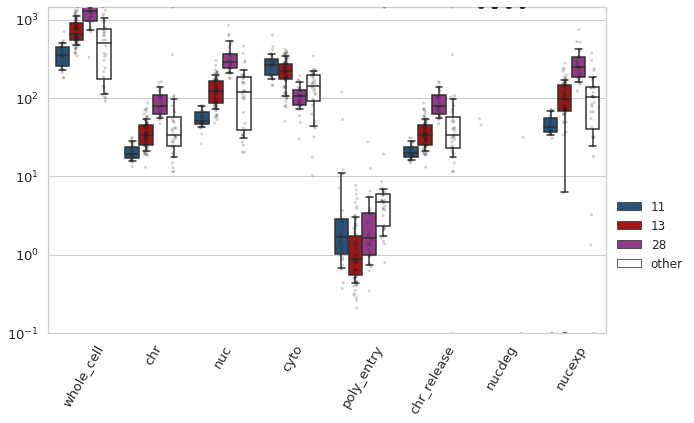

In [84]:
ot = OUT_TYPES[1]

rpg_type_col = {'11':'#1D5386', '13':'#B80000' , #'43': '#D66B1F', '12': '#506C23'
                '28': '#9E2E93', 'other': 'white'}

dplot = copy.deepcopy(dr_fromR[dr_fromR['Gene'].isin(rpg['Ensembl gene ID'])])

for i in dplot.index:    
    cl = dplot['Cluster_heatmap'][i]
    if cl not in rpg_clusters:
        dplot.loc[i,'Cluster_heatmap']='other'
    else:
        dplot.loc[i,'Cluster_heatmap']=str(cl)

cols = []
for ts in Timescales_order:
    for rr in org_red_reps[o]:
        cols.append(rr+'.'+ts+ot)
    
dplot = pd.melt(dplot, id_vars=['Gene','Cluster_heatmap'],
                value_vars=cols ,var_name='fraction',value_name='timescale')

#merge replicates
for i in dplot.index:
    for rr in org_red_reps[o]:    
        dplot.loc[i,'fraction'] = dplot['fraction'][i].replace(rr+'.','')
    dplot.loc[i,'fraction'] = dplot['fraction'][i].replace(ot,'')

dplot['fraction'] = dplot['fraction'].astype('category')
dplot['fraction'].cat.reorder_categories(Timescales_order, inplace=True)
dplot['Cluster_heatmap'] = dplot['Cluster_heatmap'].astype('category')
dplot['Cluster_heatmap'].cat.reorder_categories(rpg_type_col.keys(), inplace=True)
    
fig2 = plt.figure(figsize=(10,6))
sns.set(style="whitegrid", color_codes=True,font_scale=1.2)
ax = sns.boxplot(x='fraction', y='timescale', hue='Cluster_heatmap', data=dplot,
                 whis=[10, 90], palette=rpg_type_col, flierprops=dict(alpha=0))
ax = sns.stripplot(x='fraction', y='timescale', hue='Cluster_heatmap', data=dplot,
                 jitter=True,dodge=True, color='k', alpha=0.2,size=3,linewidth=0)
ax.set(yscale="log")       
handles, labels = ax.get_legend_handles_labels()# get legend information from the plot object
fs=12
leg_labs = [cl for cl in rpg_clusters]
leg_labs.append('other')
l = plt.legend(handles[0:6], leg_labs , 
               loc='center left', bbox_to_anchor=(1, 0.3),fontsize=fs,frameon=False)
# l = plt.legend(handles[0:6], labels[0:6], loc='center left', bbox_to_anchor=(1, 0.3),fontsize=fs)
plt.ylim([dplot['timescale'].quantile(q=0), dplot['timescale'].quantile(q=1)])#
#[10**(-1), dplot['timescale'].quantile(q=0.95)])#1e3])#

plt.xticks(rotation = 60)
plt.xlabel('', fontsize=fs)
plt.ylabel('',fontsize=fs)
Timescales_lab = [ts.replace(rt,'') for ts in Timescales_order]#Timescales[:len(Timescales)-1]
ax.set(xticklabels=Timescales_lab)#[])#


filename = 'HGNC_RPGs_clusters_box.'
# plt.savefig(os.path.join(path,filename+'pdf'), bbox_inches="tight", transparent=True)
# plt.savefig(os.path.join(path,filename+'png'), bbox_inches="tight", transparent=True) 

In [64]:
all_clusters = copy.deepcopy(rpg_clusters)
all_clusters.append(0)
for i in all_clusters:
    df = dr_fromR[dr_fromR['Gene'].isin(rpg['Ensembl gene ID'])]#only consider RPG genes in respective clusters
    if i in rpg_clusters:
        df = df[df['Cluster_heatmap']==i]
    else:
        df = df[~df['Cluster_heatmap'].isin(rpg_clusters)]
    if i !=0:
        logger.info('cluster heatmap %d: number of RPG genes= %d' % (i,len(df)))
        logger.info(list(df['Symbol'].sort_values()))
    else:
        logger.info('cluster heatmap %s: number of RPG genes= %d' % ('other',len(df)))
        logger.info(list(df['Symbol'].sort_values()))

INFO: [2024-02-09 14:33:58] Function - cluster heatmap 11: number of RPG genes= 15
INFO: [2024-02-09 14:33:58] Function - ['RPL10A', 'RPL11', 'RPL12', 'RPL23', 'RPL28', 'RPL29', 'RPL37', 'RPL37A', 'RPL38', 'RPS14', 'RPS19', 'RPS24', 'RPS27', 'RPS27L', 'RPS9']
INFO: [2024-02-09 14:33:58] Function - cluster heatmap 13: number of RPG genes= 43
INFO: [2024-02-09 14:33:58] Function - ['RPL10', 'RPL13', 'RPL13A', 'RPL14', 'RPL15', 'RPL17', 'RPL18A', 'RPL19', 'RPL23A', 'RPL24', 'RPL26', 'RPL27', 'RPL3', 'RPL31', 'RPL32', 'RPL34', 'RPL36A', 'RPL39', 'RPL4', 'RPL7A', 'RPL9', 'RPLP0', 'RPLP1', 'RPLP2', 'RPS10', 'RPS11', 'RPS13', 'RPS15', 'RPS15A', 'RPS16', 'RPS17', 'RPS18', 'RPS2', 'RPS20', 'RPS23', 'RPS27A', 'RPS28', 'RPS3', 'RPS5', 'RPS7', 'RPS8', 'RPSA', 'UBA52']
INFO: [2024-02-09 14:33:58] Function - cluster heatmap 28: number of RPG genes= 13
INFO: [2024-02-09 14:33:58] Function - ['DAP3', 'FAU', 'RPL21', 'RPL35A', 'RPL39L', 'RPL5', 'RPL7', 'RPL8', 'RPS12', 'RPS21', 'RPS3A', 'RPS4X', 'RPS6'

# Nucdeg genes enrichment

In [200]:
path_nucdeg = os.path.join('/n','groups','churchman','ri23','bseq','BayesFactor20240112')

nucdeg = dict()
nucdeg_genes = dict()
for o in organisms:
    filename = 'Nucdeg_20240112_'+org_map[o]+'_final.tsv'
    nucdeg[o] = pd.read_csv(os.path.join(path_nucdeg, filename), sep='\t')

    nucdeg_genes[o] = list(nucdeg[o]['Gene'])
    logger.info('%s %d nucdeg input genes' % (o, len(nucdeg_genes[o])))

INFO: [2024-02-02 17:51:41] Function - m 509 nucdeg input genes
INFO: [2024-02-02 17:51:41] Function - h 371 nucdeg input genes


In [201]:
alpha_fdr = 0.05
gene_universe = dict()
goea_results_nucdeg = dict()

for o in organisms:
    #Get universe of genes (entrez_ids) for enrichment analysis
    gene_universe[o] = list(gene_map[o][gene_map[o]['ens_id'].isin(C[o]['Gene'])]['entrez_id'].astype(int))

    #Initialize a GOEA object
    goeaobj = GOEnrichmentStudyNS(gene_universe[o], # universe List of protein-coding genes
                                  ns2assoc[o], #geneid/GO associations (from NCBI gene)
                                  go_dag, # Ontologies
                                  propagate_counts = True,#default True: parental GOannos are also annotations 
                                  alpha = alpha_fdr, # default significance cut-off
                                  methods = ['fdr_bh']) # default multiple test correction method

    logger.info(sorted(gene_map[o][gene_map[o]['ens_id'].isin(nucdeg_genes[o])]['Symbol']))
    geneids_study = list(gene_map[o][gene_map[o]['ens_id'].isin(nucdeg_genes[o])]['entrez_id'].astype(int))

    goea_results_nucdeg[o] = goeaobj.run_study(geneids_study)#, prt=None)


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a


3 GO IDs NOT FOUND IN ASSOCIATION: GO:0001207 GO:0033168 GO:0036404


 90%  9,368 of 10,425 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 94%  9,774 of 10,425 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts 

1 GO IDs NOT FOUND IN ASSOCIATION: GO:0031493
INFO: [2024-02-02 17:51:58] Function - ['2410002F23Rik', '2700097O09Rik', '5730480H06Rik', 'A930033H14Rik', 'AU022252', 'Abcc1', 'Abcd4', 'Acer3', 'Acin1', 'Actr10', 'Adamtsl5', 'Adk', 'Adpgk', 'Afg3l2', 'Agbl3', 'Agtpbp1', 'Akap5', 'Akap8', 'Akr1b10', 'Alkbh1', 'Amn1', 'Anapc11', 'Ank3', 'Ankle1', 'Ankrd52', 'Anks3', 'Ano8', 'Anxa5', 'Ap1ar', 'Araf', 'Arfrp1', 'Arhgef40', 'Armcx5', 'Arpc1b', 'Atp1a1', 'Atp2a2', 'Atp5j2', 'Atp6v0c', 'Atp9b', 'Atr', 'Atrx', 'BC004004', 'Bcas2', 'Bclaf1', 'Birc6', 'Brcc3', 'Brd8', 'Brd9', 'Brf1', 'Bscl2', 'C2cd5', 'Calr', 'Camk2d', 'Camkk2', 'Camta1', 'Cars2', 'Ccdc167', 'Ccdc86', 'Ccdc9', 'Ccdc9b', 'Cchcr1', 'Ccl25', 'Ccnl1', 'Cd1d1', 'Cd2ap', 'Cd81', 'Cdc37l1', 'Cdc42bpa', 'Cdk10', 'Cdsn', 'Cenpa', 'Cenpk', 'Cenpt', 'Cenpw', 'Cep295', 'Cep295nl', 'Cep63', 'Chd2', 'Chd6', 'Chka', 'Churc1', 'Ciapin1', 'Cirbp', 'Cit', 'Ciz1', 'Clasrp', 'Clec11a', 'Clk1', 'Clk3', 'Commd6', 'Cop1', 'Cope', 'Copg1', 'Coq7', 'Cox1

up: is_a
 85%  8,857 of 10,425 population items found in association

Run BP Gene Ontology Analysis: current study set of 494 IDs ... 88%    434 of    492 study items found in association
100%    492 of    494 study items found in population(10425)
Calculating 13,610 uncorrected p-values using fisher_scipy_stats
  13,610 GO terms are associated with  9,356 of 10,425 population items
   4,108 GO terms are associated with    434 of    494 study items
  METHOD fdr_bh:
      21 GO terms found significant (< 0.05=alpha) ( 21 enriched +   0 purified): statsmodels fdr_bh
     178 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 494 IDs ... 93%    459 of    492 study items found in association
100%    492 of    494 study items found in population(10425)
Calculating 1,827 uncorrected p-values using fisher_scipy_stats
   1,827 GO terms are associated with  9,761 of 10,

4 GO IDs NOT FOUND IN ASSOCIATION: GO:0001207 GO:0033168 GO:0036404 GO:2001216


 90%  9,431 of 10,461 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 95%  9,902 of 10,461 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a


1 GO IDs NOT FOUND IN ASSOCIATION: GO:0031493
INFO: [2024-02-02 17:52:19] Function - ['ABHD14A-ACY1', 'ACAA1', 'ACAP3', 'ACY1', 'ADAMTSL4', 'AGPAT5', 'AKT2', 'ALG11', 'ALKBH6', 'ANAPC2', 'ANKLE2', 'ANKS3', 'AP1G2', 'ARFGAP2', 'ARFIP2', 'ARFRP1', 'ARID1B', 'ARIH1', 'ARL6IP4', 'ASL', 'ASPH', 'ATAD3B', 'ATF7IP2', 'ATP13A1', 'ATP5MG', 'BAG1', 'BOLA3', 'BORCS8', 'BRD9', 'BRWD1', 'BUD23', 'C15orf40', 'C20orf203', 'C21orf58', 'C2CD2L', 'C2orf68', 'C6orf89', 'C8orf82', 'CAPN10', 'CBWD5', 'CC2D1B', 'CCDC14', 'CCDC142', 'CDK10', 'CDK5RAP3', 'CENPT', 'CHORDC1', 'CHPF2', 'CHTF18', 'CHTOP', 'CIAO3', 'CIRBP', 'CISD3', 'CLCN3', 'CLIP1', 'CLN5', 'CMC1', 'CNOT2', 'COA6', 'COMMD4', 'COPS5', 'COX20', 'CPSF4', 'CTNNB1', 'CTSC', 'CTTN', 'CYTH2', 'CZIB', 'DARS2', 'DAZAP1', 'DBNL', 'DDX11', 'DDX19A', 'DDX27', 'DDX39B', 'DDX41', 'DDX5', 'DDX51', 'DDX55', 'DENND4B', 'DGCR8', 'DHRS11', 'DNAJB11', 'DNAJB14', 'DNAJC7', 'DNM1', 'DPAGT1', 'DRG2', 'DST', 'DUS1L', 'DVL2', 'E4F1', 'EEF1D', 'EGLN2', 'EIF2B4', 'EIF2B5',

 94%  9,791 of 10,461 population items found in association

Run BP Gene Ontology Analysis: current study set of 364 IDs ... 89%    325 of    364 study items found in association
100%    364 of    364 study items found in population(10461)
Calculating 13,146 uncorrected p-values using fisher_scipy_stats
  13,146 GO terms are associated with  9,431 of 10,461 population items
   3,555 GO terms are associated with    325 of    364 study items
  METHOD fdr_bh:
      11 GO terms found significant (< 0.05=alpha) ( 11 enriched +   0 purified): statsmodels fdr_bh
      74 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 364 IDs ... 94%    341 of    364 study items found in association
100%    364 of    364 study items found in population(10461)
Calculating 1,788 uncorrected p-values using fisher_scipy_stats
   1,788 GO terms are associated with  9,902 of 10,461 popul

In [202]:
nd_plot_genes = dict()
nd_plot_GO =dict()
nd_plot_GO['h'] = ['RNA splicing',#'spliceosomal complex',#
                   'ribosome',#'translation',#manually chosen based on minimal overlap and interesting biology to show
#                    'positive regulation of telomere maintenance',
#                    'RNA helicase activity',            
                   'mRNA export from nucleus']
nd_plot_GO['m'] = ['RNA splicing',#'spliceosomal complex'#
                   'ribosome',#'translation',#manually chosen based on minimal overlap and interesting biology to show
#                    'positive regulation of telomere maintenance', 
#                    'RNA helicase activity',
                   'mRNA export from nucleus']

for o in organisms:#[1:]:
    print(o)
    nd_plot_genes[o] = dict()
    
    goea_results_sig = [r for r in goea_results_nucdeg[o] if ((r.p_fdr_bh < alpha_fdr) and (r.enrichment == 'e'))]

    for r in goea_results_sig:

        if ((r.ratio_in_study[1] - r.ratio_in_study[0]) > 0) and \
            ((r.ratio_in_pop[0] - r.ratio_in_study[0]) > 0):
            OR = r.ratio_in_study[0] * (r.ratio_in_pop[1] - r.ratio_in_pop[0]) / \
            ((r.ratio_in_study[1] - r.ratio_in_study[0]) * (r.ratio_in_pop[0] - r.ratio_in_study[0]) )
        else: 
            OR = np.nan

        print('p_adj=',f'{r.p_fdr_bh:.1e}', ', OR=', f'{OR:.3e}', r.NS, r.name, 
              r.ratio_in_study[0],'/',r.ratio_in_pop[0]) 
#         if o == 'm':#print gene sets
#             print(gene_map[o][gene_map[o]['entrez_id'].astype('int').isin(r.study_items)].sort_values(by='Symbol')['Symbol'].values, '\n')
#         elif o == 'h':
#             print(gene_map[o][gene_map[o]['entrez_id'].isin(r.study_items)].sort_values(by='Symbol')['Symbol'].values, '\n')
        
        if r.name in nd_plot_GO[o]:
            if o == 'm':
                nd_plot_genes[o][r.name] = gene_map[o][gene_map[o]['entrez_id'].astype('int').isin(r.study_items)]['ens_id'].values
            elif o == 'h': 
                nd_plot_genes[o][r.name] = gene_map[o][gene_map[o]['entrez_id'].isin(r.study_items)]['ens_id'].values

            #TEMP TO ONLY SHOW RESULTS HIGHLIGHTED in FIG 2D 
            print('p_adj=',f'{r.p_fdr_bh:.1e}', ', OR=', f'{OR:.3e}', r.NS, r.name, 
              r.ratio_in_study[0],'/',r.ratio_in_pop[0]) 
            if o == 'm':
                print(gene_map[o][gene_map[o]['entrez_id'].astype('int').isin(r.study_items)].sort_values(by='Symbol')['Symbol'].values, '\n')
            elif o == 'h':
                print(gene_map[o][gene_map[o]['entrez_id'].isin(r.study_items)].sort_values(by='Symbol')['Symbol'].values, '\n')
    

m
p_adj= 1.2e-11 , OR= 7.875e+00 BP regulation of RNA splicing 32 / 123
p_adj= 1.7e-11 , OR= 4.769e+00 BP RNA splicing 48 / 278
p_adj= 1.7e-11 , OR= 4.769e+00 BP RNA splicing 48 / 278
['Acin1' 'Bcas2' 'Clasrp' 'Cwf19l2' 'Ddx17' 'Ddx47' 'Ddx5' 'Fus' 'Gm21992'
 'Hnrnph1' 'Hnrnpu' 'Jmjd6' 'Luc7l3' 'Mettl3' 'Pnn' 'Prpf38b' 'Prpf39'
 'Ptbp2' 'Rbm25' 'Rbm39' 'Rbm4' 'Rbm4b' 'Rbm5' 'Rbm6' 'Rbmx' 'Sf1' 'Sfpq'
 'Snrnp48' 'Snrnp70' 'Srpk1' 'Srrm2' 'Srsf3' 'Srsf5' 'Srsf6' 'Sugp1'
 'Sugp2' 'Tardbp' 'Thoc1' 'Thoc6' 'Thoc7' 'Thrap3' 'Tra2a' 'Tra2b'
 'Tsen15' 'Ythdc1' 'Zfp326' 'Zranb2' 'Zrsr2'] 

p_adj= 3.4e-11 , OR= 3.199e+00 BP RNA processing 80 / 672
p_adj= 1.2e-10 , OR= 4.109e+00 BP mRNA processing 52 / 342
p_adj= 2.1e-08 , OR= 3.219e+00 BP mRNA metabolic process 59 / 480
p_adj= 4.6e-08 , OR= 6.320e+00 BP regulation of mRNA processing 26 / 117
p_adj= 4.6e-08 , OR= 4.388e+00 BP regulation of mRNA metabolic process 37 / 226
p_adj= 1.4e-06 , OR= 7.069e+00 BP regulation of mRNA splicing, via spliceoso

## MS figure: Volcano plot of nuclear degradation genes:
X axis: nuc deg rate (geometric(?) average) over two replicates  
Y axis: Bayes factor (geometric(?) average) over two replicates

run first cell of "Nucdeg genes enrichment".

In [203]:
bf = '_bf'
vc = dict()
rt_vc = RATE_TYPE[1]
ts = rt_vc+'nucdeg'
eps = 1e-16
cap = 1e96#1/eps

for o in organisms:
    vc[o] = copy.deepcopy(B[o])
    vc[o] = vc[o].merge(K[o], on='Gene', suffixes=('', bf))
    #nuclear degradation genes: reproducible Bayes Factor > 100
    vc[o]['nucdeg'] = vc[o]['Gene'].isin(nucdeg[o]['Gene'])
    
    #Bayes Factor averaging over two bio reps
    nc_reps = []
#     vc[o][bf] = 0 #mean: 0, geometric mean: 1
    for r in org_red_reps[o]:
        vc[o] = vc[o][(~vc[o][r+'.bayes_factor_4'].isna()) | (~vc[o][r+'.bayes_factor_3'].isna())] 
        vc[o][r+'.bayes_factor_4'].where(~vc[o][r+'.bayes_factor_4'].isna(), vc[o][r+'.bayes_factor_3'], 
                                         inplace=True)        
        vc[o][r+'.bayes_factor_4'].where(vc[o][r+'.bayes_factor_4'] > eps, eps, inplace=True)
        #Geometric mean
        nc_reps.append(r+'.bayes_factor_4') 
    vc[o][bf] = pd.Series(gmean(np.asarray(vc[o][nc_reps]), axis=1), index=vc[o].index)
    vc[o][bf].where(vc[o][bf] < cap, cap, inplace=True)

    #Nuc deg rate Geometric mean averaging over two bio reps      
    for ot in OUT_TYPES[1:2]:        
        nc_reps = []
        for r in org_red_reps[o]:
            nc_reps.append(r+'.'+ts+ot) 
        vc[o][ts+ot] = pd.Series(gmean(np.asarray(vc[o][nc_reps]), axis=1), index=vc[o].index)


    logger.info('%s %d nucdeg genes in plot' % (o, len(vc[o][vc[o]['nucdeg']])))
    logger.info('%s %d other genes in plot' % (o, len(vc[o][~vc[o]['nucdeg']])))

INFO: [2024-02-02 17:52:36] Function - m 509 nucdeg genes in plot
INFO: [2024-02-02 17:52:36] Function - m 11158 other genes in plot
INFO: [2024-02-02 17:52:36] Function - h 371 nucdeg genes in plot
INFO: [2024-02-02 17:52:36] Function - h 11038 other genes in plot


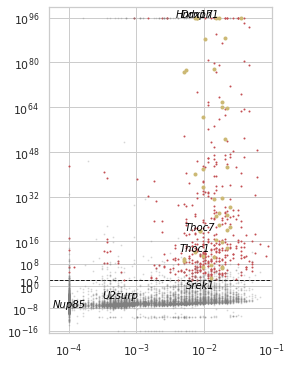

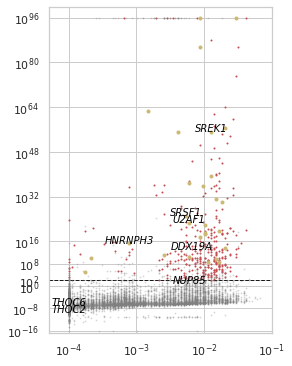

In [35]:
k_bound_lo = 1e-4 #1e-4 unit: min^-1: 1 per 7 days #same as in Bayes_factor_20220307.ipynb
N_range = 8 #same as in Bayes_factor_20220307.ipynb
x_range = [k_bound_lo*10**(i) for i in range(-1, N_range+1)]
y_range = np.asarray([1e-16, 1e-8, 1e0, 1e2, 1e8,1e16,1e32, 1e48, 1e64, 1e80, cap])
nd_cmap = ['y','b','purple']#'c','g',
visual_genes = dict()
visual_genes['m'] = {'Srsf2','U2surp','Srek1','Hnrnph1','Ddx17','Thoc1','Nup85', 'Thoc7'}
visual_genes['h'] = {'SRSF1','U2AF1','SREK1','HNRNPH3','DDX19A', 'THOC2','NUP85', 'THOC6'}


for o in organisms:
    for ot in OUT_TYPES[1:2]:
    
        x =  vc[o][ts+ot]
        y =  vc[o][bf]

        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(4,6))#inches

        leg = ['','']#['nuclear degradation', 'other']
        g = plt.errorbar(x[vc[o]['nucdeg']], 
                         y[vc[o]['nucdeg']],
                     fmt="o",alpha=1,markersize=1,color='r',#MS figure: markersize=1
                     elinewidth=0.5)#size=1.5)
        

        plt.errorbar(x[~vc[o]['nucdeg']], 
                     y[~vc[o]['nucdeg']],
                     fmt="o",alpha=0.2,markersize=1,color='grey',
                     elinewidth=0.5)#size=1.5)
              
        for i, go_term in enumerate(nd_plot_GO[o]):
            if go_term in nd_plot_genes[o].keys():
                plt.errorbar(x[vc[o]['Gene'].isin(nd_plot_genes[o][go_term])], 
                             y[vc[o]['Gene'].isin(nd_plot_genes[o][go_term])],
                             fmt="o",alpha=1,markersize=3,color=nd_cmap[i],
                             elinewidth=0.5)#size=1.5)
                leg.append('')#'nuclear degradation: %s' % go_term)

        
        plt.plot(x_range, T_bf * np.ones(len(x_range)),'--k',linewidth=1)
        

#         if o == 'h':
            #add target names to plot
        for i in vc[o][vc[o]['Symbol'].isin(visual_genes[o])].index:
            gname = vc[o]['Symbol'][i]
            x_txt = x[i]
            y_txt = y[i]#+0.01
#             ax.annotate('figure pixels',
#             xy=(10, 10), xycoords='xydata')
            ax.text(x_txt, y_txt, gname, horizontalalignment='center', color='black', size=10,
                   weight='regular', fontstyle='italic')#'semibold',

    
        ax.set_xscale('log')
        ax.set_yscale('log')
        lim_min_x = 0.5 * max(min(x),1e-4) #min(min(x), min(y))
        lim_max_x = 0.1 #max(x)#2 * max(x)#max(max(x), max(y))
        lim_min_y = 0.2 * min(min(y),eps) #min(min(x), min(y))
        lim_max_y = max(max(y), cap*(10**4))#max(max(x), max(y))
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.xlim(lim_min_x, lim_max_x)
        plt.ylim(lim_min_y, lim_max_y)

#         plt.xlabel(ts)
#         plt.ylabel(bf)

        filename = 'Nucdeg_xknucdeg'+ot+'_y'+bf+'_scat_'+o+'.'
#         plt.savefig(os.path.join(path,filename+'pdf'),bbox_inches="tight",transparent=True)
#         plt.savefig(os.path.join(path,filename+'tiff'),bbox_inches="tight",transparent=True,dpi=300)
#         plt.savefig(os.path.join(path,filename+'png'),bbox_inches="tight",transparent=True,dpi=300)

### RPGs with nuc deg

In [204]:
gtemp = list(vc[o][(vc[o]['Gene'].isin(rpg_w_times['Ensembl gene ID'])) & (vc[o]['nucdeg'])]['Symbol'].sort_values())
logger.info('# of RPG nucdeg genes: %d' % len(gtemp))
logger.info(gtemp)

INFO: [2024-02-02 17:52:56] Function - # of RPG nucdeg genes: 2
INFO: [2024-02-02 17:52:56] Function - ['RPL27A', 'RPL28']


In [205]:
gtemp = list(vc[o][(vc[o]['Gene'].isin(rpg_w_times['Ensembl gene ID'])) & (~vc[o]['nucdeg'])]['Symbol'].sort_values())
logger.info('# of not nucdeg RPGs: %d' % len(gtemp))
logger.info(gtemp)

# len(vc[o][(vc[o]['Gene'].isin(rpg_w_times['Ensembl gene ID'])) & (vc[o]['nucdeg'])])

INFO: [2024-02-02 17:53:03] Function - # of not nucdeg RPGs: 36
INFO: [2024-02-02 17:53:03] Function - ['DAP3', 'FAU', 'RPL10', 'RPL10A', 'RPL10L', 'RPL17', 'RPL21', 'RPL22L1', 'RPL26', 'RPL26L1', 'RPL27', 'RPL29', 'RPL30', 'RPL32', 'RPL34', 'RPL35A', 'RPL36', 'RPL36A', 'RPL36AL', 'RPL38', 'RPL39L', 'RPL41', 'RPL7', 'RPL7L1', 'RPS11', 'RPS13', 'RPS15', 'RPS19', 'RPS21', 'RPS24', 'RPS25', 'RPS26', 'RPS27', 'RPS27L', 'RPS29', 'RPS9']


In [206]:
gtemp = list(B[o][(B[o]['Gene'].isin(rpg_w_times['Ensembl gene ID'])) & 
                  (~B[o]['Gene'].isin(vc[o]['Gene']))]['Symbol'].sort_values())
logger.info('# of RPGs without Bayes factor (undecided): %d' % len(gtemp))
logger.info(gtemp)


INFO: [2024-02-02 17:53:08] Function - # of RPGs without Bayes factor (undecided): 49
INFO: [2024-02-02 17:53:08] Function - ['RPL11', 'RPL12', 'RPL13', 'RPL13A', 'RPL14', 'RPL15', 'RPL18', 'RPL18A', 'RPL19', 'RPL22', 'RPL23', 'RPL23A', 'RPL24', 'RPL3', 'RPL31', 'RPL35', 'RPL37', 'RPL37A', 'RPL39', 'RPL4', 'RPL5', 'RPL6', 'RPL7A', 'RPL8', 'RPL9', 'RPLP0', 'RPLP1', 'RPLP2', 'RPS10', 'RPS12', 'RPS14', 'RPS15A', 'RPS16', 'RPS17', 'RPS18', 'RPS2', 'RPS20', 'RPS23', 'RPS27A', 'RPS28', 'RPS3', 'RPS3A', 'RPS4X', 'RPS5', 'RPS6', 'RPS7', 'RPS8', 'RPSA', 'UBA52']


In [207]:
gtemp = list(B[o][(B[o]['Gene'].isin(rpg['Ensembl gene ID'])) & 
                  (~B[o]['Gene'].isin(rpg_w_times['Ensembl gene ID']))]['Symbol'].sort_values())
logger.info('# of RPGs without rates: %d' % len(gtemp))
logger.info(gtemp)

INFO: [2024-02-02 17:53:10] Function - # of RPGs without rates: 3
INFO: [2024-02-02 17:53:10] Function - ['RPL3L', 'RPS4Y1', 'RPS4Y2']


### Overlay ER enriched clusters with Nucleoplasm Nanopore mito/ER genes
from Brendan and Karine

In [28]:
def get_contingency_table(universe,Total_condition1,Total_condition2,Overlap_cond12):
    ct = [[1, 2], [3, 4]]#contingency table
    ct[0][0] = Overlap_cond12
    ct[0][1] = Total_condition2-Overlap_cond12
    ct[1][0] = Total_condition1-Overlap_cond12
    ct[1][1] = universe-Total_condition1-Total_condition2+Overlap_cond12
    return ct

In [109]:
path_er = os.path.join('/n','groups','churchman','ri23','bseq','Function20211108')
filename_nano = 'first_pass_exclude_mito_ER.csv'
nano = pd.read_csv(os.path.join(path_er, filename_nano))
print(len(nano))

1212


In [111]:
for i in range(1, (N_clust+1)):
    df = dr_fromR[dr_fromR['Cluster_heatmap']==i]
    test = set(df[df['Gene'].isin(nano['Ensembl_Gene'])]['Symbol'])
    N_all_genes = len(C[o])
    N_cluster_genes = len(df)
    N_nano_genes = len(nano)
    N_cluster_nano_overlap=len(test)
    print('cluster %d %d / %d ' % (i, N_cluster_nano_overlap, N_cluster_genes))
    
    cont_table = get_contingency_table(N_all_genes,
                                       N_cluster_genes,
                                       N_nano_genes,
                                       N_cluster_nano_overlap)    

    OR , pval = fisher_exact(cont_table)
    print('Fisher Exact odds ratio',OR,'pvalue',pval)
#     c2, pval, dof, ex = chi2_contingency(cont_table, correction=True)
#     print('Chi2 statistic',c2,'pvalue',pval,'degrees of freedom',dof)
#     print('contingency table \n', cont_table)
    # print('expected contingency table under independence null hypothesis \n', ex)

cluster 1 1 / 55 
Fisher Exact odds ratio 0.14582377588157935 pvalue 0.017998231554768738
cluster 2 0 / 130 
Fisher Exact odds ratio 0.0 pvalue 3.3815001912564173e-07
cluster 3 14 / 498 
Fisher Exact odds ratio 0.21986368465348582 pvalue 3.3747043956622247e-12
cluster 4 65 / 975 
Fisher Exact odds ratio 0.5405405405405406 pvalue 6.748409154386154e-07
cluster 5 0 / 15 
Fisher Exact odds ratio 0.0 pvalue 0.4002970653842699
cluster 6 35 / 523 
Fisher Exact odds ratio 0.5546366839840104 pvalue 0.00047553007791414003
cluster 7 12 / 418 
Fisher Exact odds ratio 0.22620689655172413 pvalue 3.4488318967627604e-10
cluster 8 73 / 419 
Fisher Exact odds ratio 1.7123122909762645 pvalue 0.00010239207082569766
cluster 9 2 / 205 
Fisher Exact odds ratio 0.07643203191792533 pvalue 1.6132787382761048e-08
cluster 10 7 / 656 
Fisher Exact odds ratio 0.08002992155182886 pvalue 1.836115739710682e-25
cluster 11 6 / 896 
Fisher Exact odds ratio 0.048633238302867685 pvalue 2.9271378023010044e-39
cluster 12 31 

In [27]:
rt

'half_life_'

In [55]:
Timescales

['half_life_whole_cell',
 'half_life_chr',
 'half_life_nuc',
 'half_life_cyto',
 'half_life_poly_entry',
 'half_life_nucexp_from_nucres',
 'half_life_nucexp_from_dist',
 'half_life_nucdeg',
 'half_life_nucexp_from_nucdeg',
 'half_life_chr_release_from_nucdeg']

In [64]:
Timescales_all

['half_life_whole_cell',
 'half_life_chr',
 'half_life_nuc',
 'half_life_cyto',
 'half_life_poly_entry',
 'half_life_nucexp_from_nucres',
 'half_life_nucexp_from_dist',
 'half_life_nucdeg',
 'half_life_nucexp_from_nucdeg',
 'half_life_chr_release_from_nucdeg',
 'half_life_chr_release',
 'half_life_nucexp']

In [61]:
rt

'half_life_'

# Correlation coefficients between replicates of latest rates (Fig S3D)

In [4]:
Timescales_all = copy.deepcopy(Timescales)
Timescales_all.extend(['half_life_chr_release', 'half_life_nucexp'])

C = dict()
for o in organisms:
    C[o] = copy.deepcopy(B[o])
    C[o] = C[o].merge(K[o], on='Gene', suffixes=('', '_bf'))
    logger.info('%s all genes: %d' % (org_map[o], len(C[o])))
    
    for ts in Timescales_all:
        for ot in OUT_TYPES:
            for rr in org_red_reps[o]:
                if ts == rt + 'chr_release':
                    C[o][rr+'.'+ts+ot] = copy.deepcopy(C[o][rr+'.'+ts+'_from_nucdeg.MAP'].where(
                        C[o]['PUND'], C[o][rr+'.half_life_chr'+ot]))
#                     logger.info(ts)
                if ts == rt + 'nucdeg':#only for nucdeg genes according to Bayes Factor
                    C[o][rr+'.'+ts+'.MAP'].where(C[o]['PUND'], np.nan, inplace=True)
#                     logger.info(ts)
                if ts == rt + 'nucexp':
                    C[o][rr+'.'+ts+ot] = copy.deepcopy(C[o][rr+'.'+ts+'_from_nucdeg.MAP'].where(
                        C[o]['PUND'], C[o][rr+'.'+ts+'_from_nucres'+ot]))
#                     logger.info(ts)

INFO: [2024-05-27 11:43:07] Function - mouse all genes: 17821
INFO: [2024-05-27 11:43:07] Function - human all genes: 17985


INFO: [2024-01-23 10:43:40] Function - mouse all genes: 17821
INFO: [2024-01-23 10:43:40] Function - human all genes: 17985
INFO: [2024-01-23 10:43:41] Function - Comparison_mouse_half_life_whole_cell.Mean_all_xG_R_yH_S_scat.
INFO: [2024-01-23 10:43:41] Function - Comparison_mouse_half_life_whole_cell.Mean_non-PUND_xG_R_yH_S_scat.
INFO: [2024-01-23 10:43:41] Function - Comparison_mouse_half_life_whole_cell.Mean_PUND_xG_R_yH_S_scat.
INFO: [2024-01-23 10:43:41] Function - Comparison_human_half_life_whole_cell.Mean_all_xT_yU_scat.
INFO: [2024-01-23 10:43:41] Function - Comparison_human_half_life_whole_cell.Mean_non-PUND_xT_yU_scat.
INFO: [2024-01-23 10:43:41] Function - Comparison_human_half_life_whole_cell.Mean_PUND_xT_yU_scat.
INFO: [2024-01-23 10:43:41] Function - Comparison_mouse_half_life_chr.Mean_all_xG_R_yH_S_scat.
INFO: [2024-01-23 10:43:42] Function - Comparison_mouse_half_life_chr.Mean_non-PUND_xG_R_yH_S_scat.
INFO: [2024-01-23 10:43:42] Function - Comparison_mouse_half_life_chr

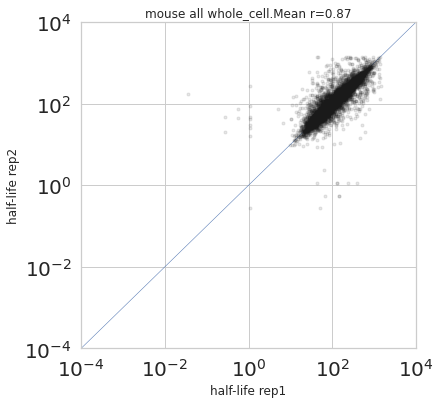

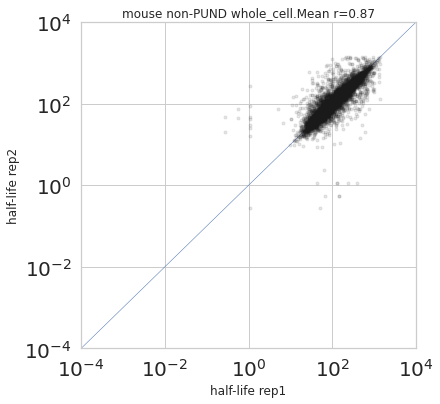

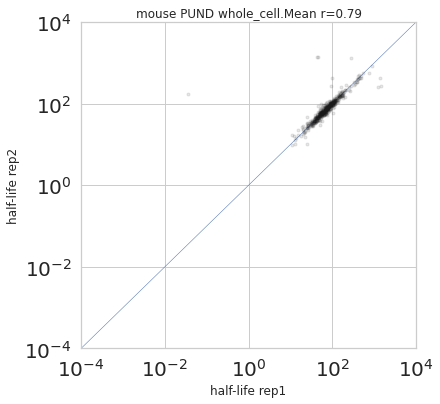

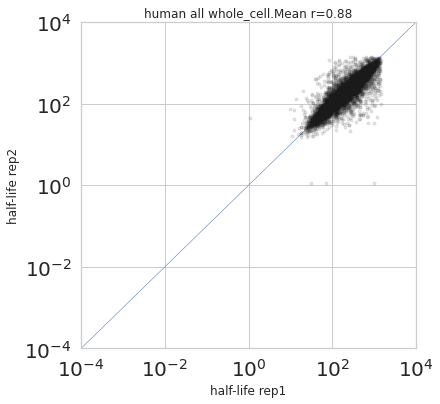

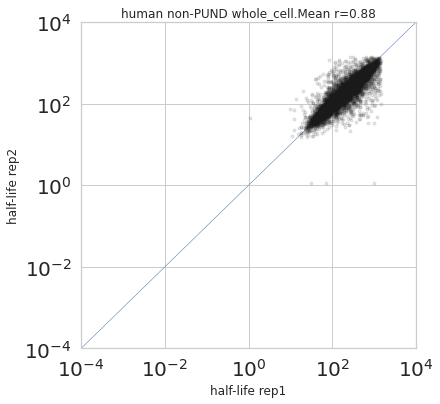

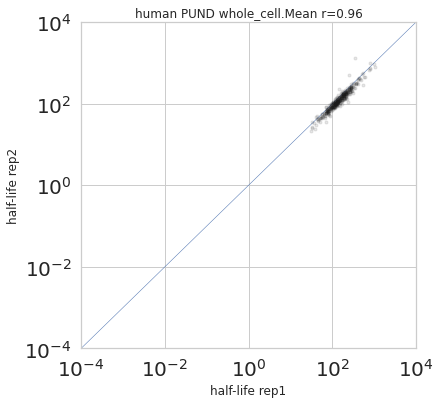

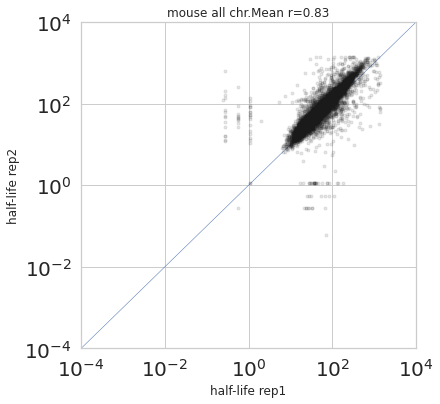

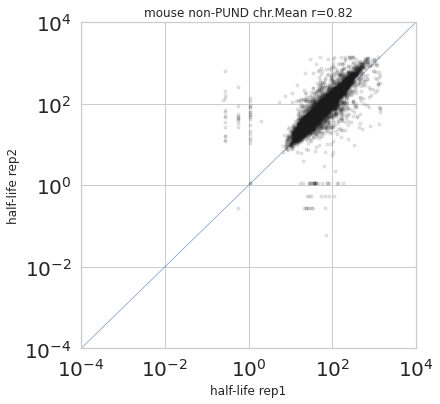

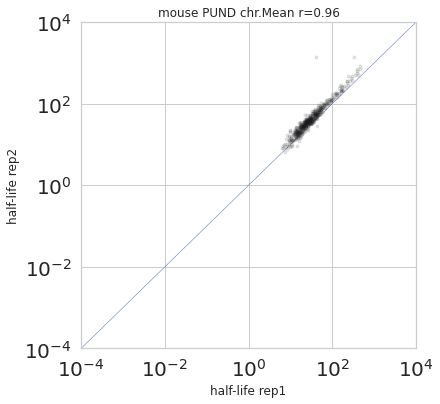

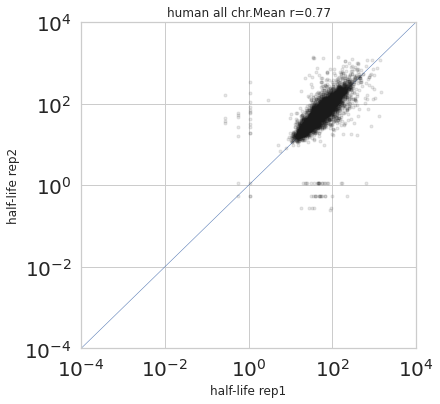

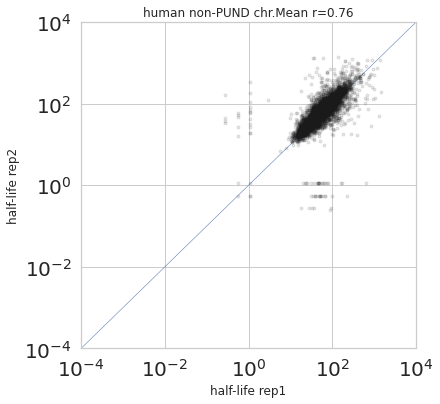

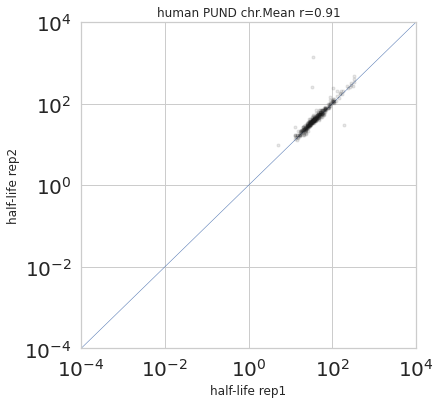

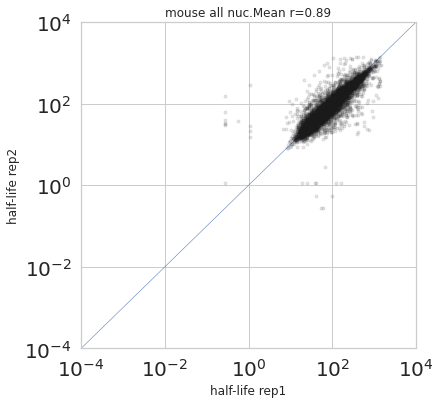

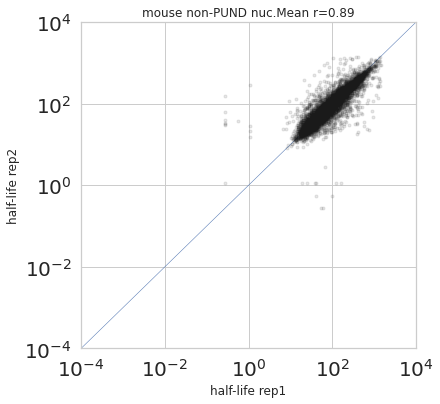

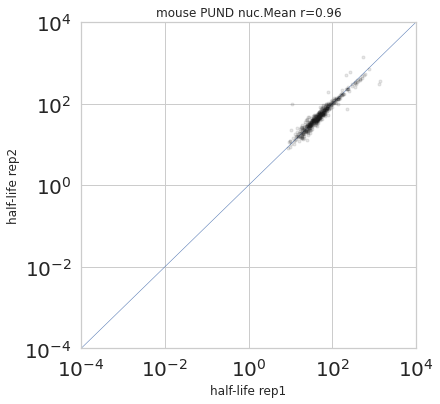

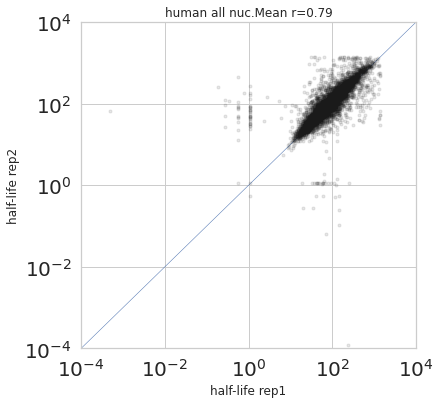

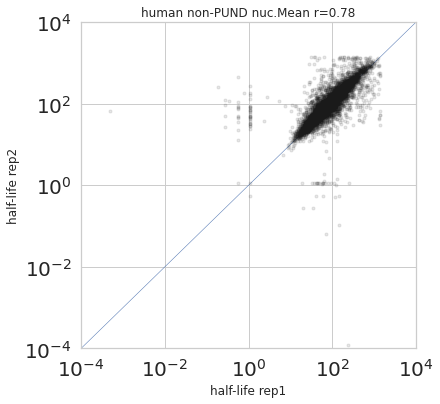

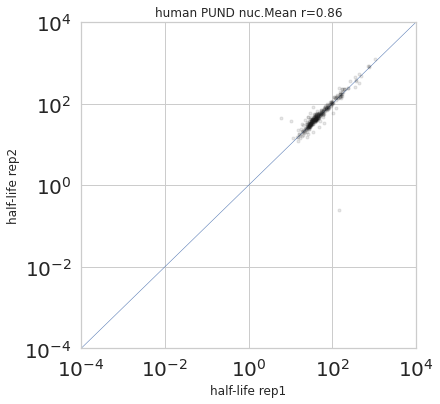

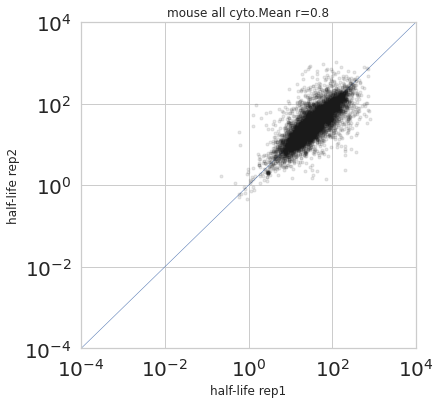

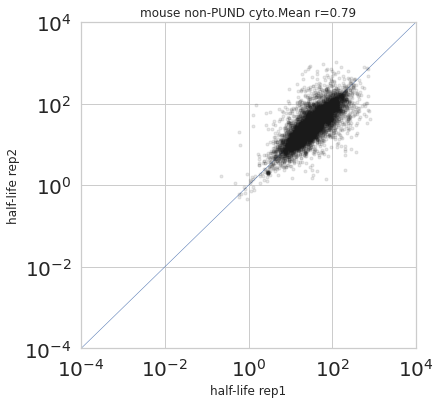

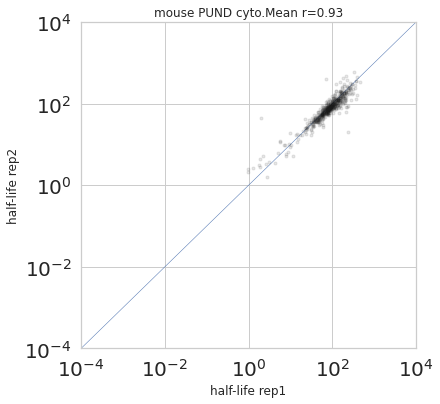

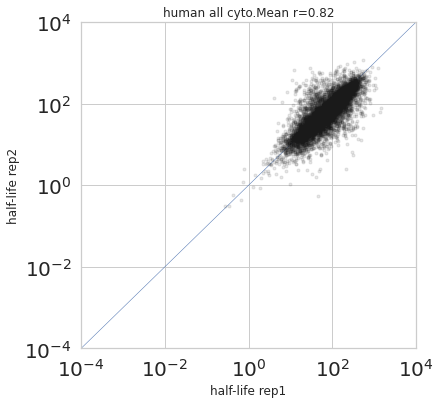

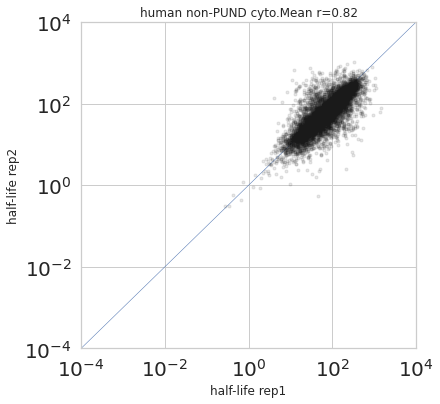

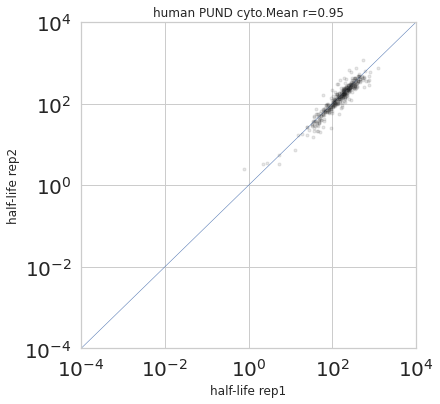

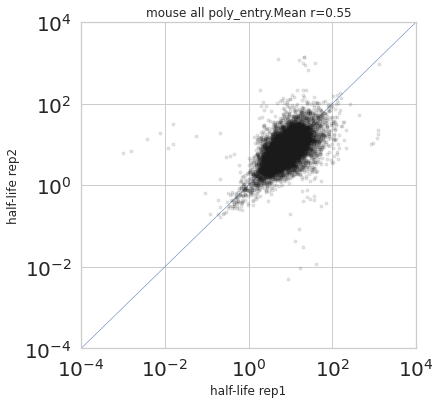

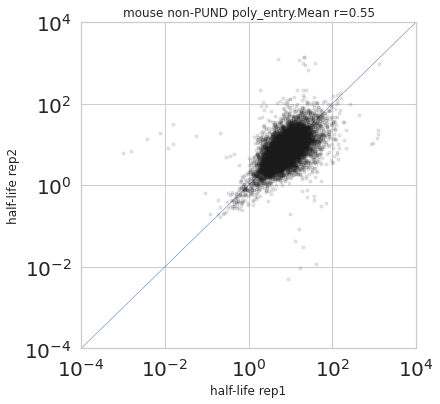

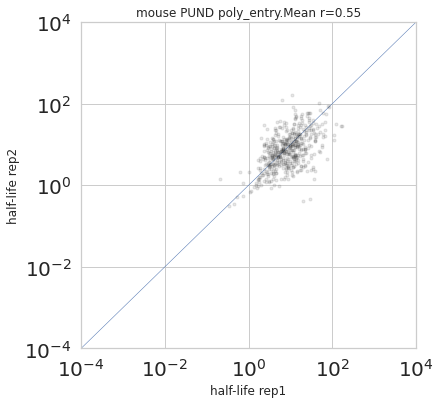

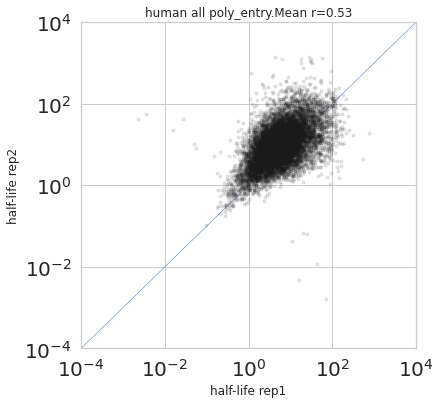

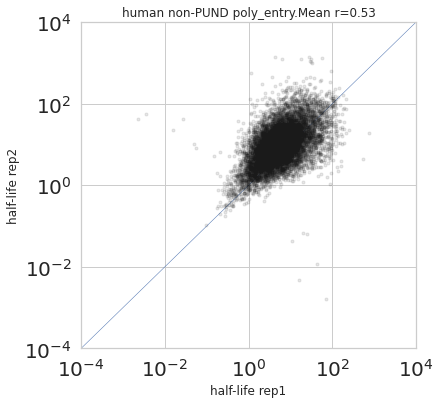

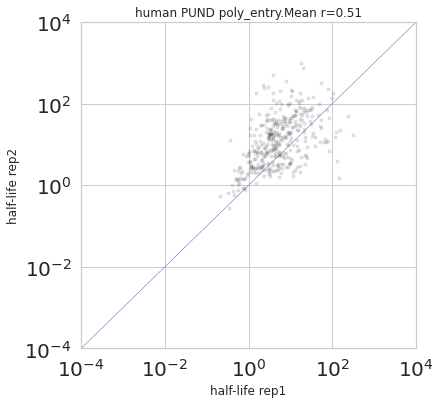

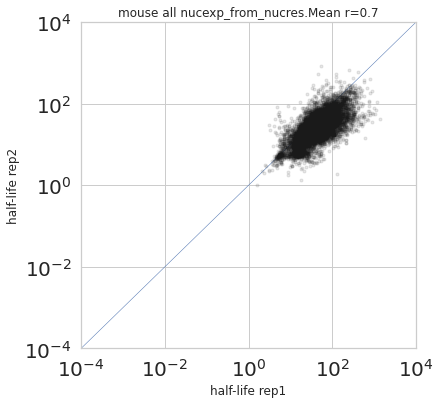

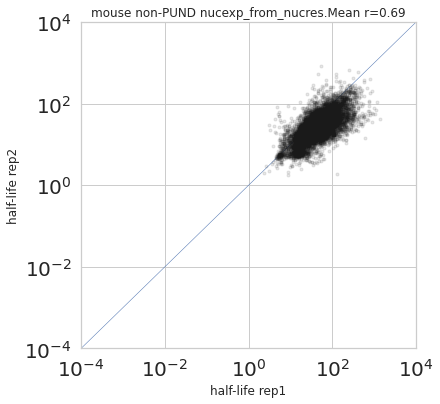

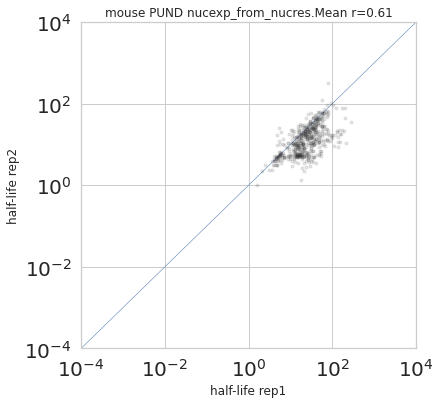

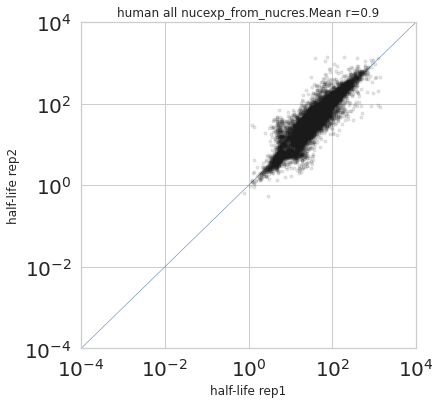

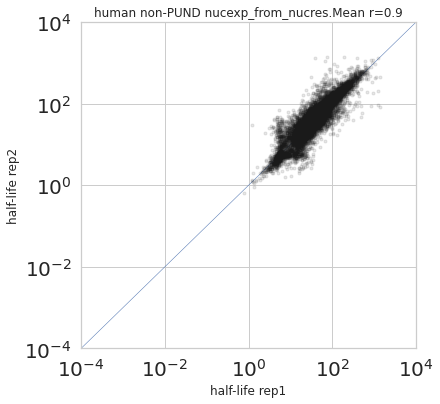

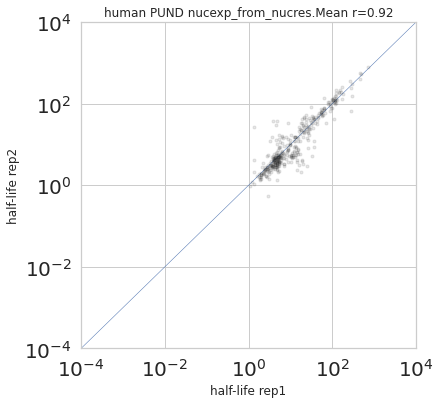

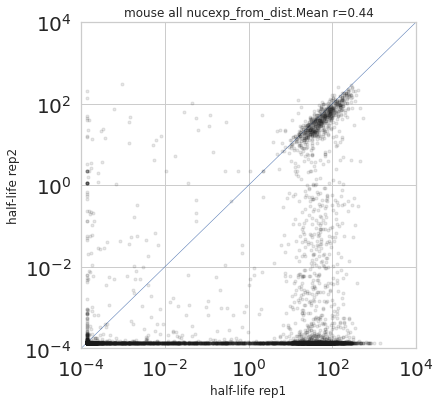

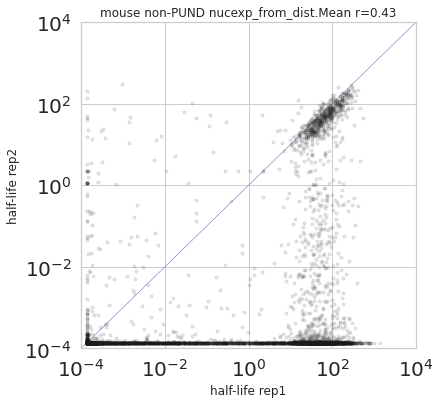

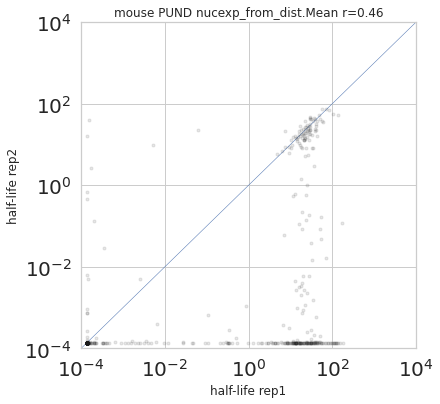

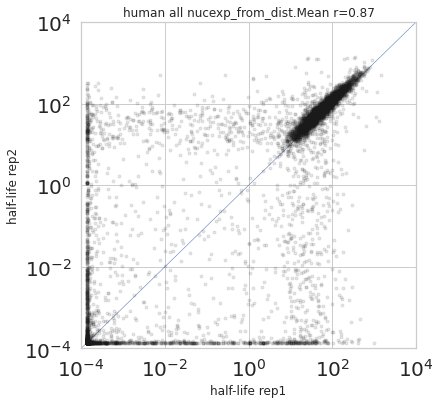

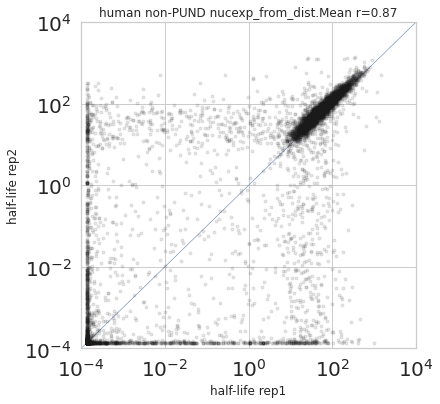

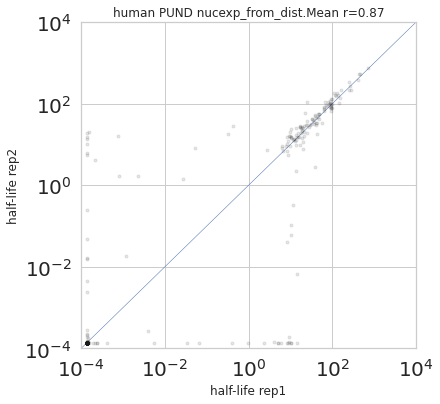

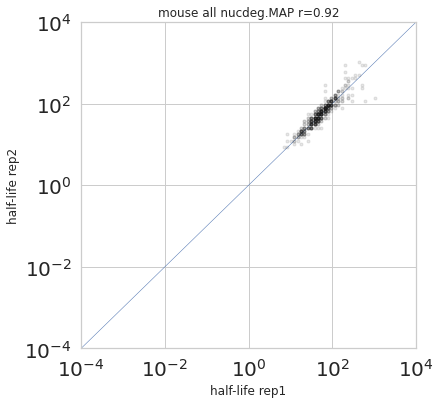

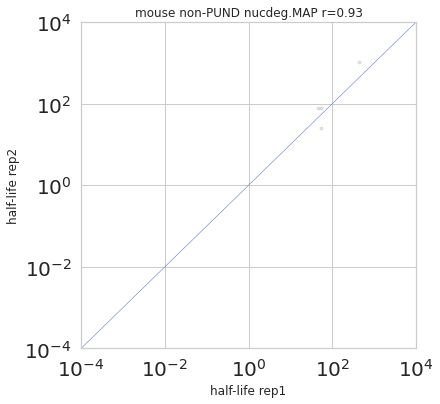

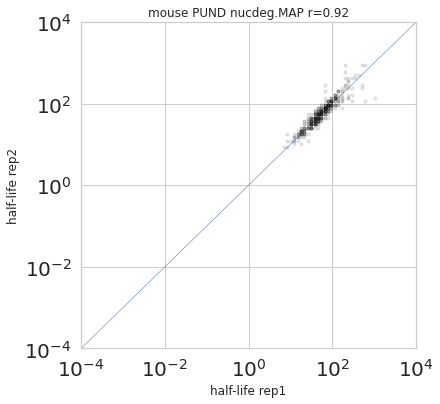

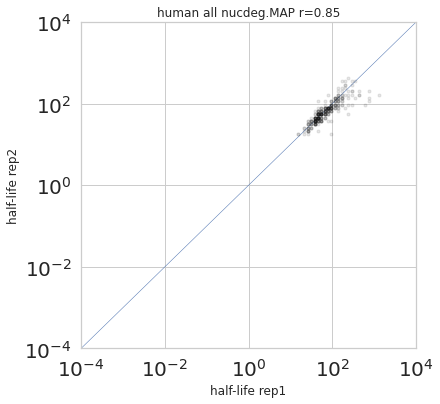

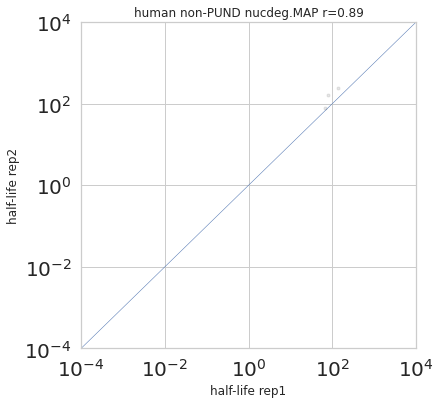

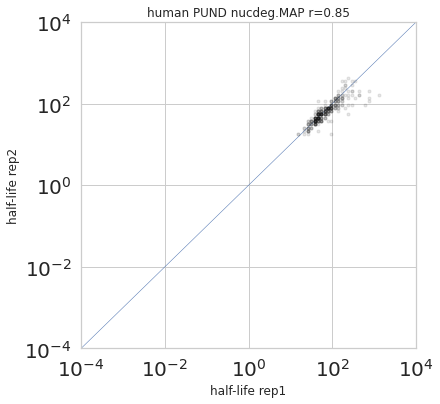

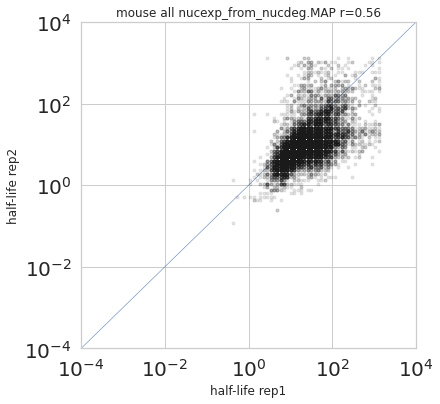

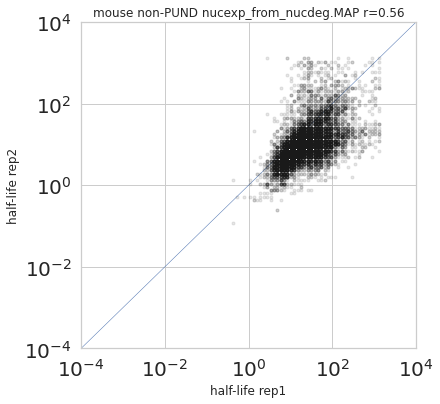

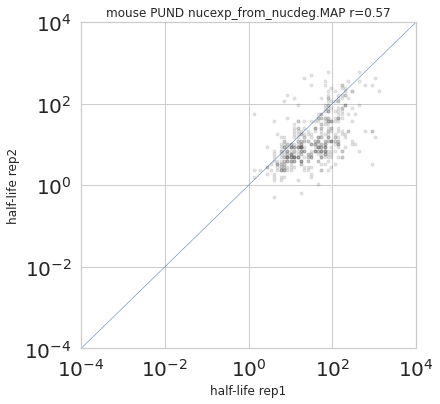

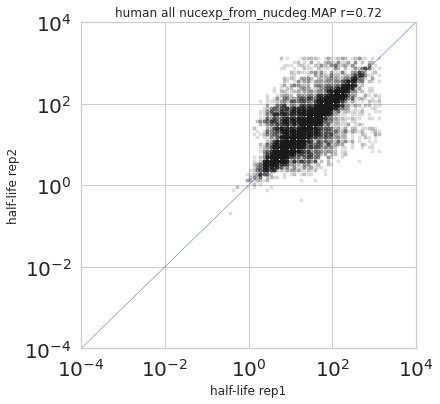

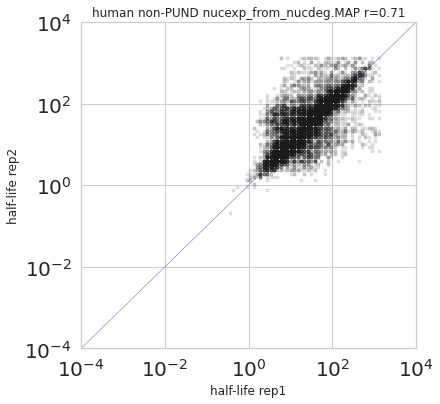

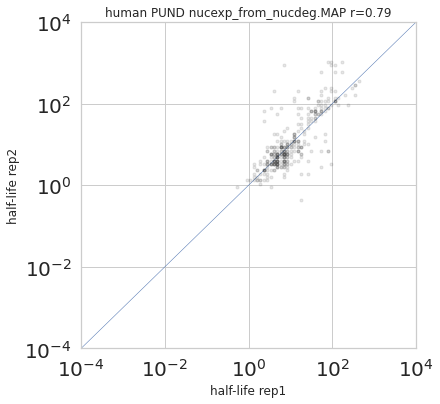

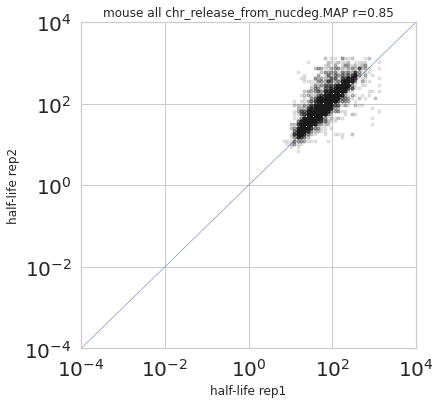

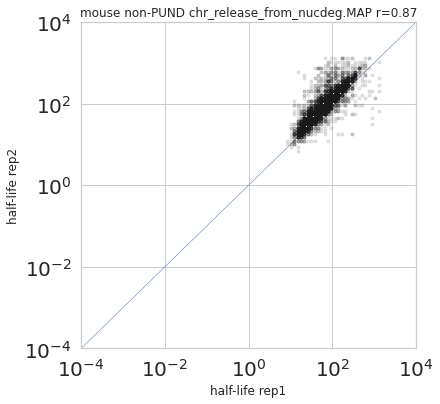

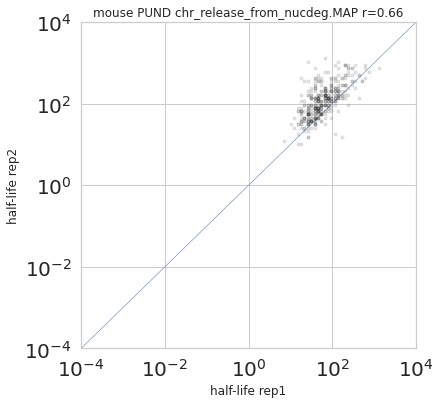

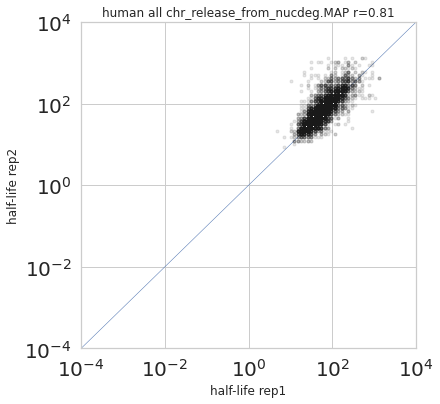

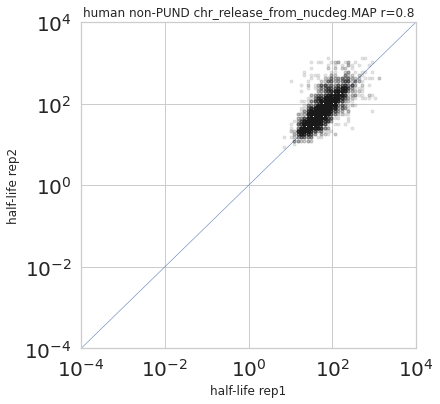

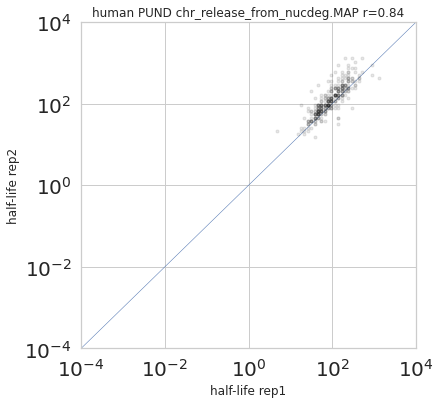

In [6]:
order10 = 4
x_range = [10**(i) for i in range(-order10, order10+2, 2)]

corrs = dict()
corrs['organism'] = []
corrs['rate'] = []
corrs['gene_type'] = []
corrs['out_type'] = []
corrs['n_genes'] = []
corrs['r_pearson'] = []#Pearson correlation
# corrs['rho_spearman'] = []#Spearman rank correlation coefficient
corrs['ci_overlap'] = []

for ts in Timescales:#Timescales_order:
    for o in organisms:
        for t in ['all', 'non-PUND', 'PUND']:
            r1 = org_red_reps[o][0]
            r2 = org_red_reps[o][1]            
            for ot in OUT_TYPES[:1]:  
                if ts in Timescales[7:]:
                    ot = '.MAP'
                if r1+'.'+ts+ot in C[o].keys():
                    if t == 'all':
                        genes = set(C[o]['Gene'])
                    elif t == 'non-PUND':
                        genes = set(C[o][(C[o]['PUND']==False) | C[o]['PUND'].isna()]['Gene'])
                    else:
                        genes = set(C[o][~C[o]['PUND'].isna() & C[o]['PUND']]['Gene'])
#                     genes = genes.intersection(set(C[o][~C[o][r1+'.'+ts+ot].isna()]['Gene']))
#                     genes = genes.intersection(set(C[o][~C[o][r2+'.'+ts+ot].isna()]['Gene']))
                    genes = genes.intersection(set(C[o][C[o][r1+'.'+ts+ot]<=24*60]['Gene']))
                    genes = genes.intersection(set(C[o][C[o][r2+'.'+ts+ot]<=24*60]['Gene']))

                    x = C[o][C[o]['Gene'].isin(genes)].sort_values(by='Gene')[r1+'.'+ts+ot].values
                    y = C[o][C[o]['Gene'].isin(genes)].sort_values(by='Gene')[r2+'.'+ts+ot].values

                    #Correlation statistics between replicates for each stat
                    Rpearson_cov = np.corrcoef(np.log(x),np.log(y))#Pearson correlation coefficient
                    Rho, pval = spearmanr(np.log(x),np.log(y))#,nan_policy='omit') #Spearman rank correlation coefficient

                    #Calculate 95%CI overlap between replicates
                    o_lo = OUT_TYPES[2]
                    o_up =  OUT_TYPES[3]
                    df = copy.deepcopy(C[o][C[o]['Gene'].isin(genes)].sort_values(by='Gene'))
                    n_all = len(df)
                    if n_all > 0:
                        n_no_overlap = \
                        len(df[((df[r1+'.'+ts+o_lo] < df[r2+'.'+ts+o_lo]) & (df[r1+'.'+ts+o_up] < df[r2+'.'+ts+o_lo]))|
                               ((df[r2+'.'+ts+o_lo] < df[r1+'.'+ts+o_lo]) & (df[r2+'.'+ts+o_up] < df[r1+'.'+ts+o_lo]))])
                        ci_overlap = round((n_all - n_no_overlap) / n_all, 2)
                    else: 
                        ci_overlap = np.nan
                    #append stats
                    corrs['r_pearson'].append(Rpearson_cov[0,1])#Pearson correlation
    #                 corrs['rho_spearman'].append(Rho)#Spearman rank correlation coefficient
                    corrs['ci_overlap'].append(ci_overlap)
                    corrs['n_genes'].append(len(x))
                    corrs['organism'].append(o)
                    corrs['rate'].append(ts)
                    corrs['out_type'].append(ot)
                    corrs['gene_type'].append(t)                  

                    sns.set(style="whitegrid")
                    fig, ax = plt.subplots(figsize=(6,6))#inches

                    plt.errorbar(x, y, fmt=".k",alpha=0.1)

                    ##TEMP mode visualization for experimental time resolution
    #                     if ts_type == 'half_life_nucexp' and t == 'non-PUND':
    #                         plt.hlines(y=mode(y)[0][0], xmin=min(x_range), xmax=max(x_range), 
    #                                    color='k', linestyle='-', linewidth=0.5)

                    plt.title(org_map[o]+' '+t+' '+ts.replace('half_life_','')+ot+' r='+
                              str(round(Rpearson_cov[0,1],2)))
                    plt.plot(x_range, x_range,'-b',linewidth=0.5)

            #                 leg.extend(['',yvar])
            #                 ax.legend(leg,loc='center left', bbox_to_anchor=(1, 0.3))

                    ax.set_xscale('log')
                    ax.set_yscale('log')

                    lim_min = min(x_range) #0.5 * min(x) #max(min(x), T_bound_lo) #min(min(x), min(y))
                    lim_max = max(x_range)#2 * max(x) #min(max(x), T_bound_hi) #max(max(x), max(y))
                    plt.xticks(x_range)
                    plt.yticks(x_range)
                    plt.xlim(lim_min, lim_max)
                    plt.ylim(lim_min, lim_max)
                    plt.xlabel('half-life rep1')
                    plt.ylabel('half-life rep2')
                    # Set tick font size
                    fs = 20
                    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
                        label.set_fontsize(fs)

                    filename = 'Comparison_'+org_map[o]+'_'+ts+ot+'_'+t+'_x'+r1+'_y'+r2+'_scat.'
                    logger.info(filename)
    #                     plt.savefig(os.path.join(path,filename+'pdf'),bbox_inches="tight",transparent=True)
    #                 plt.savefig(os.path.join(path,filename+'tiff'),bbox_inches="tight",transparent=True)
    #                 plt.savefig(os.path.join(path,filename+'png'),bbox_inches="tight",transparent=True)

corrs = pd.DataFrame.from_dict(corrs)
# filename = 'Half_lives_correlations_overlap_20240120_iii.tsv'
filename = 'Half_lives_correlations_overlap_with_24h_filter_20240120_iii.tsv'
# corrs.to_csv(os.path.join(path, filename), sep='\t',index=False)
# logger.info(corrs)

In [7]:
corrs #20240120: with 24h filter, run iii mouse all genes: 17821 human all genes: 17985

organism                               rate gene_type out_type  n_genes  \
0         m               half_life_whole_cell       all    .Mean    12019   
1         m               half_life_whole_cell  non-PUND    .Mean    11515   
2         m               half_life_whole_cell      PUND    .Mean      504   
3         h               half_life_whole_cell       all    .Mean    11503   
4         h               half_life_whole_cell  non-PUND    .Mean    11136   
5         h               half_life_whole_cell      PUND    .Mean      367   
6         m                      half_life_chr       all    .Mean    12473   
7         m                      half_life_chr  non-PUND    .Mean    11988   
8         m                      half_life_chr      PUND    .Mean      485   
9         h                      half_life_chr       all    .Mean    12100   
10        h                      half_life_chr  non-PUND    .Mean    11735   
11        h                      half_life_chr      PUND    .Mean      365   
12        m                      half_life_nuc       all    .Mean    11957   
13        m                      half_life_nuc  non-PUND    .Mean    11458   
14        m                      half_life_nuc      PUND    .Mean      499   
15        h                      half_life_nuc       all    .Mean    12561   
16        h                      half_life_nuc  non-PUND    .Mean    12227   
17        h                      half_life_nuc      PUND    .Mean      334   
18        m                     half_life_cyto       all    .Mean    11758   
19        m                     half_life_cyto  non-PUND    .Mean    11249   
20        m                     half_life_cyto      PUND    .Mean      509   
21        h                     half_life_cyto       all    .Mean    12124   
22        h                     half_life_cyto  non-PUND    .Mean    11754   
23        h                     half_life_cyto      PUND    .Mean      370   
24        m               half_life_poly_entry       all    .Mean    10571   
25        m               half_life_poly_entry  non-PUND    .Mean    10074   
26        m               half_life_poly_entry      PUND    .Mean      497   
27        h               half_life_poly_entry       all    .Mean    10663   
28        h               half_life_poly_entry  non-PUND    .Mean    10293   
29        h               half_life_poly_entry      PUND    .Mean      370   
30        m       half_life_nucexp_from_nucres       all    .Mean    12041   
31        m       half_life_nucexp_from_nucres  non-PUND    .Mean    11533   
32        m       half_life_nucexp_from_nucres      PUND    .Mean      508   
33        h       half_life_nucexp_from_nucres       all    .Mean    12032   
34        h       half_life_nucexp_from_nucres  non-PUND    .Mean    11665   
35        h       half_life_nucexp_from_nucres      PUND    .Mean      367   
36        m         half_life_nucexp_from_dist       all    .Mean    12025   
37        m         half_life_nucexp_from_dist  non-PUND    .Mean    11516   
38        m         half_life_nucexp_from_dist      PUND    .Mean      509   
39        h         half_life_nucexp_from_dist       all    .Mean    11974   
40        h         half_life_nucexp_from_dist  non-PUND    .Mean    11608   
41        h         half_life_nucexp_from_dist      PUND    .Mean      366   
42        m                   half_life_nucdeg       all     .MAP      459   
43        m                   half_life_nucdeg  non-PUND     .MAP        4   
44        m                   half_life_nucdeg      PUND     .MAP      455   
45        h                   half_life_nucdeg       all     .MAP      316   
46        h                   half_life_nucdeg  non-PUND     .MAP        3   
47        h                   half_life_nucdeg      PUND     .MAP      313   
48        m       half_life_nucexp_from_nucdeg       all     .MAP    10630   
49        m       half_life_nucexp_from_nucdeg  non-PUND     .MAP    10181   
50        m       half_li

In [5]:
corrs #20240120: run iii mouse all genes: 17821 human all genes: 17985

organism                               rate gene_type out_type  n_genes  \
0         m               half_life_whole_cell       all    .Mean    12108   
1         m               half_life_whole_cell  non-PUND    .Mean    11599   
2         m               half_life_whole_cell      PUND    .Mean      509   
3         h               half_life_whole_cell       all    .Mean    11641   
4         h               half_life_whole_cell  non-PUND    .Mean    11270   
5         h               half_life_whole_cell      PUND    .Mean      371   
6         m                      half_life_chr       all    .Mean    12683   
7         m                      half_life_chr  non-PUND    .Mean    12174   
8         m                      half_life_chr      PUND    .Mean      509   
9         h                      half_life_chr       all    .Mean    12161   
10        h                      half_life_chr  non-PUND    .Mean    11790   
11        h                      half_life_chr      PUND    .Mean      371   
12        m                      half_life_nuc       all    .Mean    12062   
13        m                      half_life_nuc  non-PUND    .Mean    11553   
14        m                      half_life_nuc      PUND    .Mean      509   
15        h                      half_life_nuc       all    .Mean    12873   
16        h                      half_life_nuc  non-PUND    .Mean    12502   
17        h                      half_life_nuc      PUND    .Mean      371   
18        m                     half_life_cyto       all    .Mean    11763   
19        m                     half_life_cyto  non-PUND    .Mean    11254   
20        m                     half_life_cyto      PUND    .Mean      509   
21        h                     half_life_cyto       all    .Mean    12130   
22        h                     half_life_cyto  non-PUND    .Mean    11759   
23        h                     half_life_cyto      PUND    .Mean      371   
24        m               half_life_poly_entry       all    .Mean    11067   
25        m               half_life_poly_entry  non-PUND    .Mean    10560   
26        m               half_life_poly_entry      PUND    .Mean      507   
27        h               half_life_poly_entry       all    .Mean    11060   
28        h               half_life_poly_entry  non-PUND    .Mean    10689   
29        h               half_life_poly_entry      PUND    .Mean      371   
30        m       half_life_nucexp_from_nucres       all    .Mean    12046   
31        m       half_life_nucexp_from_nucres  non-PUND    .Mean    11537   
32        m       half_life_nucexp_from_nucres      PUND    .Mean      509   
33        h       half_life_nucexp_from_nucres       all    .Mean    12075   
34        h       half_life_nucexp_from_nucres  non-PUND    .Mean    11706   
35        h       half_life_nucexp_from_nucres      PUND    .Mean      369   
36        m         half_life_nucexp_from_dist       all    .Mean    12029   
37        m         half_life_nucexp_from_dist  non-PUND    .Mean    11520   
38        m         half_life_nucexp_from_dist      PUND    .Mean      509   
39        h         half_life_nucexp_from_dist       all    .Mean    12023   
40        h         half_life_nucexp_from_dist  non-PUND    .Mean    11653   
41        h         half_life_nucexp_from_dist      PUND    .Mean      370   
42        m                   half_life_nucdeg       all     .MAP      480   
43        m                   half_life_nucdeg  non-PUND     .MAP        5   
44        m                   half_life_nucdeg      PUND     .MAP      475   
45        h                   half_life_nucdeg       all     .MAP      350   
46        h                   half_life_nucdeg  non-PUND     .MAP        9   
47        h                   half_life_nucdeg      PUND     .MAP      341   
48        m       half_life_nucexp_from_nucdeg       all     .MAP    11084   
49        m       half_life_nucexp_from_nucdeg  non-PUND     .MAP    10607   
50        m       half_li

### Get population statistics for MS main section

In [76]:
# list(C[o].keys())
C[o].head()

Gene    Symbol  T.half_life_chr.Mean  T.half_life_chr.MAP  \
0  ENSG00000000003    TSPAN6                   NaN                  NaN   
1  ENSG00000000005      TNMD                   NaN                  NaN   
2  ENSG00000000419      DPM1             49.863467            50.429809   
3  ENSG00000000457     SCYL3             23.519231            23.678762   
4  ENSG00000000460  C1orf112             87.925812            87.685456   

   T.half_life_chr.0.025.quantile  T.half_life_chr.0.975.quantile  \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                       40.419527                       62.919233   
3                       20.057967                       27.953170   
4                       81.450833                       94.397305   

   T.half_life_nuc.Mean  T.half_life_nuc.MAP  T.half_life_nuc.0.025.quantile  \
0                   NaN                  NaN                             NaN   
1                   NaN                  NaN                             NaN   
2            178.727337           179.986477                      155.301558   
3             30.074584            30.092835                       27.442461   
4            149.355139           149.678629                      139.036160   

   T.half_life_nuc.0.975.quantile  T.half_life_nucexp_from_nucres.Mean  \
0                             NaN                                  NaN   
1                             NaN                                  NaN   
2                      208.595022                           144.606658   
3                       32.999179                            12.612441   
4                      161.135721                            81.191949   

   T.half_life_nucexp_from_nucres.MAP  \
0                                 NaN   
1                                 NaN   
2                          146.943976   
3                           16.375661   
4                           82.966647   

   T.half_life_nucexp_from_nucres.0.025.quantile  \
0                                            NaN   
1                                            NaN   
2                                     117.775699   
3                                       5.724564   
4                                      68.995928   

   T.half_life_nucexp_from_nucres.0.975.quantile  \
0                                            NaN   
1                                            NaN   
2                                     176.698095   
3                                      20.057967   
4                                      96.154055   

   T.half_life_nucexp_from_dist.Mean  T.half_life_nucexp_from_dist.MAP  \
0                                NaN                               NaN   
1                                NaN                               NaN   
2                         126.453839                        129.150393   
3                           0.000139                          6.634473   
4                          60.166356                         61.769688   

   T.half_life_nucexp_from_dist.0.025.quantile  \
0                                          NaN   
1                                          NaN   
2                                   101.622910   
3                                     0.000071   
4                                    49.508448   

   T.half_life_nucexp_from_dist.0.975.quantile  T.half_life_cyto.Mean  \
0                                          NaN                    NaN   
1                                          NaN                    NaN   
2                                   158.191746             156.342716   
3                                     0.002927              47.138138   
4                                    72.920138             207.889942   

   T.half_life_cyto.MAP  T.half_life_cyto.0.025.quantile  \
0                   NaN                              NaN   
1                   NaN                     

In [5]:
corrs = dict()
corrs['organism'] = []
corrs['replicate'] = []
corrs['rate'] = []
corrs['gene_type'] = []
corrs['out_type'] = []
corrs['n_genes'] = []
corrs['median'] = []
corrs['q05'] = []
corrs['q95'] = []
corrs['q75'] = []

for ts in Timescales_all:
    for o in organisms:
        for rr in org_red_reps[o]:
                for t in ['all', 'non-PUND', 'PUND']:
                    for ot in OUT_TYPES[:2]:
                        if rr+'.'+ts+ot in C[o].keys():
                            if t == 'all':
                                genes = set(C[o]['Gene'])
                            elif t == 'non-PUND':
                                genes = set(C[o][(C[o]['PUND']==False) | C[o]['PUND'].isna()]['Gene'])
                            else:
                                genes = set(C[o][~C[o]['PUND'].isna() & C[o]['PUND']]['Gene'])
                            genes = genes.intersection(set(C[o][~C[o][rr+'.'+ts+ot].isna()]['Gene']))

                            x = C[o][C[o]['Gene'].isin(genes)][rr+'.'+ts+ot]
                            #append stats
                            corrs['organism'].append(o)
                            corrs['replicate'].append(rr)
                            corrs['rate'].append(ts)
                            corrs['gene_type'].append(t) 
                            corrs['out_type'].append(ot)  
                            corrs['n_genes'].append(len(x))
                            med = np.median(x)
                            corrs['median'].append(med)
                            qq = np.quantile(x,0.05)
                            corrs['q05'].append(qq)
                            qq = np.quantile(x,0.95)
                            corrs['q95'].append(qq)
                            qq = np.quantile(x,0.75)
                            corrs['q75'].append(qq)                                        
corrs = pd.DataFrame.from_dict(corrs)
filename = 'Half_lives_replicate_population_stats.tsv'
# corrs.to_csv(os.path.join(path, filename), sep='\t',index=False)
corrs

organism replicate                               rate gene_type out_type  \
0          m       G_R               half_life_whole_cell       all    .Mean   
1          m       G_R               half_life_whole_cell       all     .MAP   
2          m       G_R               half_life_whole_cell  non-PUND    .Mean   
3          m       G_R               half_life_whole_cell  non-PUND     .MAP   
4          m       G_R               half_life_whole_cell      PUND    .Mean   
5          m       G_R               half_life_whole_cell      PUND     .MAP   
6          m       H_S               half_life_whole_cell       all    .Mean   
7          m       H_S               half_life_whole_cell       all     .MAP   
8          m       H_S               half_life_whole_cell  non-PUND    .Mean   
9          m       H_S               half_life_whole_cell  non-PUND     .MAP   
10         m       H_S               half_life_whole_cell      PUND    .Mean   
11         m       H_S               half_life_whole_cell      PUND     .MAP   
12         h         T               half_life_whole_cell       all    .Mean   
13         h         T               half_life_whole_cell       all     .MAP   
14         h         T               half_life_whole_cell  non-PUND    .Mean   
15         h         T               half_life_whole_cell  non-PUND     .MAP   
16         h         T               half_life_whole_cell      PUND    .Mean   
17         h         T               half_life_whole_cell      PUND     .MAP   
18         h         U               half_life_whole_cell       all    .Mean   
19         h         U               half_life_whole_cell       all     .MAP   
20         h         U               half_life_whole_cell  non-PUND    .Mean   
21         h         U               half_life_whole_cell  non-PUND     .MAP   
22         h         U               half_life_whole_cell      PUND    .Mean   
23         h         U               half_life_whole_cell      PUND     .MAP   
24         m       G_R                      half_life_chr       all    .Mean   
25         m       G_R                      half_life_chr       all     .MAP   
26         m       G_R                      half_life_chr  non-PUND    .Mean   
27         m       G_R                      half_life_chr  non-PUND     .MAP   
28         m       G_R                      half_life_chr      PUND    .Mean   
29         m       G_R                      half_life_chr      PUND     .MAP   
30         m       H_S                      half_life_chr       all    .Mean   
31         m       H_S                      half_life_chr       all     .MAP   
32         m       H_S                      half_life_chr  non-PUND    .Mean   
33         m       H_S                      half_life_chr  non-PUND     .MAP   
34         m       H_S                      half_life_chr      PUND    .Mean   
35         m       H_S                      half_life_chr      PUND     .MAP   
36         h         T                      half_life_chr       all    .Mean   
37         h         T                      half_life_chr       all     .MAP   
38         h         T                      half_life_chr  non-PUND    .Mean   
39         h         T                      half_life_chr  non-PUND     .MAP   
40         h         T                      half_life_chr      PUND    .Mean   
41         h         T                      half_life_chr      PUND     .MAP   
42         h         U                      half_life_chr       all    .Mean   
43         h         U                      half_life_chr       all     .MAP   
44         h         U                      half_life_chr  non-PUND    .Mean   
45         h         U                      half_life_chr  non-PUND     .MAP   
46         h         U                      half_life_chr      PUND    .Mean   
47         h         U                      half_life_chr      PUND     .MAP   
48         m       G_R                      half_life_nuc       all    .Mean   
49  

### For graphical abstract and MS text section

In [78]:
ot = OUT_TYPES[0]
o = 'h'
logger.info(o)
for ts in Timescales_all:
    logger.info('%s %s' % (o,ts))
    logger.info(corrs[(corrs['out_type']==ot) & (corrs['gene_type']=='all') & 
          (corrs['organism']==o) & (corrs['rate']==ts)][['median','q05','q95']].mean())
o = 'm'
logger.info(o)
for ts in Timescales_all:
    logger.info('%s %s' % (o,ts))
    logger.info(corrs[(corrs['out_type']==ot) & (corrs['gene_type']=='all') & 
          (corrs['organism']==o) & (corrs['rate']==ts)][['median','q05','q95']].mean())

INFO: [2024-05-26 21:07:40] Function - h
INFO: [2024-05-26 21:07:40] Function - h half_life_whole_cell
INFO: [2024-05-26 21:07:41] Function - median    198.709138
q05        48.330098
q95       751.326725
dtype: float64
INFO: [2024-05-26 21:07:41] Function - h half_life_chr
INFO: [2024-05-26 21:07:41] Function - median     49.820090
q05        21.042513
q95       165.260913
dtype: float64
INFO: [2024-05-26 21:07:41] Function - h half_life_nuc
INFO: [2024-05-26 21:07:41] Function - median     78.914586
q05        25.853205
q95       400.537438
dtype: float64
INFO: [2024-05-26 21:07:41] Function - h half_life_cyto
INFO: [2024-05-26 21:07:41] Function - median     74.915580
q05        14.302169
q95       270.597324
dtype: float64
INFO: [2024-05-26 21:07:41] Function - h half_life_poly_entry
INFO: [2024-05-26 21:07:41] Function - median     8.082094
q05        1.387067
q95       82.308683
dtype: float64
INFO: [2024-05-26 21:07:41] Function - h half_life_nucexp_from_nucres
INFO: [2024-05-26

In [6]:
ot = OUT_TYPES[1]
o = 'h'
logger.info(o)
ts = 'half_life_nucdeg'
logger.info('%s %s' % (o,ts))
logger.info(corrs[(corrs['out_type']==ot) & (corrs['gene_type']=='PUND') & 
      (corrs['organism']==o) & (corrs['rate']==ts)][['median','q05','q95']].mean())
o = 'm'
logger.info(o)
logger.info('%s %s' % (o,ts))
logger.info(corrs[(corrs['out_type']==ot) & (corrs['gene_type']=='PUND') & 
      (corrs['organism']==o) & (corrs['rate']==ts)][['median','q05','q95']].mean())

INFO: [2024-05-27 11:43:34] Function - h
INFO: [2024-05-27 11:43:34] Function - h half_life_nucdeg
INFO: [2024-05-27 11:43:34] Function - median      66.164257
q05         26.096546
q95       5112.241237
dtype: float64
INFO: [2024-05-27 11:43:34] Function - m
INFO: [2024-05-27 11:43:34] Function - m half_life_nucdeg
INFO: [2024-05-27 11:43:34] Function - median      60.547493
q05         17.987337
q95       1905.083808
dtype: float64


In [82]:
## For abstract: average medians over human and mouse if they are close together
# Otherwise report separately

In [7]:
# for ts in Timescales_all:
#     logger.info(ts)
#     logger.info(corrs[(corrs['out_type']==ot) & (corrs['gene_type']=='all') & 
#            (corrs['rate']==ts)][['median']])
#     logger.info('h+m')
#     logger.info(    logger.info(corrs[(corrs['out_type']==ot) & (corrs['gene_type']=='all') & 
#            (corrs['rate']==ts)][['median']].mean()))

### Figure S4D: correlation between nucexp_from_nucres and nucexp_from_dist

INFO: [2024-02-02 11:56:33] Function - 0.9429830848133982
INFO: [2024-02-02 11:56:33] Function - 10970
INFO: [2024-02-02 11:56:33] Function - h
INFO: [2024-02-02 11:56:33] Function - .MAP
INFO: [2024-02-02 11:56:33] Function - non-PUND
INFO: [2024-02-02 11:56:33] Function - Comparison_human_T.MAP_non-PUND_xhalf_life_nucexp_from_dist_yhalf_life_nucexp_from_nucres_scat.
INFO: [2024-02-02 11:56:37] Function - 0.9489413452303935
INFO: [2024-02-02 11:56:37] Function - 10932
INFO: [2024-02-02 11:56:37] Function - h
INFO: [2024-02-02 11:56:37] Function - .MAP
INFO: [2024-02-02 11:56:37] Function - non-PUND
INFO: [2024-02-02 11:56:37] Function - Comparison_human_U.MAP_non-PUND_xhalf_life_nucexp_from_dist_yhalf_life_nucexp_from_nucres_scat.


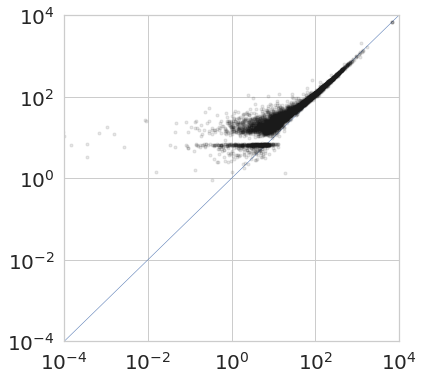

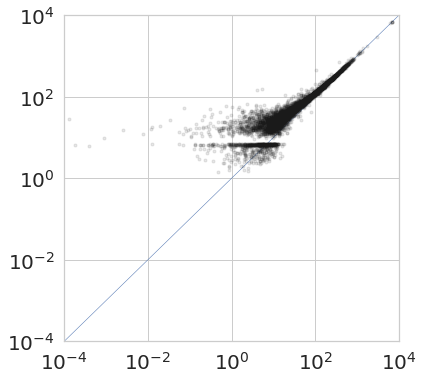

In [20]:
order10 = 4
x_range = [10**(i) for i in range(-order10, order10+2, 2)]

ts1 ='half_life_nucexp_from_dist'
ts2 ='half_life_nucexp_from_nucres'

o='h'
ot='.MAP'
t='non-PUND'
for rr in org_red_reps[o]: 
    if rr+'.'+ts+ot in C[o].keys():
#         genes = set(C[o][(C[o]['PUND']==False) | C[o]['PUND'].isna()]['Gene'])
        genes = set(C[o][C[o]['PUND']==False]['Gene'])
        genes = genes.intersection(set(C[o][~C[o][rr+'.'+ts1+ot].isna()]['Gene']))
        genes = genes.intersection(set(C[o][~C[o][rr+'.'+ts2+ot].isna()]['Gene']))

        x = C[o][C[o]['Gene'].isin(genes)].sort_values(by='Gene')[rr+'.'+ts1+ot].values
        y = C[o][C[o]['Gene'].isin(genes)].sort_values(by='Gene')[rr+'.'+ts2+ot].values

        #Correlation statistics between replicates for each stat
#         Rpearson_cov = np.corrcoef(np.log(x),np.log(y))#Pearson correlation coefficient
        Rho, pval = spearmanr(np.log(x),np.log(y))#,nan_policy='omit') #Spearman rank correlation coefficient

        #append stats
#             logger.info(Rpearson_cov[0,1])#Pearson correlation
        logger.info(Rho)#Spearman rank correlation coefficient
        logger.info(len(x))
        logger.info(o)
        logger.info(ot)
        logger.info(t)                  

        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6,6))#inches

        plt.errorbar(x, y, fmt=".k",alpha=0.1)

#         plt.title(org_map[o]+' '+t+' '+ts.replace('half_life_','')+ot+' r='+
                  #str(round(Rpearson_cov[0,1],2)))
        plt.plot(x_range, x_range,'-b',linewidth=0.5)

        ax.set_xscale('log')
        ax.set_yscale('log')

        lim_min = min(x_range) 
        lim_max = max(x_range)
        plt.xticks(x_range)
        plt.yticks(x_range)
        plt.xlim(lim_min, lim_max)
        plt.ylim(lim_min, lim_max)
#         plt.xlabel('half-life rep1')
#         plt.ylabel('half-life rep2')
        # Set tick font size
        fs = 20
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fs)

        filename = 'Comparison_'+org_map[o]+'_'+rr+ot+'_'+t+'_x'+ts1+'_y'+ts2+'_scat.'
        logger.info(filename)
        plt.savefig(os.path.join(path,filename+'pdf'),bbox_inches="tight",transparent=True)
#         plt.savefig(os.path.join(path,filename+'tiff'),bbox_inches="tight",transparent=True)
#         plt.savefig(os.path.join(path,filename+'png'),bbox_inches="tight",transparent=True)



### Bayes Factor undetermined stats

In [38]:
DE = dict()

filename = '3T3_de_results.txt'
DE['m'] = pd.read_csv(os.path.join(path, filename), sep='\t')
filename = 'K562_de_results.txt'
DE['h'] = pd.read_csv(os.path.join(path, filename), sep='\t')

In [39]:
o = 'h'
for o in organisms:
    logger.info(o)
    data_cols = K[o].columns[3:]

    genes_w_calc = K[o][~K[o][data_cols].isna().all(axis=1)]
    n_genes_w_calc = len(genes_w_calc)
    logger.info(n_genes_w_calc)
    n_genes_w_bf = len(K[o][~K[o]['PUND'].isna()])
    logger.info(n_genes_w_bf)
    
    genes_undetermined = genes_w_calc[genes_w_calc['PUND'].isna()]
    genes_undetermined = genes_undetermined[ 
        ((genes_w_calc[org_red_reps[o][0]+'.likelihood_nucres_4']==0) & 
         (genes_w_calc[org_red_reps[o][0]+'.likelihood_nucdeg_4']==0)) |
        ((genes_w_calc[org_red_reps[o][1]+'.likelihood_nucres_4']==0) & 
         (genes_w_calc[org_red_reps[o][1]+'.likelihood_nucdeg_4']==0)) ]
    n_undetermined = len(genes_undetermined)
    logger.info(n_undetermined)

INFO: [2024-03-14 12:45:06] Function - m
INFO: [2024-03-14 12:45:06] Function - 12010
INFO: [2024-03-14 12:45:06] Function - 11667
/n/groups/churchman/ri23/code/RNAdecayenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
INFO: [2024-03-14 12:45:06] Function - 38
INFO: [2024-03-14 12:45:06] Function - h
INFO: [2024-03-14 12:45:06] Function - 12007
INFO: [2024-03-14 12:45:06] Function - 11409
INFO: [2024-03-14 12:45:06] Function - 165


In [20]:
genes_undetermined

Gene        Symbol PUND  T.bayes_factor_4  \
213    ENSG00000008988         RPS20  NaN               NaN   
214    ENSG00000009307         CSDE1  NaN               NaN   
273    ENSG00000011304         PTBP1  NaN               NaN   
447    ENSG00000029363        BCLAF1  NaN               NaN   
805    ENSG00000062716          VMP1  NaN               NaN   
809    ENSG00000063046         EIF4B  NaN               NaN   
813    ENSG00000063177         RPL18  NaN               NaN   
871    ENSG00000065150          IPO5  NaN      1.016198e-07   
1019   ENSG00000069275        NUCKS1  NaN      0.000000e+00   
1072   ENSG00000070756        PABPC1  NaN               NaN   
1090   ENSG00000071082         RPL31  NaN               NaN   
1215   ENSG00000074800          ENO1  NaN               NaN   
1255   ENSG00000075624          ACTB  NaN               NaN   
1435   ENSG00000080824      HSP90AA1  NaN               NaN   
1533   ENSG00000083845          RPS5  NaN               NaN   
1636   ENSG00000087086           FTL  NaN               NaN   
1720   ENSG00000089009          RPL6  NaN               NaN   
1737   ENSG00000089157         RPLP0  NaN               NaN   
1804   ENSG00000090621        PABPC4  NaN               NaN   
1874   ENSG00000092199        HNRNPC  NaN               NaN   
1963   ENSG00000096384      HSP90AB1  NaN               NaN   
2032   ENSG00000099901        RANBP1  NaN               NaN   
2038   ENSG00000099942          CRKL  NaN               NaN   
2154   ENSG00000100316          RPL3  NaN               NaN   
2422   ENSG00000101558          VAPA  NaN      3.001180e-09   
2606   ENSG00000103035         PSMD7  NaN      7.451618e-08   
2819   ENSG00000104824        HNRNPL  NaN               NaN   
2849   ENSG00000104904          OAZ1  NaN               NaN   
2894   ENSG00000105193         RPS16  NaN               NaN   
2992   ENSG00000105640        RPL18A  NaN               NaN   
3082   ENSG00000106028         SSBP1  NaN      1.294636e-02   
3326   ENSG00000108298         RPL19  NaN               NaN   
3345   ENSG00000108424         KPNB1  NaN               NaN   
3518   ENSG00000109971         HSPA8  NaN               NaN   
3558   ENSG00000110321        EIF4G2  NaN               NaN   
3622   ENSG00000110955       ATP5F1B  NaN               NaN   
3695   ENSG00000111640         GAPDH  NaN               NaN   
3776   ENSG00000112081         SRSF3  NaN               NaN   
3816   ENSG00000112306         RPS12  NaN               NaN   
3896   ENSG00000113013         HSPA9  NaN               NaN   
4036   ENSG00000114391         RPL24  NaN               NaN   
4089   ENSG00000114857          NKTR  NaN      7.841000e+24   
4110   ENSG00000115053           NCL  NaN               NaN   
4220   ENSG00000115758          ODC1  NaN               NaN   
4293   ENSG00000116251         RPL22  NaN               NaN   
4472   ENSG00000117632         STMN1  NaN               NaN   
4605   ENSG00000119335           SET  NaN               NaN   
4756   ENSG00000120438          TCP1  NaN               NaN   
4799   ENSG00000120802          TMPO  NaN               NaN   
4944   ENSG00000122406          RPL5  NaN               NaN   
5057   ENSG00000123416        TUBA1B  NaN               NaN   
5129   ENSG00000124172       ATP5F1E  NaN      2.285456e+16   
5211   ENSG00000124614         RPS10  NaN               NaN   
5325   ENSG00000125691         RPL23  NaN               inf   
5386   ENSG00000125944        HNRNPR  NaN               NaN   
5488   ENSG00000126883        NUP214  NaN               NaN   
5532   ENSG00000127481          UBR4  NaN               NaN   
6128   ENSG00000132341           RAN  NaN               NaN   
6155   ENSG00000132475         H3-3B  NaN      1.176975e-09   
6413   ENSG00000134333          LDHA  NaN               NaN   
6425   ENSG00000134419        RPS15A  NaN               NaN   
6564   ENSG00000135316       SYNCRIP  NaN               NaN   
6580   ENSG00000135387       CAPRIN1  NaN        

In [40]:
N_all_genes = n_genes_w_calc
N_RPG_genes = len(genes_w_calc[genes_w_calc['Gene'].isin(rpg_w_times['Ensembl gene ID'])])
N_RPG_undetermined = len(genes_undetermined[genes_undetermined['Gene'].isin(rpg_w_times['Ensembl gene ID'])])

logger.info('%d %d %d %d' % (n_genes_w_calc,
                             n_undetermined,
                             N_RPG_genes,
                             N_RPG_undetermined))
cont_table = get_contingency_table(n_genes_w_calc,
                                   n_undetermined,
                                   N_RPG_genes,
                                   N_RPG_undetermined) 
OR , pval = fisher_exact(cont_table)
logger.info('Fisher Exact odds ratio %f pvalue %s' % (OR,f"{pval:.2e}"))

INFO: [2024-03-14 12:45:16] Function - 12007 165 87 49
INFO: [2024-03-14 12:45:16] Function - Fisher Exact odds ratio 131.215064 pvalue 1.04e-70


In [41]:
alpha_padj = 0.01

DE_genes = set(DE[o][DE[o]['padj']<alpha_padj]['Gene'])
N_DE_genes = len(genes_w_calc[genes_w_calc['Gene'].isin(DE_genes)])
N_DE_undetermined = len(genes_undetermined[genes_undetermined['Gene'].isin(DE_genes)])

logger.info('%d %d %d %d' % (n_genes_w_calc,
                             n_undetermined,
                             N_DE_genes,
                             N_DE_undetermined))
cont_table = get_contingency_table(n_genes_w_calc,
                                   n_undetermined,
                                   N_DE_genes,
                                   N_DE_undetermined) 
OR , pval = fisher_exact(cont_table)
logger.info('Fisher Exact odds ratio %f pvalue %s' % (OR,f"{pval:.2e}"))

INFO: [2024-03-14 12:45:18] Function - 12007 165 1175 36
INFO: [2024-03-14 12:45:18] Function - Fisher Exact odds ratio 2.622374 pvalue 3.72e-06


In [33]:
1-165/12007

0.9862580161572416

In [35]:
DE[o].head()

Gene    baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0  ENSG00000157933  506.918609        0.077219  0.223176  0.346002  0.729341   
1  ENSG00000157870   77.689551        0.123762  0.444918  0.278168  0.780884   
2  ENSG00000130762    1.757954        0.810717  2.624537  0.308899  0.757398   
3  ENSG00000158109   50.385887        0.237574  0.545337  0.435647  0.663093   
4  ENSG00000078900    8.674992       -2.772981  1.337616 -2.073077  0.038165   

       padj  rep1_UL  rep1_4sU  rep2_UL  rep2_4sU   Comp  
0  0.950428      264       939      658       405  Total  
1       NaN       45       128       87        71  Total  
2       NaN        1         6        1         1  Total  
3       NaN       28        77       53        52  Total  
4       NaN       11         6       14         1  Total

In [42]:
df = genes_undetermined[genes_undetermined['Gene'].isin(DE_genes)]
len(df[df['Gene'].isin(rpg_w_times['Ensembl gene ID'])])

13

In [43]:
df[df['Gene'].isin(rpg_w_times['Ensembl gene ID'])]

Gene  Symbol PUND  T.bayes_factor_4  T.likelihood_nucres_4  \
1533   ENSG00000083845    RPS5  NaN               NaN                    0.0   
1737   ENSG00000089157   RPLP0  NaN               NaN                    0.0   
2154   ENSG00000100316    RPL3  NaN               NaN                    0.0   
2992   ENSG00000105640  RPL18A  NaN               NaN                    0.0   
7482   ENSG00000140988    RPS2  NaN               NaN                    0.0   
7672   ENSG00000142541  RPL13A  NaN               NaN                    0.0   
7719   ENSG00000142937    RPS8  NaN               NaN                    0.0   
9802   ENSG00000161016    RPL8  NaN               NaN                    0.0   
11164  ENSG00000167526   RPL13  NaN               NaN                    0.0   
12493  ENSG00000174444    RPL4  NaN               NaN                    0.0   
12951  ENSG00000177600   RPLP2  NaN               NaN                    0.0   
13622  ENSG00000182774   RPS17  NaN               NaN                    0.0   
16262  ENSG00000221983   UBA52  NaN               NaN                    0.0   

       T.likelihood_nucdeg_4  T.var_scale_chr_4  T.var_scale_nuc_4  \
1533                     0.0                1.0                1.0   
1737                     0.0                2.0                2.0   
2154                     0.0                1.0                2.0   
2992                     0.0                1.0                1.0   
7482                     0.0                1.0                2.0   
7672                     0.0                1.0                2.0   
7719                     0.0                2.0                1.0   
9802                     0.0                1.0                1.0   
11164                    0.0                1.0                2.0   
12493                    0.0                3.0                3.0   
12951                    0.0                1.0                1.0   
13622                    0.0                1.0                1.0   
16262                    0.0                1.0                1.0   

       T.var_scale_cyto_4  T.var_scale_tot_4  U.bayes_factor_4  \
1533                  1.0                1.0               NaN   
1737                  1.0                1.0               NaN   
2154                  1.0                1.0               NaN   
2992                  1.0                1.0      1.182539e+00   
7482                  1.0                1.0               NaN   
7672                  1.0                1.0               NaN   
7719                  1.0                1.0               NaN   
9802                  1.0                1.0               NaN   
11164                 1.0                1.0      1.071959e+08   
12493                 1.0                1.0               NaN   
12951                 1.0                1.0               NaN   
13622                 1.0                1.0               NaN   
16262                 1.0                1.0               NaN   

       U.likelihood_nucres_4  U.likelihood_nucdeg_4  U.var_scale_chr_4  \
1533            0.000000e+00           0.000000e+00                1.0   
1737            0.000000e+00           0.000000e+00                2.0   
2154            0.000000e+00           0.000000e+00                1.0   
2992           6.533932e-247          7.726629e-247                1.0   
7482            0.000000e+00           0.000000e+00                2.0   
7672            0.000000e+00           0.000000e+00                1.0   
7719            0.000000e+00           0.000000e+00                2.0   
9802            0.000000e+00           0.000000e+00                2.0   
11164          2.827620e-279          3.031093e-271                1.0   
12493           0.000000e+00           0.000000e+00                3.0   
12951           0.000000e+00           0.000000e+00                1.0   
13622           0.000000e+00           0.000000e+00                1.0   
16262           0.000000e+00 

In [43]:
df

Gene        Symbol   PUND  T.bayes_factor_4  \
805    ENSG00000062716          VMP1    NaN               NaN   
1533   ENSG00000083845          RPS5    NaN               NaN   
1737   ENSG00000089157         RPLP0    NaN               NaN   
1979   ENSG00000099194           SCD  False               NaN   
2154   ENSG00000100316          RPL3    NaN               NaN   
2992   ENSG00000105640        RPL18A    NaN               NaN   
3695   ENSG00000111640         GAPDH    NaN               NaN   
4089   ENSG00000114857          NKTR    NaN      7.841000e+24   
4799   ENSG00000120802          TMPO    NaN               NaN   
6564   ENSG00000135316       SYNCRIP    NaN               NaN   
7482   ENSG00000140988          RPS2    NaN               NaN   
7672   ENSG00000142541        RPL13A    NaN               NaN   
7719   ENSG00000142937          RPS8    NaN               NaN   
8007   ENSG00000144713         RPL32  False               NaN   
8607   ENSG00000149925         ALDOA    NaN               NaN   
9319   ENSG00000156976        EIF4A2    NaN               NaN   
9802   ENSG00000161016          RPL8    NaN               NaN   
9877   ENSG00000161960        EIF4A1    NaN               NaN   
10893  ENSG00000166226          CCT2    NaN      4.666365e-07   
10966  ENSG00000166508          MCM7    NaN               NaN   
11164  ENSG00000167526         RPL13    NaN               NaN   
11209  ENSG00000167658          EEF2    NaN               NaN   
11642  ENSG00000169710          FASN  False               NaN   
12070  ENSG00000171858         RPS21  False               NaN   
12493  ENSG00000174444          RPL4    NaN               NaN   
12951  ENSG00000177600         RPLP2    NaN               NaN   
13174  ENSG00000179218          CALR  False               NaN   
13622  ENSG00000182774         RPS17    NaN               NaN   
14581  ENSG00000188229        TUBB4B    NaN               NaN   
15736  ENSG00000204628         RACK1    NaN               NaN   
16038  ENSG00000213719         CLIC1    NaN               NaN   
16262  ENSG00000221983         UBA52    NaN               NaN   
16871  ENSG00000254772         EEF1G    NaN               NaN   
16913  ENSG00000255508    AP002990.1    NaN               NaN   
16926  ENSG00000255823      MTRNR2L8    NaN               NaN   
16933  ENSG00000256045     MTRNR2L10    NaN               NaN   
16962  ENSG00000256618      MTRNR2L1    NaN               NaN   
17326  ENSG00000269028     MTRNR2L12    NaN               NaN   
17420  ENSG00000272196        H2AC19    NaN               NaN   
17642  ENSG00000277957  SENP3-EIF4A1    NaN               NaN   
17847  ENSG00000285043    AC093512.2    NaN               NaN   

       T.likelihood_nucres_4  T.likelihood_nucdeg_4  T.var_scale_chr_4  \
805             0.000000e+00           0.000000e+00                1.0   
1533            0.000000e+00           0.000000e+00                1.0   
1737            0.000000e+00           0.000000e+00                2.0   
1979            0.000000e+00           0.000000e+00                1.0   
2154            0.000000e+00           0.000000e+00                1.0   
2992            0.000000e+00           0.000000e+00                1.0   
3695            0.000000e+00           0.000000e+00                1.0   
4089           1.265904e-243          9.925955e-219                1.0   
4799            0.000000e+00           0.000000e+00                1.0   
6564            0.000000e+00           0.000000e+00                1.0   
7482            0.000000e+00           0.000000e+00                1.0   
7672            0.000000e+00           0.000000e+00                1.0   
7719            0.000000e+00           0.000000e+00                2.0   
8007            0.000000e+00           0.000000e+00                1.0   
8607            0.000000e+00           0.000000e+00                1.0   
9319            0.000000e+00           0.000000e+00                2.0   
9802            0.000000e+00 

In [29]:
df2

Gene        Symbol   PUND  T.bayes_factor_4  \
213    ENSG00000008988         RPS20    NaN               NaN   
214    ENSG00000009307         CSDE1    NaN               NaN   
273    ENSG00000011304         PTBP1    NaN               NaN   
339    ENSG00000015479         MATR3  False               NaN   
447    ENSG00000029363        BCLAF1    NaN               NaN   
735    ENSG00000057608          GDI2  False               NaN   
805    ENSG00000062716          VMP1    NaN               NaN   
809    ENSG00000063046         EIF4B    NaN               NaN   
813    ENSG00000063177         RPL18    NaN               NaN   
871    ENSG00000065150          IPO5    NaN      1.016198e-07   
961    ENSG00000067225           PKM  False               NaN   
1019   ENSG00000069275        NUCKS1    NaN      0.000000e+00   
1072   ENSG00000070756        PABPC1    NaN               NaN   
1090   ENSG00000071082         RPL31    NaN               NaN   
1129   ENSG00000072274          TFRC  False      2.350095e-02   
1215   ENSG00000074800          ENO1    NaN               NaN   
1255   ENSG00000075624          ACTB    NaN               NaN   
1435   ENSG00000080824      HSP90AA1    NaN               NaN   
1533   ENSG00000083845          RPS5    NaN               NaN   
1625   ENSG00000086758         HUWE1  False               NaN   
1636   ENSG00000087086           FTL    NaN               NaN   
1720   ENSG00000089009          RPL6    NaN               NaN   
1737   ENSG00000089157         RPLP0    NaN               NaN   
1804   ENSG00000090621        PABPC4    NaN               NaN   
1874   ENSG00000092199        HNRNPC    NaN               NaN   
1963   ENSG00000096384      HSP90AB1    NaN               NaN   
1979   ENSG00000099194           SCD  False               NaN   
2032   ENSG00000099901        RANBP1    NaN               NaN   
2038   ENSG00000099942          CRKL    NaN               NaN   
2154   ENSG00000100316          RPL3    NaN               NaN   
2255   ENSG00000100664          EIF5  False               NaN   
2289   ENSG00000100902         PSMA6  False               NaN   
2422   ENSG00000101558          VAPA    NaN      3.001180e-09   
2427   ENSG00000101608        MYL12A  False               NaN   
2501   ENSG00000102144          PGK1  False               NaN   
2606   ENSG00000103035         PSMD7    NaN      7.451618e-08   
2805   ENSG00000104738          MCM4  False               NaN   
2819   ENSG00000104824        HNRNPL    NaN               NaN   
2849   ENSG00000104904          OAZ1    NaN               NaN   
2894   ENSG00000105193         RPS16    NaN               NaN   
2992   ENSG00000105640        RPL18A    NaN               NaN   
3082   ENSG00000106028         SSBP1    NaN      1.294636e-02   
3326   ENSG00000108298         RPL19    NaN               NaN   
3345   ENSG00000108424         KPNB1    NaN               NaN   
3471   ENSG00000109475         RPL34  False               NaN   
3479   ENSG00000109606         DHX15  False      7.965156e-11   
3518   ENSG00000109971         HSPA8    NaN               NaN   
3558   ENSG00000110321        EIF4G2    NaN               NaN   
3590   ENSG00000110700         RPS13  False               NaN   
3622   ENSG00000110955       ATP5F1B    NaN               NaN   
3623   ENSG00000110958        PTGES3  False               NaN   
3695   ENSG00000111640         GAPDH    NaN               NaN   
3697   ENSG00000111642          CHD4  False               NaN   
3776   ENSG00000112081         SRSF3    NaN               NaN   
3816   ENSG00000112306         RPS12    NaN               NaN   
3896   ENSG00000113013         HSPA9    NaN               NaN   
3953   ENSG00000113558          SKP1  False      2.399065e-10   
3955   ENSG00000113575        PPP2CA  False               NaN   
4036   ENSG00000114391         RPL24    NaN               NaN   
4089   ENSG00000114857          NKTR    NaN      7.841000e+24   
4092   ENSG00000114867        EIF4G1  False          

In [47]:
226/12007

0.018822353627050887

### Scraps

In [9]:
B[o]['T.sum_nuc_cyto.Mean'] = B[o]['T.half_life_nuc.Mean'] + B[o]['T.half_life_cyto.Mean']

B[o]['T.ratio'] = B[o]['T.sum_nuc_cyto.Mean'] / B[o]['T.half_life_whole_cell.Mean']

In [10]:
B[o]['T.ratio'].median()

0.8760733216988184

In [11]:
B[o]['U.sum_nuc_cyto.Mean'] = B[o]['U.half_life_nuc.Mean'] + B[o]['U.half_life_cyto.Mean']

B[o]['U.ratio'] = B[o]['U.sum_nuc_cyto.Mean'] / B[o]['U.half_life_whole_cell.Mean']

In [12]:
B[o]['U.ratio'].median()

0.9289923022397981

In [14]:
B[o]['T.sum_nuc_cyto.MAP'] = B[o]['T.half_life_nuc.MAP'] + B[o]['T.half_life_cyto.MAP']

B[o]['T.ratio'] = B[o]['T.sum_nuc_cyto.MAP'] / B[o]['T.half_life_whole_cell.MAP']

In [15]:
B[o]['T.ratio'].median()

0.8767551419100803

In [16]:
B[o]['U.sum_nuc_cyto.MAP'] = B[o]['U.half_life_nuc.MAP'] + B[o]['U.half_life_cyto.MAP']

B[o]['U.ratio'] = B[o]['U.sum_nuc_cyto.MAP'] / B[o]['U.half_life_whole_cell.MAP']

In [17]:
B[o]['U.ratio'].median()

0.9149423986380678

In [ ]:
# def get_contingency_table(universe,Total_condition1,Total_condition2,Overlap_cond12):

In [28]:
cont_table = get_contingency_table(6500,509,371,53)    

OR , pval = fisher_exact(cont_table)

In [29]:
pval

1.4220316148095295e-05

In [27]:
OR

2.256213450292398

# OLD

In [47]:
!pip freeze

asteval==0.9.23
attrs==19.3.0
backcall==0.1.0
backports.zoneinfo==0.2.1
bleach==3.1.4
certifi==2021.5.30
cffi==1.15.0
charset-normalizer==2.0.1
cycler==0.10.0
decorator==4.4.2
defusedxml==0.6.0
dill==0.3.6
docopt==0.6.2
entrypoints==0.3
future==0.18.2
goatools==1.1.6
gtfparse==1.2.1
idna==3.2
importlib-metadata==1.5.2
ipykernel==5.2.0
ipython==7.13.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
jedi==0.16.0
Jinja2==2.11.1
joblib==1.1.0
jsonschema==3.2.0
jupyter==1.0.0
jupyter-client==6.1.2
jupyter-console==6.1.0
jupyter-core==4.6.3
kiwisolver==1.1.0
latexify-py==0.2.0
llvmlite==0.36.0
lmfit==1.0.2
MarkupSafe==1.1.1
matplotlib==3.2.1
mistune==0.8.4
mpmath==1.2.1
nbconvert==5.6.1
nbformat==5.0.4
networkx==2.4
notebook==6.0.3
numba==0.53.1
numba-scipy==0.3.0
numpy==1.16.5
pandas==1.0.3
pandocfilters==1.4.2
parso==0.6.2
patsy==0.5.2
pexpect==4.8.0
pickleshare==0.7.5
Pillow==7.0.0
prometheus-client==0.7.1
prompt-toolkit==3.0.4
ptyprocess==0.6.0
pycparser==2.21
pydot==1.4.2
Pygments==2.6.1
pypa

In [46]:
%%R 
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /n/app/openblas/0.2.19/lib/libopenblas_core2p-r0.2.19.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

loaded via a namespace (and not attached):
[1] compiler_4.1.1     RColorBrewer_1.1-3 grid_4.1.1        


In [86]:
%%R 
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /n/app/openblas/0.2.19/lib/libopenblas_core2p-r0.2.19.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] RColorBrewer_1.1-3 ggplot2_3.3.5      pheatmap_1.0.12   

loaded via a namespace (and not attached):
 [1] fansi_1.0.3      withr_2.5.0      utf8_1.2.2       crayon_1.5.1    
 [5] grid_4.1.1       R6_2.5.1         lifecycle_1.0.1  gtable_0.3.0    
 [9] magrittr_2.0.3   scales_1.1.1     pillar_